In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.signal import find_peaks


data_1=pd.read_csv("TRACE_111323.csv")
data_2=pd.read_csv("TRACE_111423.csv")
data_3=pd.read_csv("TRACE_111523.csv")
data_4=pd.read_csv("TRACE_111623.csv")
data_5=pd.read_csv("TRACE_111723.csv")


data_1.head()
data_2.head()
data_3.head()
data_4.head()
data_5.head()

,CUSIP,ISIN,TICKER,SECURITY_TYPE,TRADE_DATETIME,PRICE,SPREAD,QUANTITY,ASSUMED_QUANTITY,REPORTING_PARTY_SIDE,REPORTING_PARTY_TYPE,CONTRA_PARTY_TYPE,MARKET_SEGMENT,ANNOUNCEMENT_DATE,MATURITY_DATE,SECTOR,LIQUIDITY_SCORE
0,61747YEB7,US61747YEB74,MS,MS 0.791 01/25,2023-11-17T00:00:38Z,98.900,2.504388,50000.00,50000.0,B,D,A,IG,2021-07-15T00:00:00Z,2025-01-22T00:00:00Z,BankFin,8.0
1,23380YAC1,US23380YAC12,DAIL,DAIL 5.1 12/99,2023-11-17T00:00:59Z,98.250,2.219163,1900000.00,1900000.0,S,D,A,IG,2014-10-23T00:00:00Z,9999-12-31T00:00:00Z,Ins,3.0
2,636274AD4,US636274AD47,NGGLN,NGGLN 5.602 06/28,2023-11-17T00:01:00Z,99.455,1.318543,4000000.00,4000000.0,S,D,A,IG,2023-06-07T00:00:00Z,2028-06-12T00:00:00Z,Utilities,5.0
3,06051GKY4,US06051GKY43,BAC,BAC 5.015 07/33,2023-11-17T00:01:25Z,94.178,1.443626,410000.00,410000.0,S,D,A,IG,2022-07-19T00:00:00Z,2033-07-22T00:00:00Z,BankFin,9.0
4,00084EAE8,US00084EAE86,ABNANV,ABNANV 6.339 09/27,2023-11-17T00:02:12Z,100.070,1.716179,1000000.00,1000000.0,S,D,A,IG,2023-09-11T00:00:00Z,2027-09-18T00:00:00Z,Yankees,2.0


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz


# Data preparation and conversion
data_1['TRADE_DATETIME'] = pd.to_datetime(data_1['TRADE_DATETIME'], utc=True)
data_1['MATURITY_DATE'] = pd.to_datetime(data_1['MATURITY_DATE'], utc=True, errors='coerce')
data_1['ANNOUNCEMENT_DATE'] = pd.to_datetime(data_1['ANNOUNCEMENT_DATE'], utc=True)

# Replace invalid values in MATURITY_DATE with perpetuity and convert to timezone-naive
perpetuity_date = pd.Timestamp('2262-04-11', tz='UTC')
data_1['MATURITY_DATE'] = data_1['MATURITY_DATE'].fillna(perpetuity_date)
data_1['TRADE_DATETIME'] = data_1['TRADE_DATETIME'].dt.tz_convert(None)
data_1['MATURITY_DATE'] = data_1['MATURITY_DATE'].dt.tz_convert(None)

# Convert PRICE and QUANTITY to numeric types and calculate TRADE_VOLUME
data_1['PRICE'] = pd.to_numeric(data_1['PRICE'], errors='coerce')
data_1['ASSUMED_QUANTITY'] = pd.to_numeric(data_1['ASSUMED_QUANTITY'], errors='coerce')
data_1['TRADE_VOLUME'] = data_1['PRICE'] * data_1['ASSUMED_QUANTITY']

# Define the time frame for new issues in UTC
specific_date = datetime(2023, 11, 13, tzinfo=pytz.utc)
one_week_ago = specific_date - timedelta(weeks=1)
one_month_ago = specific_date - timedelta(weeks=4)

# Filter for new issue bonds in the last week and last month
new_issue_last_week = data_1[data_1['ANNOUNCEMENT_DATE'] >= one_week_ago]
new_issue_last_month = data_1[data_1['ANNOUNCEMENT_DATE'] >= one_month_ago]

# Calculate volume for new issue bonds
volume_new_issue_last_week_1 = new_issue_last_week['TRADE_VOLUME'].sum()
volume_new_issue_last_month_1 = new_issue_last_month['TRADE_VOLUME'].sum()

# Combine the two columns to create a unique identifier for trade types
data_1['CombinedTradeType'] = data_1['REPORTING_PARTY_TYPE'] + '-' + data_1['CONTRA_PARTY_TYPE']

# Define the volume thresholds for IG and HY
IG_THRESHOLD = 5000000
HY_THRESHOLD = 1000000

# Filter block trades for IG and HY
block_trades_IG = data_1[(data_1['MARKET_SEGMENT'] == 'IG') & (data_1['ASSUMED_QUANTITY'] >= IG_THRESHOLD)]
block_trades_HY = data_1[(data_1['MARKET_SEGMENT'] == 'HY') & (data_1['ASSUMED_QUANTITY'] >= HY_THRESHOLD)]

# Combine IG and HY block trades
block_trades = pd.concat([block_trades_IG, block_trades_HY])

# Calculate total block trade volume
total_block_volume = block_trades['ASSUMED_QUANTITY'].sum()

# Calculate total trading volume 
total_volume = data_1['TRADE_VOLUME'].sum()

# Calculate the percentage of total volume
block_trade_percentage = (total_block_volume / total_volume) * 100


# Summary statistics including new issue bonds
summary_stats = {
    'Total Trade Volume': data_1['TRADE_VOLUME'].sum(),
    'Total Trade Count': len(data_1),
    'Unique CUSIPs': data_1['CUSIP'].nunique(),
    'Market Segment Distribution': data_1['MARKET_SEGMENT'].value_counts(normalize=True),
    'Average Liquidity Score': data_1['LIQUIDITY_SCORE'].mean(),
    'Maturity Range': (data_1['MATURITY_DATE'].max(), data_1['MATURITY_DATE'].min()),
    'Trade Direction Distribution': data_1['REPORTING_PARTY_SIDE'].value_counts(normalize=True),
    'Sector Distribution': data_1['SECTOR'].value_counts(normalize=True),
    'Top 5 Most Traded Bonds/Tickers': data_1.groupby('TICKER')['TRADE_VOLUME'].sum().nlargest(5),
    'Proportion of New Issue Bonds Last Week': volume_new_issue_last_week_1 / data_1['TRADE_VOLUME'].sum(),
    'Proportion of New Issue Bonds Last Month': volume_new_issue_last_month_1/ data_1['TRADE_VOLUME'].sum(),
    'Volume Distribution by Time of Day': data_1.groupby(data_1['TRADE_DATETIME'].dt.hour)['TRADE_VOLUME'].sum(),
    'Trade Type Distribution':data_1.groupby(['CombinedTradeType']).size().reset_index(name='Count'),
    'Block Trade Volume': total_block_volume,
    'Block Trade Percentage of Total Volume': block_trade_percentage

}

# Output summary_stats for review
print(summary_stats)


{'Total Trade Volume': 3825906982736.9546, 'Total Trade Count': 122094, 'Unique CUSIPs': 13018, 'Market Segment Distribution': IG       0.868070
HY       0.109956
LatAm    0.021974
Name: MARKET_SEGMENT, dtype: float64, 'Average Liquidity Score': 6.266384289564883, 'Maturity Range': (Timestamp('2262-04-11 00:00:00'), Timestamp('2023-11-14 00:00:00')), 'Trade Direction Distribution': S    0.757605
B    0.242395
Name: REPORTING_PARTY_SIDE, dtype: float64, 'Sector Distribution': BankFin         0.270320
TMT             0.154982
Energy          0.074684
HealthPharm     0.070611
Utilities       0.063347
ConStap         0.048218
RetGroc         0.040354
GenInd          0.038198
Yankees         0.036709
Autos           0.030557
AeroDef         0.026663
REITS           0.024413
Ins             0.020793
BankFinIns      0.020776
ChemMat         0.017388
ConCycDisc      0.014761
RailTrans       0.014384
LeisLodGam      0.010234
MetMin          0.009635
PaprPack        0.003517
BasMat          0.00

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz


# Data preparation and conversion
data_2['TRADE_DATETIME'] = pd.to_datetime(data_2['TRADE_DATETIME'], utc=True)
data_2['MATURITY_DATE'] = pd.to_datetime(data_2['MATURITY_DATE'], utc=True, errors='coerce')
data_2['ANNOUNCEMENT_DATE'] = pd.to_datetime(data_2['ANNOUNCEMENT_DATE'], utc=True)

# Replace invalid values in MATURITY_DATE with perpetuity and convert to timezone-naive
perpetuity_date = pd.Timestamp('2262-04-11', tz='UTC')
data_2['MATURITY_DATE'] = data_2['MATURITY_DATE'].fillna(perpetuity_date)
data_2['TRADE_DATETIME'] = data_2['TRADE_DATETIME'].dt.tz_convert(None)
data_2['MATURITY_DATE'] = data_2['MATURITY_DATE'].dt.tz_convert(None)

# Convert PRICE and QUANTITY to numeric types and calculate TRADE_VOLUME
data_2['PRICE'] = pd.to_numeric(data_2['PRICE'], errors='coerce')
data_2['ASSUMED_QUANTITY'] = pd.to_numeric(data_2['ASSUMED_QUANTITY'], errors='coerce')
data_2['TRADE_VOLUME'] = data_2['PRICE'] * data_2['ASSUMED_QUANTITY']

# Define the time frame for new issues in UTC
specific_date = datetime(2023, 11, 14, tzinfo=pytz.utc)
one_week_ago = specific_date - timedelta(weeks=1)
one_month_ago = specific_date - timedelta(weeks=4)


# Filter for new issue bonds in the last week and last month
new_issue_last_week = data_2[data_2['ANNOUNCEMENT_DATE'] >= one_week_ago]
new_issue_last_month = data_2[data_2['ANNOUNCEMENT_DATE'] >= one_month_ago]

# Calculate volume for new issue bonds
volume_new_issue_last_week_2 = new_issue_last_week['TRADE_VOLUME'].sum()
volume_new_issue_last_month_2 = new_issue_last_month['TRADE_VOLUME'].sum()

# Combine the two columns to create a unique identifier for trade types
data_2['CombinedTradeType'] = data_2['REPORTING_PARTY_TYPE'] + '-' + data_2['CONTRA_PARTY_TYPE']

# Define the volume thresholds for IG and HY
IG_THRESHOLD = 5000000
HY_THRESHOLD = 1000000

# Filter block trades for IG and HY
block_trades_IG = data_2[(data_2['MARKET_SEGMENT'] == 'IG') & (data_2['ASSUMED_QUANTITY'] >= IG_THRESHOLD)]
block_trades_HY = data_2[(data_2['MARKET_SEGMENT'] == 'HY') & (data_2['ASSUMED_QUANTITY'] >= HY_THRESHOLD)]

# Combine IG and HY block trades
block_trades = pd.concat([block_trades_IG, block_trades_HY])

# Calculate total block trade volume
total_block_volume = block_trades['ASSUMED_QUANTITY'].sum()

# Calculate total trading volume 
total_volume = data_2['TRADE_VOLUME'].sum()

# Calculate the percentage of total volume
block_trade_percentage = (total_block_volume / total_volume) * 100




# Summary statistics including new issue bonds
summary_stats = {
    'Total Trade Volume': data_2['TRADE_VOLUME'].sum(),
    'Total Trade Count': len(data_2),
    'Unique CUSIPs': data_2['CUSIP'].nunique(),
    'Market Segment Distribution': data_2['MARKET_SEGMENT'].value_counts(normalize=True),
    'Average Liquidity Score': data_2['LIQUIDITY_SCORE'].mean(),
    'Maturity Range': (data_2['MATURITY_DATE'].max(), data_2['MATURITY_DATE'].min()),
    'Trade Direction Distribution': data_2['REPORTING_PARTY_SIDE'].value_counts(normalize=True),
    'Sector Distribution': data_2['SECTOR'].value_counts(normalize=True),
    'Top 5 Most Traded Bonds/Tickers': data_2.groupby('TICKER')['TRADE_VOLUME'].sum().nlargest(5),
    'Proportion of New Issue Bonds Last Week': volume_new_issue_last_week_2 / data_2['TRADE_VOLUME'].sum(),
    'Proportion of New Issue Bonds Last Month': volume_new_issue_last_month_2/ data_2['TRADE_VOLUME'].sum(),
    'Volume Distribution by Time of Day': data_2.groupby(data_2['TRADE_DATETIME'].dt.hour)['TRADE_VOLUME'].sum(),
    'Block Trade Volume': total_block_volume,
    'Block Trade Percentage of Total Volume': block_trade_percentage
    # Additional statistics can be added as needed
}

# Output summary_stats for review
print(summary_stats)


{'Total Trade Volume': 5198086804084.352, 'Total Trade Count': 140079, 'Unique CUSIPs': 13462, 'Market Segment Distribution': IG       0.837544
HY       0.133073
LatAm    0.029382
Name: MARKET_SEGMENT, dtype: float64, 'Average Liquidity Score': 6.283598298591209, 'Maturity Range': (Timestamp('2262-04-11 00:00:00'), Timestamp('2023-11-15 00:00:00')), 'Trade Direction Distribution': S    0.74655
B    0.25345
Name: REPORTING_PARTY_SIDE, dtype: float64, 'Sector Distribution': BankFin         0.218838
TMT             0.160797
Energy          0.077129
RetGroc         0.073147
HealthPharm     0.069587
Utilities       0.061420
ConStap         0.047007
GenInd          0.036894
Yankees         0.035929
Autos           0.032610
AeroDef         0.029292
BankFinIns      0.025159
Ins             0.022806
REITS           0.022557
ConCycDisc      0.017949
ChemMat         0.016841
LeisLodGam      0.012949
RailTrans       0.012308
MetMin          0.009736
BasMat          0.004917
PaprPack        0.00413

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz


# Data preparation and conversion
data_3['TRADE_DATETIME'] = pd.to_datetime(data_3['TRADE_DATETIME'], utc=True)
data_3['MATURITY_DATE'] = pd.to_datetime(data_3['MATURITY_DATE'], utc=True, errors='coerce')
data_3['ANNOUNCEMENT_DATE'] = pd.to_datetime(data_3['ANNOUNCEMENT_DATE'], utc=True)

# Replace invalid values in MATURITY_DATE with perpetuity and convert to timezone-naive
perpetuity_date = pd.Timestamp('2262-04-11', tz='UTC')
data_3['MATURITY_DATE'] = data_3['MATURITY_DATE'].fillna(perpetuity_date)
data_3['TRADE_DATETIME'] = data_3['TRADE_DATETIME'].dt.tz_convert(None)
data_3['MATURITY_DATE'] = data_3['MATURITY_DATE'].dt.tz_convert(None)

# Convert PRICE and QUANTITY to numeric types and calculate TRADE_VOLUME
data_3['PRICE'] = pd.to_numeric(data_3['PRICE'], errors='coerce')
data_3['ASSUMED_QUANTITY'] = pd.to_numeric(data_3['ASSUMED_QUANTITY'], errors='coerce')
data_3['TRADE_VOLUME'] = data_3['PRICE'] * data_3['ASSUMED_QUANTITY']

# Define the time frame for new issues in UTC
specific_date = datetime(2023, 11, 15, tzinfo=pytz.utc)
one_week_ago = specific_date - timedelta(weeks=1)
one_month_ago = specific_date - timedelta(weeks=4)


# Filter for new issue bonds in the last week and last month
new_issue_last_week = data_3[data_3['ANNOUNCEMENT_DATE'] >= one_week_ago]
new_issue_last_month = data_3[data_3['ANNOUNCEMENT_DATE'] >= one_month_ago]

# Calculate volume for new issue bonds
volume_new_issue_last_week_3 = new_issue_last_week['TRADE_VOLUME'].sum()
volume_new_issue_last_month_3 = new_issue_last_month['TRADE_VOLUME'].sum()

# Combine the two columns to create a unique identifier for trade types
data_3['CombinedTradeType'] = data_3['REPORTING_PARTY_TYPE'] + '-' + data_3['CONTRA_PARTY_TYPE']


# Define the volume thresholds for IG and HY
IG_THRESHOLD = 5000000
HY_THRESHOLD = 1000000

# Filter block trades for IG and HY
block_trades_IG = data_3[(data_3['MARKET_SEGMENT'] == 'IG') & (data_3['ASSUMED_QUANTITY'] >= IG_THRESHOLD)]
block_trades_HY = data_3[(data_3['MARKET_SEGMENT'] == 'HY') & (data_3['ASSUMED_QUANTITY'] >= HY_THRESHOLD)]

# Combine IG and HY block trades
block_trades = pd.concat([block_trades_IG, block_trades_HY])

# Calculate total block trade volume
total_block_volume = block_trades['ASSUMED_QUANTITY'].sum()

# Calculate total trading volume 
total_volume = data_3['TRADE_VOLUME'].sum()

# Calculate the percentage of total volume
block_trade_percentage = (total_block_volume / total_volume) * 100


# Summary statistics including new issue bonds
summary_stats = {
    'Total Trade Volume': data_3['TRADE_VOLUME'].sum(),
    'Total Trade Count': len(data_3),
    'Unique CUSIPs': data_3['CUSIP'].nunique(),
    'Market Segment Distribution': data_3['MARKET_SEGMENT'].value_counts(normalize=True),
    'Average Liquidity Score': data_3['LIQUIDITY_SCORE'].mean(),
    'Maturity Range': (data_3['MATURITY_DATE'].max(), data_3['MATURITY_DATE'].min()),
    'Trade Direction Distribution': data_3['REPORTING_PARTY_SIDE'].value_counts(normalize=True),
    'Sector Distribution': data_3['SECTOR'].value_counts(normalize=True),
    'Top 5 Most Traded Bonds/Tickers': data_3.groupby('TICKER')['TRADE_VOLUME'].sum().nlargest(5),
    'Proportion of New Issue Bonds Last Week': volume_new_issue_last_week_3/ data_3['TRADE_VOLUME'].sum(),
    'Proportion of New Issue Bonds Last Month': volume_new_issue_last_month_3/ data_3['TRADE_VOLUME'].sum(),
    'Volume Distribution by Time of Day': data_3.groupby(data_3['TRADE_DATETIME'].dt.hour)['TRADE_VOLUME'].sum(),
    'Block Trade Volume': total_block_volume,
    'Block Trade Percentage of Total Volume': block_trade_percentage
    # Additional statistics can be added as needed
}

# Output summary_stats for review
print(summary_stats)


{'Total Trade Volume': 4678381748276.266, 'Total Trade Count': 150978, 'Unique CUSIPs': 13676, 'Market Segment Distribution': IG       0.861129
HY       0.119246
LatAm    0.019625
Name: MARKET_SEGMENT, dtype: float64, 'Average Liquidity Score': 6.1571364784349845, 'Maturity Range': (Timestamp('2262-04-11 00:00:00'), Timestamp('2023-11-17 00:00:00')), 'Trade Direction Distribution': S    0.78112
B    0.21888
Name: REPORTING_PARTY_SIDE, dtype: float64, 'Sector Distribution': BankFin         0.224043
TMT             0.165160
Energy          0.076151
HealthPharm     0.069683
Utilities       0.068246
ConStap         0.046814
RetGroc         0.042984
GenInd          0.041958
Yankees         0.041295
Autos           0.035372
AeroDef         0.026867
REITS           0.024223
Ins             0.024118
BankFinIns      0.022416
ConCycDisc      0.022088
ChemMat         0.021105
RailTrans       0.012593
LeisLodGam      0.011937
MetMin          0.010612
PaprPack        0.003426
BasMat          0.0029

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz


# Data preparation and conversion
data_4['TRADE_DATETIME'] = pd.to_datetime(data_4['TRADE_DATETIME'], utc=True)
data_4['MATURITY_DATE'] = pd.to_datetime(data_4['MATURITY_DATE'], utc=True, errors='coerce')
data_4['ANNOUNCEMENT_DATE'] = pd.to_datetime(data_4['ANNOUNCEMENT_DATE'], utc=True)

# Replace invalid values in MATURITY_DATE with perpetuity and convert to timezone-naive
perpetuity_date = pd.Timestamp('2262-04-11', tz='UTC')
data_4['MATURITY_DATE'] = data_4['MATURITY_DATE'].fillna(perpetuity_date)
data_4['TRADE_DATETIME'] = data_4['TRADE_DATETIME'].dt.tz_convert(None)
data_4['MATURITY_DATE'] = data_4['MATURITY_DATE'].dt.tz_convert(None)

# Convert PRICE and QUANTITY to numeric types and calculate TRADE_VOLUME
data_4['PRICE'] = pd.to_numeric(data_4['PRICE'], errors='coerce')
data_4['ASSUMED_QUANTITY'] = pd.to_numeric(data_4['ASSUMED_QUANTITY'], errors='coerce')
data_4['TRADE_VOLUME'] = data_4['PRICE'] * data_4['ASSUMED_QUANTITY']

# Define the time frame for new issues in UTC
specific_date = datetime(2023, 11, 16, tzinfo=pytz.utc)
one_week_ago = specific_date - timedelta(weeks=1)
one_month_ago = specific_date - timedelta(weeks=4)


# Filter for new issue bonds in the last week and last month
new_issue_last_week = data_4[data_4['ANNOUNCEMENT_DATE'] >= one_week_ago]
new_issue_last_month = data_4[data_4['ANNOUNCEMENT_DATE'] >= one_month_ago]

# Calculate volume for new issue bonds
volume_new_issue_last_week_4 = new_issue_last_week['TRADE_VOLUME'].sum()
volume_new_issue_last_month_4 = new_issue_last_month['TRADE_VOLUME'].sum()

# Combine the two columns to create a unique identifier for trade types
data_4['CombinedTradeType'] = data_4['REPORTING_PARTY_TYPE'] + '-' + data_4['CONTRA_PARTY_TYPE']

# Define the volume thresholds for IG and HY
IG_THRESHOLD = 5000000
HY_THRESHOLD = 1000000

# Filter block trades for IG and HY
block_trades_IG = data_4[(data_4['MARKET_SEGMENT'] == 'IG') & (data_4['ASSUMED_QUANTITY'] >= IG_THRESHOLD)]
block_trades_HY = data_4[(data_4['MARKET_SEGMENT'] == 'HY') & (data_4['ASSUMED_QUANTITY'] >= HY_THRESHOLD)]

# Combine IG and HY block trades
block_trades = pd.concat([block_trades_IG, block_trades_HY])

# Calculate total block trade volume
total_block_volume = block_trades['ASSUMED_QUANTITY'].sum()

# Calculate total trading volume
total_volume = data_4['TRADE_VOLUME'].sum()

# Calculate the percentage of total volume
block_trade_percentage = (total_block_volume / total_volume) * 100


# Summary statistics including new issue bonds
summary_stats = {
    'Total Trade Volume': data_4['TRADE_VOLUME'].sum(),
    'Total Trade Count': len(data_4),
    'Unique CUSIPs': data_4['CUSIP'].nunique(),
    'Market Segment Distribution': data_4['MARKET_SEGMENT'].value_counts(normalize=True),
    'Average Liquidity Score': data_4['LIQUIDITY_SCORE'].mean(),
    'Maturity Range': (data_4['MATURITY_DATE'].max(), data_4['MATURITY_DATE'].min()),
    'Trade Direction Distribution': data_4['REPORTING_PARTY_SIDE'].value_counts(normalize=True),
    'Sector Distribution': data_4['SECTOR'].value_counts(normalize=True),
    'Top 5 Most Traded Bonds/Tickers': data_4.groupby('TICKER')['TRADE_VOLUME'].sum().nlargest(5),
    'Proportion of New Issue Bonds Last Week': volume_new_issue_last_week_4/ data_4['TRADE_VOLUME'].sum(),
    'Proportion of New Issue Bonds Last Month': volume_new_issue_last_month_4/ data_4['TRADE_VOLUME'].sum(),
    'Volume Distribution by Time of Day': data_4.groupby(data_4['TRADE_DATETIME'].dt.hour)['TRADE_VOLUME'].sum(),
    'Block Trade Volume': total_block_volume,
    'Block Trade Percentage of Total Volume': block_trade_percentage
    # Additional statistics can be added as needed
}

# Output summary_stats for review
print(summary_stats)


{'Total Trade Volume': 5064253433833.731, 'Total Trade Count': 140071, 'Unique CUSIPs': 13457, 'Market Segment Distribution': IG       0.852833
HY       0.122931
LatAm    0.024235
Name: MARKET_SEGMENT, dtype: float64, 'Average Liquidity Score': 6.15657735885842, 'Maturity Range': (Timestamp('2262-04-11 00:00:00'), Timestamp('2023-11-17 00:00:00')), 'Trade Direction Distribution': S    0.763456
B    0.236544
Name: REPORTING_PARTY_SIDE, dtype: float64, 'Sector Distribution': BankFin         0.226674
TMT             0.159179
Energy          0.079080
HealthPharm     0.071754
Utilities       0.069032
ConStap         0.046933
RetGroc         0.042779
GenInd          0.040230
Yankees         0.037883
Autos           0.034081
AeroDef         0.029124
REITS           0.026260
BankFinIns      0.023500
Ins             0.023283
ConCycDisc      0.022286
ChemMat         0.017217
RailTrans       0.013212
LeisLodGam      0.012620
MetMin          0.011293
BasMat          0.004252
PaprPack        0.0032

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz


# Data preparation and conversion
data_5['TRADE_DATETIME'] = pd.to_datetime(data_5['TRADE_DATETIME'], utc=True)
data_5['MATURITY_DATE'] = pd.to_datetime(data_5['MATURITY_DATE'], utc=True, errors='coerce')
data_5['ANNOUNCEMENT_DATE'] = pd.to_datetime(data_5['ANNOUNCEMENT_DATE'], utc=True)

# Replace invalid values in MATURITY_DATE with perpetuity and convert to timezone-naive
perpetuity_date = pd.Timestamp('2262-04-11', tz='UTC')
data_5['MATURITY_DATE'] = data_5['MATURITY_DATE'].fillna(perpetuity_date)
data_5['TRADE_DATETIME'] = data_5['TRADE_DATETIME'].dt.tz_convert(None)
data_5['MATURITY_DATE'] = data_5['MATURITY_DATE'].dt.tz_convert(None)

# Convert PRICE and QUANTITY to numeric types and calculate TRADE_VOLUME
data_5['PRICE'] = pd.to_numeric(data_5['PRICE'], errors='coerce')
data_5['ASSUMED_QUANTITY'] = pd.to_numeric(data_5['ASSUMED_QUANTITY'], errors='coerce')
data_5['TRADE_VOLUME'] = data_5['PRICE'] * data_5['ASSUMED_QUANTITY']

# Define the time frame for new issues in UTC
specific_date = datetime(2023, 11, 17, tzinfo=pytz.utc)
one_week_ago = specific_date - timedelta(weeks=1)
one_month_ago = specific_date - timedelta(weeks=4)


# Filter for new issue bonds in the last week and last month
new_issue_last_week = data_5[data_5['ANNOUNCEMENT_DATE'] >= one_week_ago]
new_issue_last_month = data_5[data_5['ANNOUNCEMENT_DATE'] >= one_month_ago]

# Calculate volume for new issue bonds
volume_new_issue_last_week_5= new_issue_last_week['TRADE_VOLUME'].sum()
volume_new_issue_last_month_5= new_issue_last_month['TRADE_VOLUME'].sum()

# Combine the two columns to create a unique identifier for trade types
data_5['CombinedTradeType'] = data_5['REPORTING_PARTY_TYPE'] + '-' + data_5['CONTRA_PARTY_TYPE']

# Define the volume thresholds for IG and HY
IG_THRESHOLD = 5000000
HY_THRESHOLD = 1000000

# Filter block trades for IG and HY
block_trades_IG = data_5[(data_5['MARKET_SEGMENT'] == 'IG') & (data_5['ASSUMED_QUANTITY'] >= IG_THRESHOLD)]
block_trades_HY = data_5[(data_5['MARKET_SEGMENT'] == 'HY') & (data_5['ASSUMED_QUANTITY'] >= HY_THRESHOLD)]

# Combine IG and HY block trades
block_trades = pd.concat([block_trades_IG, block_trades_HY])

# Calculate total block trade volume
total_block_volume = block_trades['ASSUMED_QUANTITY'].sum()

# Calculate total trading volume 
total_volume = data_5['TRADE_VOLUME'].sum()

# Calculate the percentage of total volume
block_trade_percentage = (total_block_volume / total_volume) * 100



# Summary statistics including new issue bonds
summary_stats = {
    'Total Trade Volume': data_5['TRADE_VOLUME'].sum(),
    'Total Trade Count': len(data_5),
    'Unique CUSIPs': data_5['CUSIP'].nunique(),
    'Market Segment Distribution': data_5['MARKET_SEGMENT'].value_counts(normalize=True),
    'Average Liquidity Score': data_5['LIQUIDITY_SCORE'].mean(),
    'Maturity Range': (data_5['MATURITY_DATE'].max(), data_5['MATURITY_DATE'].min()),
    'Trade Direction Distribution': data_5['REPORTING_PARTY_SIDE'].value_counts(normalize=True),
    'Sector Distribution': data_5['SECTOR'].value_counts(normalize=True),
    'Top 5 Most Traded Bonds/Tickers': data_5.groupby('TICKER')['TRADE_VOLUME'].sum().nlargest(5),
    'Proportion of New Issue Bonds Last Week': volume_new_issue_last_week_5 / data_5['TRADE_VOLUME'].sum(),
    'Proportion of New Issue Bonds Last Month': volume_new_issue_last_month_5/ data_5['TRADE_VOLUME'].sum(),
    'Volume Distribution by Time of Day': data_5.groupby(data_5['TRADE_DATETIME'].dt.hour)['TRADE_VOLUME'].sum(),
    'Block Trade Volume': total_block_volume,
    'Block Trade Percentage of Total Volume': block_trade_percentage
    # Additional statistics can be added as needed
}

# Output summary_stats for review
print(summary_stats)


{'Total Trade Volume': 4065182373822.0205, 'Total Trade Count': 124228, 'Unique CUSIPs': 12937, 'Market Segment Distribution': IG       0.851197
HY       0.124592
LatAm    0.024211
Name: MARKET_SEGMENT, dtype: float64, 'Average Liquidity Score': 6.180170296795754, 'Maturity Range': (Timestamp('2262-04-11 00:00:00'), Timestamp('2023-11-20 00:00:00')), 'Trade Direction Distribution': S    0.784743
B    0.215257
Name: REPORTING_PARTY_SIDE, dtype: float64, 'Sector Distribution': BankFin         0.226939
TMT             0.158364
Energy          0.078347
HealthPharm     0.072313
Utilities       0.069241
RetGroc         0.049697
ConStap         0.047671
Yankees         0.039815
GenInd          0.037443
Autos           0.031528
REITS           0.026557
BankFinIns      0.024954
Ins             0.024709
AeroDef         0.023274
ConCycDisc      0.021789
ChemMat         0.017536
RailTrans       0.013544
LeisLodGam      0.011781
MetMin          0.009966
PaprPack        0.004312
BasMat          0.00

Percentage of perpetuities: 7.533539731682147 %


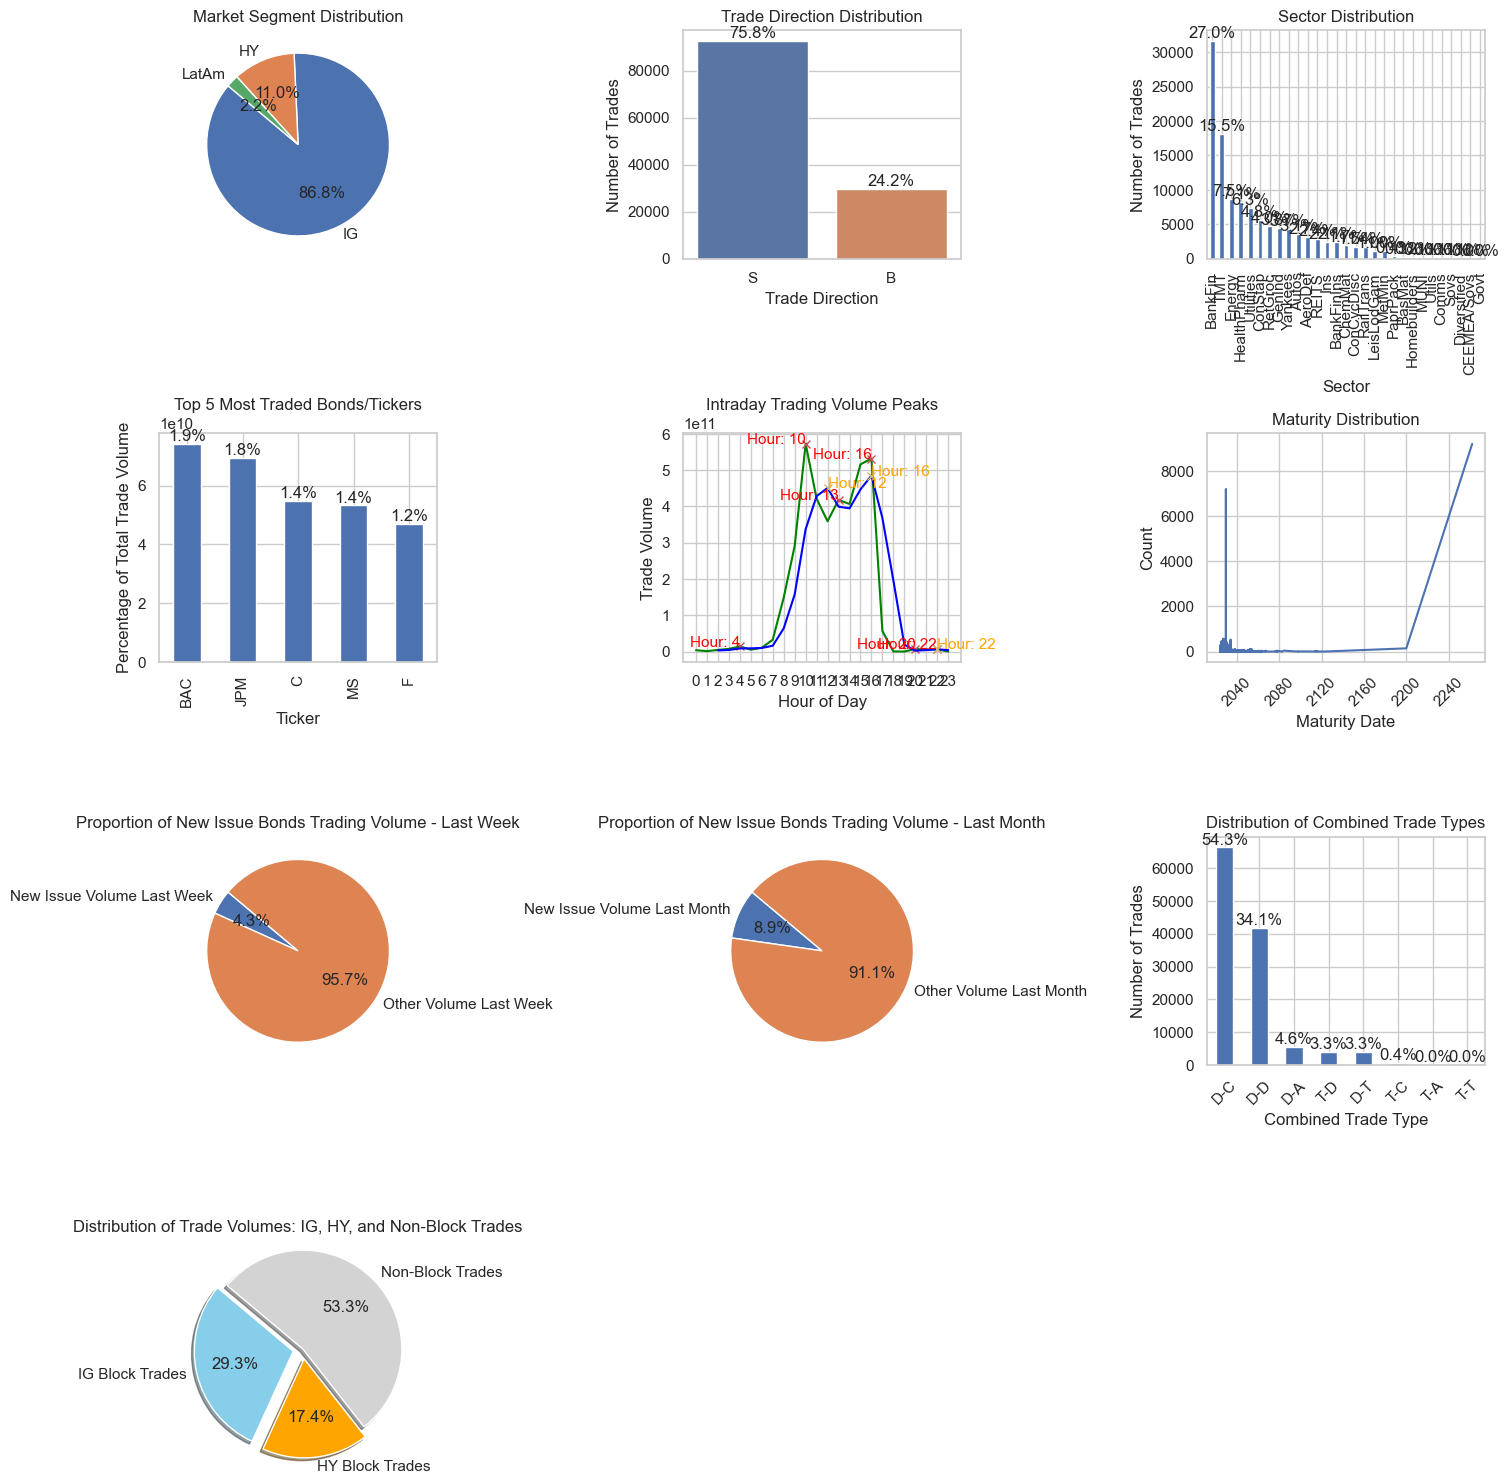

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Data for visualizations
market_segment_distribution = data_1['MARKET_SEGMENT'].value_counts(normalize=True)
trade_direction_distribution = data_1['REPORTING_PARTY_SIDE'].value_counts()
sector_distribution = data_1['SECTOR'].value_counts()
top_5_traded_bonds = data_1.groupby('TICKER')['TRADE_VOLUME'].sum().nlargest(5)
volume_by_hour = data_1.groupby(data_1['TRADE_DATETIME'].dt.hour)['TRADE_VOLUME'].sum()
maturity_distribution = data_1['MATURITY_DATE'].value_counts().sort_index()
total_volume = data_1['TRADE_VOLUME'].sum()
top_5_percentages = (top_5_traded_bonds / total_volume) * 100
volumes_week = [volume_new_issue_last_week_1, total_volume - volume_new_issue_last_week_1]
volumes_month = [volume_new_issue_last_month_1, total_volume - volume_new_issue_last_month_1]
trade_type_counts = data_1['CombinedTradeType'].value_counts()
total_trades = trade_type_counts.sum()
trade_type_percentages = (trade_type_counts / total_trades) * 100
# Labels for the pie charts
labels_week = ['New Issue Volume Last Week', 'Other Volume Last Week']
labels_month = ['New Issue Volume Last Month', 'Other Volume Last Month']


# Filter block trades for IG and HY
block_trades_IG = data_1[(data_1['MARKET_SEGMENT'] == 'IG') & (data_1['ASSUMED_QUANTITY'] >= IG_THRESHOLD)]
block_trades_HY = data_1[(data_1['MARKET_SEGMENT'] == 'HY') & (data_1['ASSUMED_QUANTITY'] >= HY_THRESHOLD)]

# Combine IG and HY block trades
block_trades = pd.concat([block_trades_IG, block_trades_HY])

# Calculate total block trade volume
total_block_volume = block_trades['TRADE_VOLUME'].sum()

# Calculate total trading volume in the dataset
total_volume = data_1['TRADE_VOLUME'].sum()

# Calculate the percentage of total volume
block_trade_percentage = (total_block_volume / total_volume) * 100

# Function to add percentage annotations
def add_percentage_annotations(ax, data):
    total = data.sum()
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom')


# Plotting
plt.figure(figsize=(15, 15))

# Market Segment Distribution Pie Chart
plt.subplot(4, 3, 1)
plt.pie(market_segment_distribution, labels=market_segment_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Market Segment Distribution')

# Trade Direction Distribution Bar Chart
plt.subplot(4, 3, 2)
ax_trade_dir = sns.barplot(x=trade_direction_distribution.index, y=trade_direction_distribution.values)
plt.title('Trade Direction Distribution')
add_percentage_annotations(ax_trade_dir, trade_direction_distribution)
plt.xlabel('Trade Direction')
plt.ylabel('Number of Trades')


# Sector Distribution Bar Chart
plt.subplot(4, 3, 3)
ax_sector = sector_distribution.plot(kind='bar')
plt.title('Sector Distribution')
add_percentage_annotations(ax_sector, sector_distribution)
plt.xlabel('Sector')
plt.ylabel('Number of Trades')

# Top 5 Most Traded Bonds/Tickers as Percentage of All Trades
plt.subplot(4, 3, 4)
ax_top5 = top_5_traded_bonds.plot(kind='bar')
plt.title('Top 5 Most Traded Bonds/Tickers')
plt.xlabel('Ticker')
plt.ylabel('Percentage of Total Trade Volume')
for index, value in enumerate(top_5_traded_bonds):
    plt.text(index, value, f'{top_5_percentages[index]:.1f}%', ha='center', va='bottom')



# Volume Distribution by Time of Day Line Chart
plt.subplot(4, 3, 5)

# Plot the original data
volume_by_hour.plot(kind='line', color='green', label='Trade Volume')

# Find peaks - local maxima for original data
original_peaks, _ = find_peaks(volume_by_hour, prominence=1)

# Highlight peaks for original data with red markers and annotate the hour number
for peak in original_peaks:
    plt.plot(peak, volume_by_hour.iloc[peak], 'rx')  # Red marker for peak
    plt.text(peak, volume_by_hour.iloc[peak], f'Hour: {peak}', color='red', fontsize=11, ha='right')

# Calculate and plot a moving average
moving_avg_period = 3  # This can be adjusted based on the dataset
moving_avg = volume_by_hour.rolling(window=moving_avg_period).mean()
moving_avg.plot(color='blue', label=f'{moving_avg_period}-Hour Moving Average')

# Find peaks for the moving average
moving_avg_peaks, _ = find_peaks(moving_avg, prominence=1)

# Highlight peaks for moving average with yellow markers and annotate the hour number
for peak in moving_avg_peaks:
    plt.plot(peak, moving_avg.iloc[peak], 'yx')  # Yellow marker for peak
    plt.text(peak, moving_avg.iloc[peak], f'Hour: {peak}', color='orange', fontsize=11, ha='left')

plt.title('Intraday Trading Volume Peaks')
plt.xlabel('Hour of Day')
plt.ylabel('Trade Volume')
plt.xticks(range(0, 24))



# Maturity Distribution Line Chart
plt.subplot(4, 3, 6)
perpetuities_count = (data_1['MATURITY_DATE'] >= '2262-04-11').sum()
percent_count = perpetuities_count / data_1['MATURITY_DATE'].count()

print(f'Percentage of perpetuities: {percent_count*100} %')
plt.plot(maturity_distribution.index, maturity_distribution.values)
plt.xlabel('Maturity Date')
plt.ylabel('Count')
plt.title('Maturity Distribution')
plt.xticks(rotation=45)
plt.grid(True)



# Proportion of New Issue Bonds Trading Volume - Last Week
plt.subplot(4, 3, 7)
plt.pie(volumes_week, labels=labels_week, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of New Issue Bonds Trading Volume - Last Week')

# Proportion of New Issue Bonds Trading Volume - Last Month
plt.subplot(4, 3, 8)
plt.pie(volumes_month, labels=labels_month, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of New Issue Bonds Trading Volume - Last Month')

# Plotting the Trade Type distribution
plt.subplot(4, 3, 9)
trade_type_counts.plot(kind='bar')
plt.title('Distribution of Combined Trade Types')
for index, value in enumerate(trade_type_counts):
    plt.text(index, value, f'{trade_type_percentages[index]:.1f}%', ha='center', va='bottom')

plt.xlabel('Combined Trade Type')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)


total_block_volume_IG = block_trades_IG['TRADE_VOLUME'].sum()
total_block_volume_HY = block_trades_HY['TRADE_VOLUME'].sum()


non_block_trade_volume = total_volume - (total_block_volume_IG + total_block_volume_HY)



# Plotting the Block Trades distribution
plt.subplot(4, 3, 10)
labels = ['IG Block Trades', 'HY Block Trades', 'Non-Block Trades']
sizes = [total_block_volume_IG, total_block_volume_HY, non_block_trade_volume]
colors = ['skyblue', 'orange', 'lightgrey']
explode = (0.1, 0.1, 0)  # 'Explode' both IG and HY slices

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  
plt.title('Distribution of Trade Volumes: IG, HY, and Non-Block Trades')




plt.tight_layout()
plt.show()


Percentage of perpetuities: 8.732929275623041 %


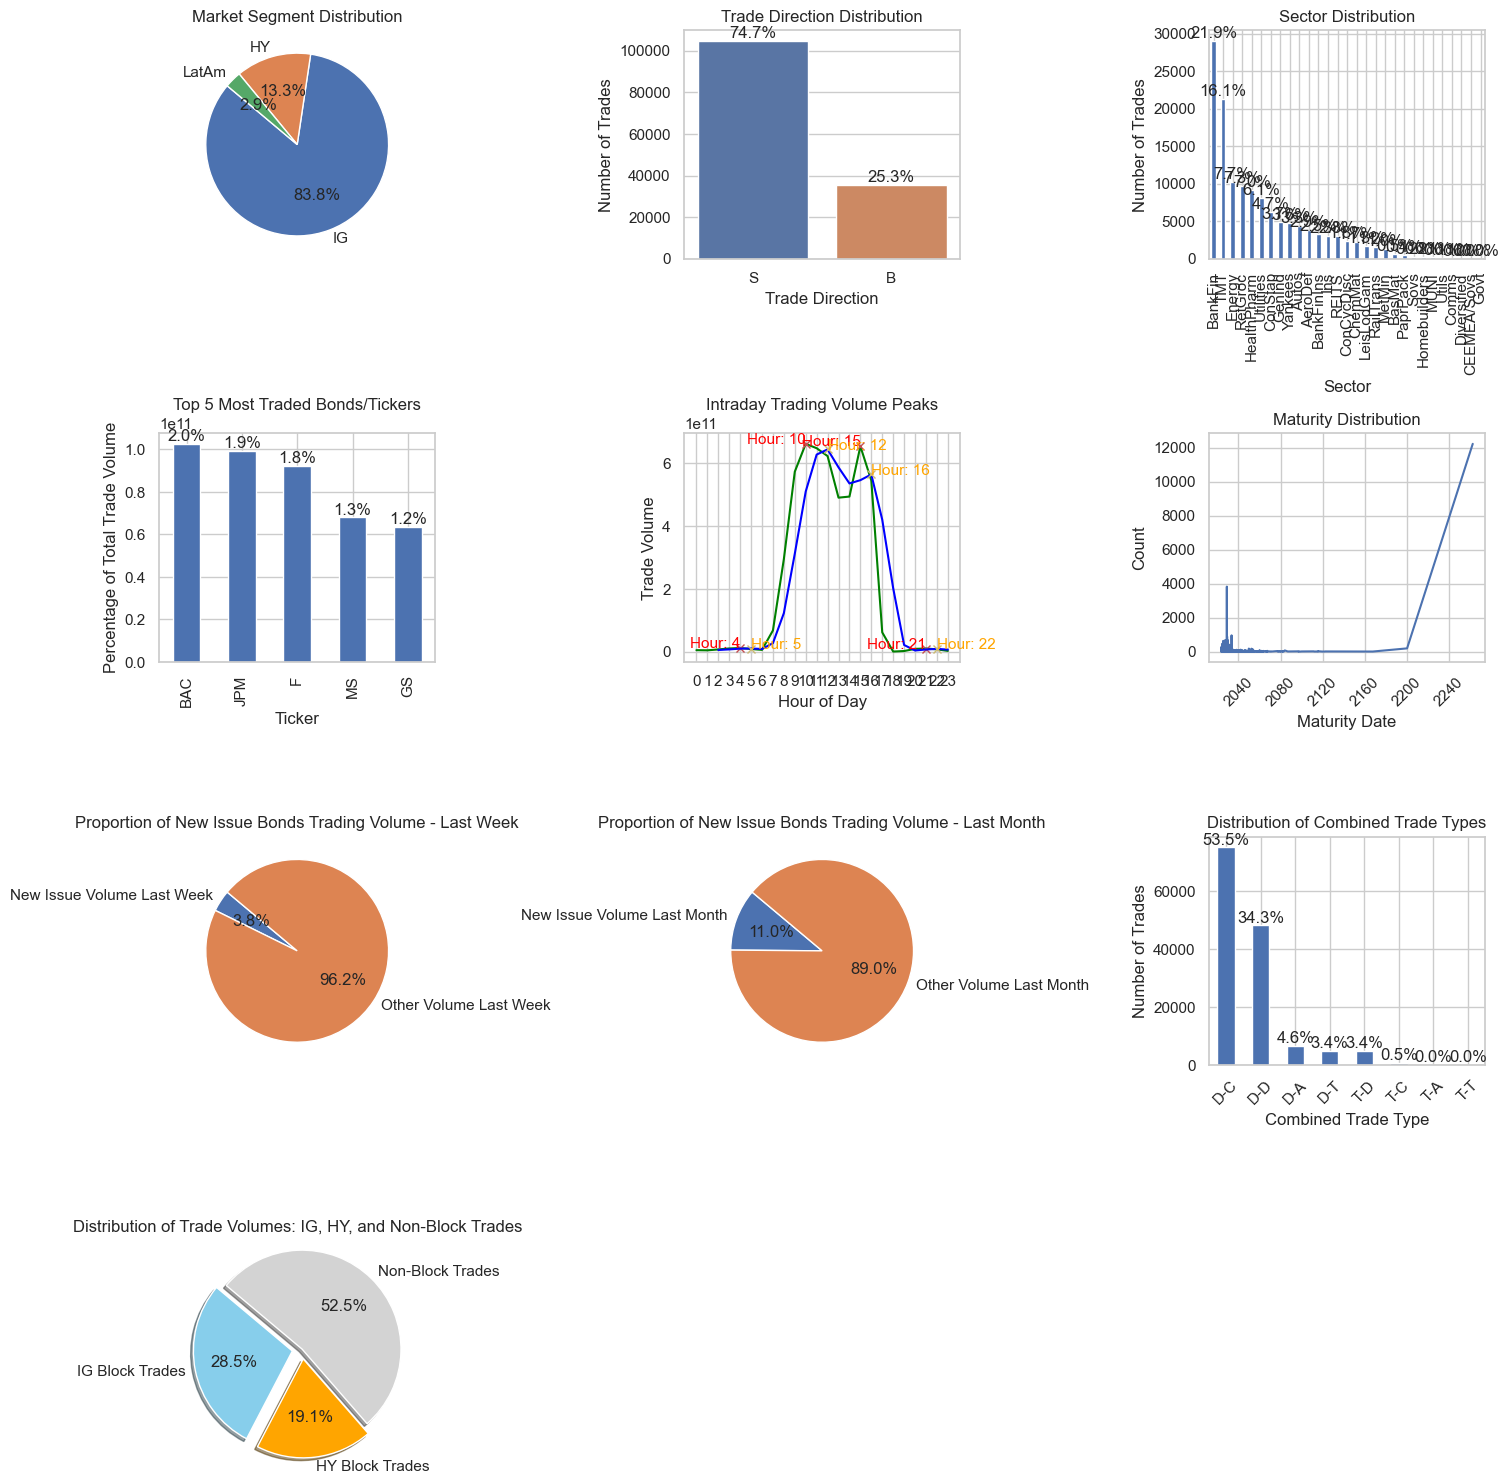

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Data for visualizations
market_segment_distribution = data_2['MARKET_SEGMENT'].value_counts(normalize=True)
trade_direction_distribution = data_2['REPORTING_PARTY_SIDE'].value_counts()
sector_distribution = data_2['SECTOR'].value_counts()
top_5_traded_bonds = data_2.groupby('TICKER')['TRADE_VOLUME'].sum().nlargest(5)
volume_by_hour = data_2.groupby(data_2['TRADE_DATETIME'].dt.hour)['TRADE_VOLUME'].sum()
maturity_distribution = data_2['MATURITY_DATE'].value_counts().sort_index()
total_volume = data_2['TRADE_VOLUME'].sum()
top_5_percentages = (top_5_traded_bonds / total_volume) * 100
volumes_week = [volume_new_issue_last_week_2, total_volume - volume_new_issue_last_week_2]
volumes_month = [volume_new_issue_last_month_2, total_volume - volume_new_issue_last_month_2]
trade_type_counts = data_2['CombinedTradeType'].value_counts()
total_trades = trade_type_counts.sum()
trade_type_percentages = (trade_type_counts / total_trades) * 100
# Labels for the pie charts
labels_week = ['New Issue Volume Last Week', 'Other Volume Last Week']
labels_month = ['New Issue Volume Last Month', 'Other Volume Last Month']


# Filter block trades for IG and HY
block_trades_IG = data_2[(data_2['MARKET_SEGMENT'] == 'IG') & (data_2['ASSUMED_QUANTITY'] >= IG_THRESHOLD)]
block_trades_HY = data_2[(data_2['MARKET_SEGMENT'] == 'HY') & (data_2['ASSUMED_QUANTITY'] >= HY_THRESHOLD)]

# Combine IG and HY block trades
block_trades = pd.concat([block_trades_IG, block_trades_HY])

# Calculate total block trade volume
total_block_volume = block_trades['TRADE_VOLUME'].sum()

# Calculate total trading volume in the dataset
total_volume = data_2['TRADE_VOLUME'].sum()

# Calculate the percentage of total volume
block_trade_percentage = (total_block_volume / total_volume) * 100

# Function to add percentage annotations
def add_percentage_annotations(ax, data):
    total = data.sum()
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom')


# Plotting
plt.figure(figsize=(15, 15))

# Market Segment Distribution Pie Chart
plt.subplot(4, 3, 1)
plt.pie(market_segment_distribution, labels=market_segment_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Market Segment Distribution')

# Trade Direction Distribution Bar Chart
plt.subplot(4, 3, 2)
ax_trade_dir = sns.barplot(x=trade_direction_distribution.index, y=trade_direction_distribution.values)
plt.title('Trade Direction Distribution')
add_percentage_annotations(ax_trade_dir, trade_direction_distribution)
plt.xlabel('Trade Direction')
plt.ylabel('Number of Trades')


# Sector Distribution Bar Chart
plt.subplot(4, 3, 3)
ax_sector = sector_distribution.plot(kind='bar')
plt.title('Sector Distribution')
add_percentage_annotations(ax_sector, sector_distribution)
plt.xlabel('Sector')
plt.ylabel('Number of Trades')

# Top 5 Most Traded Bonds/Tickers as Percentage of All Trades
plt.subplot(4, 3, 4)
ax_top5 = top_5_traded_bonds.plot(kind='bar')
plt.title('Top 5 Most Traded Bonds/Tickers')
plt.xlabel('Ticker')
plt.ylabel('Percentage of Total Trade Volume')
for index, value in enumerate(top_5_traded_bonds):
    plt.text(index, value, f'{top_5_percentages[index]:.1f}%', ha='center', va='bottom')



# Volume Distribution by Time of Day Line Chart
plt.subplot(4, 3, 5)

# Plot the original data
volume_by_hour.plot(kind='line', color='green', label='Trade Volume')

# Find peaks - local maxima for original data
original_peaks, _ = find_peaks(volume_by_hour, prominence=1)

# Highlight peaks for original data with red markers and annotate the hour number
for peak in original_peaks:
    plt.plot(peak, volume_by_hour.iloc[peak], 'rx')  # Red marker for peak
    plt.text(peak, volume_by_hour.iloc[peak], f'Hour: {peak}', color='red', fontsize=11, ha='right')

# Calculate and plot a moving average
moving_avg_period = 3 
moving_avg = volume_by_hour.rolling(window=moving_avg_period).mean()
moving_avg.plot(color='blue', label=f'{moving_avg_period}-Hour Moving Average')

# Find peaks for the moving average
moving_avg_peaks, _ = find_peaks(moving_avg, prominence=1)

# Highlight peaks for moving average with yellow markers and annotate the hour number
for peak in moving_avg_peaks:
    plt.plot(peak, moving_avg.iloc[peak], 'yx') 
    plt.text(peak, moving_avg.iloc[peak], f'Hour: {peak}', color='orange', fontsize=11, ha='left')

plt.title('Intraday Trading Volume Peaks')
plt.xlabel('Hour of Day')
plt.ylabel('Trade Volume')
plt.xticks(range(0, 24))



# Maturity Distribution Line Chart
plt.subplot(4, 3, 6)
perpetuities_count = (data_2['MATURITY_DATE'] >= '2262-04-11').sum()
percent_count = perpetuities_count / data_2['MATURITY_DATE'].count()

print(f'Percentage of perpetuities: {percent_count*100} %')
plt.plot(maturity_distribution.index, maturity_distribution.values)
plt.xlabel('Maturity Date')
plt.ylabel('Count')
plt.title('Maturity Distribution')
plt.xticks(rotation=45)
plt.grid(True)



# Proportion of New Issue Bonds Trading Volume - Last Week
plt.subplot(4, 3, 7)
plt.pie(volumes_week, labels=labels_week, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of New Issue Bonds Trading Volume - Last Week')

# Proportion of New Issue Bonds Trading Volume - Last Month
plt.subplot(4, 3, 8)
plt.pie(volumes_month, labels=labels_month, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of New Issue Bonds Trading Volume - Last Month')

# Plotting the Trade Type distribution
plt.subplot(4, 3, 9)
trade_type_counts.plot(kind='bar')
plt.title('Distribution of Combined Trade Types')
for index, value in enumerate(trade_type_counts):
    plt.text(index, value, f'{trade_type_percentages[index]:.1f}%', ha='center', va='bottom')

plt.xlabel('Combined Trade Type')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)


total_block_volume_IG = block_trades_IG['TRADE_VOLUME'].sum()
total_block_volume_HY = block_trades_HY['TRADE_VOLUME'].sum()


non_block_trade_volume = total_volume - (total_block_volume_IG + total_block_volume_HY)



# Plotting the Block Trades distribution
plt.subplot(4, 3, 10)
labels = ['IG Block Trades', 'HY Block Trades', 'Non-Block Trades']
sizes = [total_block_volume_IG, total_block_volume_HY, non_block_trade_volume]
colors = ['skyblue', 'orange', 'lightgrey']
explode = (0.1, 0.1, 0) 

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal') 
plt.title('Distribution of Trade Volumes: IG, HY, and Non-Block Trades')




plt.tight_layout()
plt.show()


Percentage of perpetuities: 8.40850984911709 %


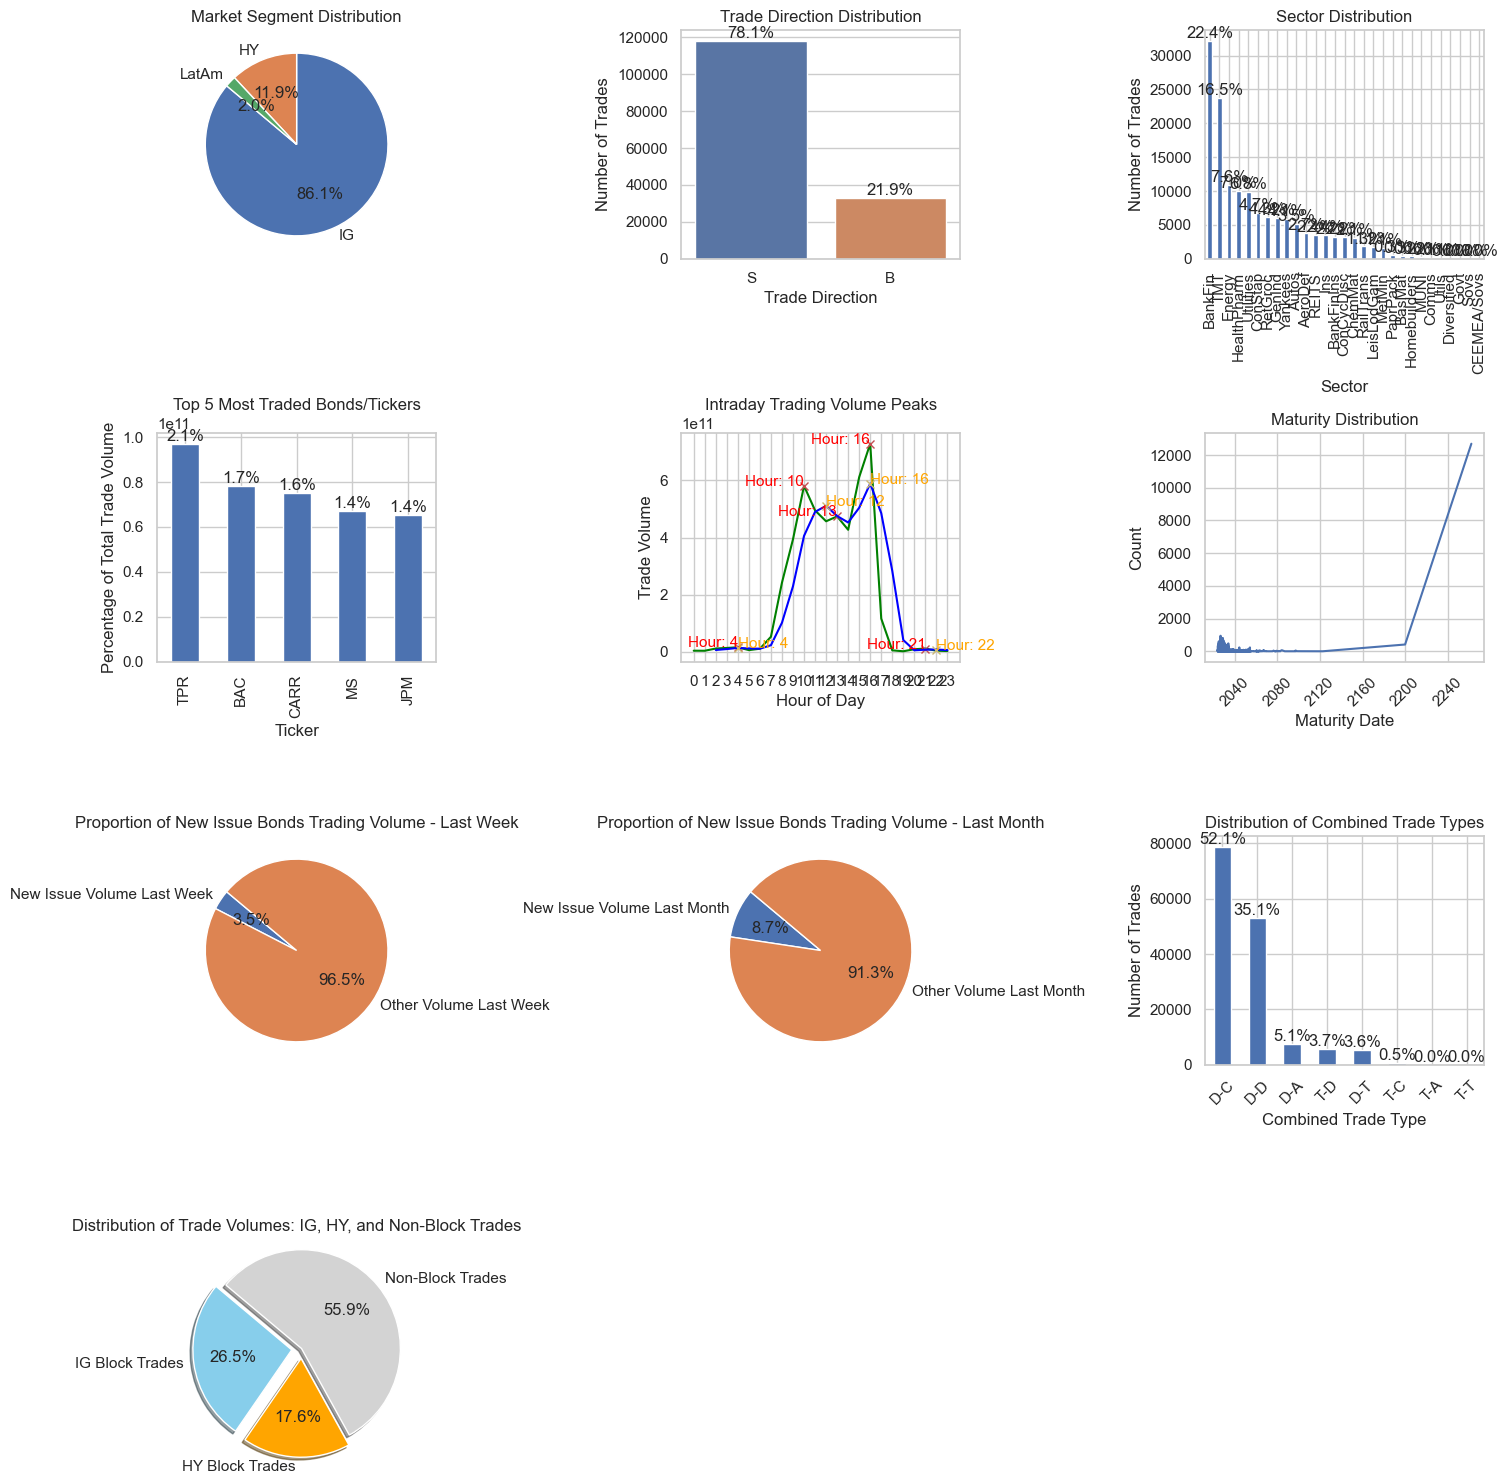

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Data for visualizations
market_segment_distribution = data_3['MARKET_SEGMENT'].value_counts(normalize=True)
trade_direction_distribution = data_3['REPORTING_PARTY_SIDE'].value_counts()
sector_distribution = data_3['SECTOR'].value_counts()
top_5_traded_bonds = data_3.groupby('TICKER')['TRADE_VOLUME'].sum().nlargest(5)
volume_by_hour = data_3.groupby(data_3['TRADE_DATETIME'].dt.hour)['TRADE_VOLUME'].sum()
maturity_distribution = data_3['MATURITY_DATE'].value_counts().sort_index()
total_volume = data_3['TRADE_VOLUME'].sum()
top_5_percentages = (top_5_traded_bonds / total_volume) * 100
volumes_week = [volume_new_issue_last_week_3, total_volume - volume_new_issue_last_week_3]
volumes_month = [volume_new_issue_last_month_3, total_volume - volume_new_issue_last_month_3]
trade_type_counts = data_3['CombinedTradeType'].value_counts()
total_trades = trade_type_counts.sum()
trade_type_percentages = (trade_type_counts / total_trades) * 100
# Labels for the pie charts
labels_week = ['New Issue Volume Last Week', 'Other Volume Last Week']
labels_month = ['New Issue Volume Last Month', 'Other Volume Last Month']


# Filter block trades for IG and HY
block_trades_IG = data_3[(data_3['MARKET_SEGMENT'] == 'IG') & (data_3['ASSUMED_QUANTITY'] >= IG_THRESHOLD)]
block_trades_HY = data_3[(data_3['MARKET_SEGMENT'] == 'HY') & (data_3['ASSUMED_QUANTITY'] >= HY_THRESHOLD)]

# Combine IG and HY block trades
block_trades = pd.concat([block_trades_IG, block_trades_HY])

# Calculate total block trade volume
total_block_volume = block_trades['TRADE_VOLUME'].sum()

# Calculate total trading volume in the dataset
total_volume = data_3['TRADE_VOLUME'].sum()

# Calculate the percentage of total volume
block_trade_percentage = (total_block_volume / total_volume) * 100

# Function to add percentage annotations
def add_percentage_annotations(ax, data):
    total = data.sum()
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom')


# Plotting
plt.figure(figsize=(15, 15))

# Market Segment Distribution Pie Chart
plt.subplot(4, 3, 1)
plt.pie(market_segment_distribution, labels=market_segment_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Market Segment Distribution')

# Trade Direction Distribution Bar Chart
plt.subplot(4, 3, 2)
ax_trade_dir = sns.barplot(x=trade_direction_distribution.index, y=trade_direction_distribution.values)
plt.title('Trade Direction Distribution')
add_percentage_annotations(ax_trade_dir, trade_direction_distribution)
plt.xlabel('Trade Direction')
plt.ylabel('Number of Trades')


# Sector Distribution Bar Chart
plt.subplot(4, 3, 3)
ax_sector = sector_distribution.plot(kind='bar')
plt.title('Sector Distribution')
add_percentage_annotations(ax_sector, sector_distribution)
plt.xlabel('Sector')
plt.ylabel('Number of Trades')

# Top 5 Most Traded Bonds/Tickers as Percentage of All Trades
plt.subplot(4, 3, 4)
ax_top5 = top_5_traded_bonds.plot(kind='bar')
plt.title('Top 5 Most Traded Bonds/Tickers')
plt.xlabel('Ticker')
plt.ylabel('Percentage of Total Trade Volume')
for index, value in enumerate(top_5_traded_bonds):
    plt.text(index, value, f'{top_5_percentages[index]:.1f}%', ha='center', va='bottom')



# Volume Distribution by Time of Day Line Chart
plt.subplot(4, 3, 5)

# Plot the original data
volume_by_hour.plot(kind='line', color='green', label='Trade Volume')

# Find peaks - local maxima for original data
original_peaks, _ = find_peaks(volume_by_hour, prominence=1)

# Highlight peaks for original data with red markers and annotate the hour number
for peak in original_peaks:
    plt.plot(peak, volume_by_hour.iloc[peak], 'rx') 
    plt.text(peak, volume_by_hour.iloc[peak], f'Hour: {peak}', color='red', fontsize=11, ha='right')

# Calculate and plot a moving average
moving_avg_period = 3  
moving_avg = volume_by_hour.rolling(window=moving_avg_period).mean()
moving_avg.plot(color='blue', label=f'{moving_avg_period}-Hour Moving Average')

# Find peaks for the moving average
moving_avg_peaks, _ = find_peaks(moving_avg, prominence=1)

# Highlight peaks for moving average with yellow markers and annotate the hour number
for peak in moving_avg_peaks:
    plt.plot(peak, moving_avg.iloc[peak], 'yx')  
    plt.text(peak, moving_avg.iloc[peak], f'Hour: {peak}', color='orange', fontsize=11, ha='left')

plt.title('Intraday Trading Volume Peaks')
plt.xlabel('Hour of Day')
plt.ylabel('Trade Volume')
plt.xticks(range(0, 24))



# Maturity Distribution Line Chart
plt.subplot(4, 3, 6)
perpetuities_count = (data_3['MATURITY_DATE'] >= '2262-04-11').sum()
percent_count = perpetuities_count / data_3['MATURITY_DATE'].count()

print(f'Percentage of perpetuities: {percent_count*100} %')
plt.plot(maturity_distribution.index, maturity_distribution.values)
plt.xlabel('Maturity Date')
plt.ylabel('Count')
plt.title('Maturity Distribution')
plt.xticks(rotation=45)
plt.grid(True)



# Proportion of New Issue Bonds Trading Volume - Last Week
plt.subplot(4, 3, 7)
plt.pie(volumes_week, labels=labels_week, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of New Issue Bonds Trading Volume - Last Week')

# Proportion of New Issue Bonds Trading Volume - Last Month
plt.subplot(4, 3, 8)
plt.pie(volumes_month, labels=labels_month, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of New Issue Bonds Trading Volume - Last Month')

# Plotting the Trade Type distribution
plt.subplot(4, 3, 9)
trade_type_counts.plot(kind='bar')
plt.title('Distribution of Combined Trade Types')
for index, value in enumerate(trade_type_counts):
    plt.text(index, value, f'{trade_type_percentages[index]:.1f}%', ha='center', va='bottom')

plt.xlabel('Combined Trade Type')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)


total_block_volume_IG = block_trades_IG['TRADE_VOLUME'].sum()
total_block_volume_HY = block_trades_HY['TRADE_VOLUME'].sum()

# Assuming total_volume is the total trading volume in your dataset
non_block_trade_volume = total_volume - (total_block_volume_IG + total_block_volume_HY)



# Plotting the Block Trades distribution
plt.subplot(4, 3, 10)
labels = ['IG Block Trades', 'HY Block Trades', 'Non-Block Trades']
sizes = [total_block_volume_IG, total_block_volume_HY, non_block_trade_volume]
colors = ['skyblue', 'orange', 'lightgrey']
explode = (0.1, 0.1, 0) 

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal') 
plt.title('Distribution of Trade Volumes: IG, HY, and Non-Block Trades')




plt.tight_layout()
plt.show()


Percentage of perpetuities: 8.56208637048354 %


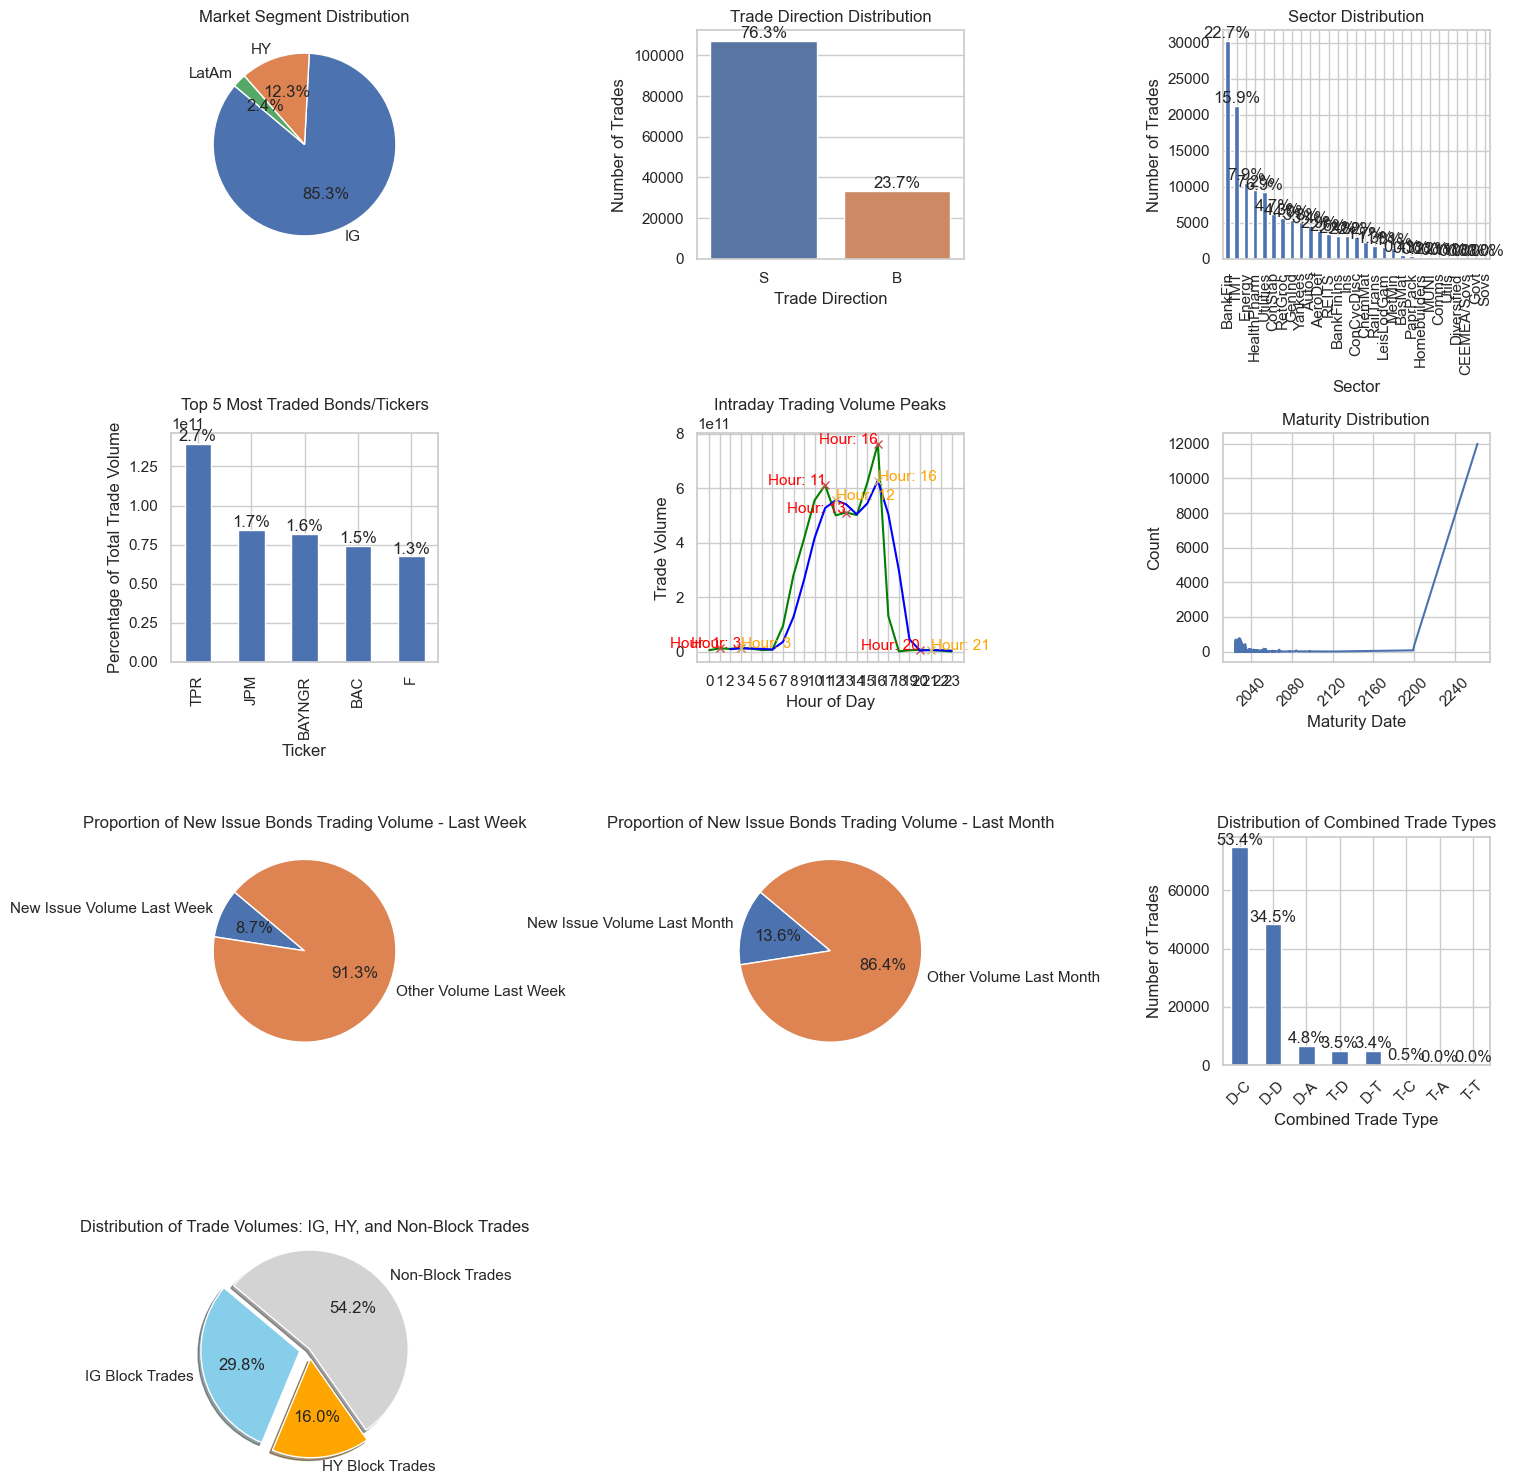

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Data for visualizations
market_segment_distribution = data_4['MARKET_SEGMENT'].value_counts(normalize=True)
trade_direction_distribution = data_4['REPORTING_PARTY_SIDE'].value_counts()
sector_distribution = data_4['SECTOR'].value_counts()
top_5_traded_bonds = data_4.groupby('TICKER')['TRADE_VOLUME'].sum().nlargest(5)
volume_by_hour = data_4.groupby(data_4['TRADE_DATETIME'].dt.hour)['TRADE_VOLUME'].sum()
maturity_distribution = data_4['MATURITY_DATE'].value_counts().sort_index()
total_volume = data_4['TRADE_VOLUME'].sum()
top_5_percentages = (top_5_traded_bonds / total_volume) * 100
volumes_week = [volume_new_issue_last_week_4, total_volume - volume_new_issue_last_week_4]
volumes_month = [volume_new_issue_last_month_4, total_volume - volume_new_issue_last_month_4]
trade_type_counts = data_4['CombinedTradeType'].value_counts()
total_trades = trade_type_counts.sum()
trade_type_percentages = (trade_type_counts / total_trades) * 100
# Labels for the pie charts
labels_week = ['New Issue Volume Last Week', 'Other Volume Last Week']
labels_month = ['New Issue Volume Last Month', 'Other Volume Last Month']


# Filter block trades for IG and HY
block_trades_IG = data_4[(data_4['MARKET_SEGMENT'] == 'IG') & (data_4['ASSUMED_QUANTITY'] >= IG_THRESHOLD)]
block_trades_HY = data_4[(data_4['MARKET_SEGMENT'] == 'HY') & (data_4['ASSUMED_QUANTITY'] >= HY_THRESHOLD)]

# Combine IG and HY block trades
block_trades = pd.concat([block_trades_IG, block_trades_HY])

# Calculate total block trade volume
total_block_volume = block_trades['TRADE_VOLUME'].sum()

# Calculate total trading volume in the dataset
total_volume = data_4['TRADE_VOLUME'].sum()

# Calculate the percentage of total volume
block_trade_percentage = (total_block_volume / total_volume) * 100

# Function to add percentage annotations
def add_percentage_annotations(ax, data):
    total = data.sum()
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom')


# Plotting
plt.figure(figsize=(15, 15))

# Market Segment Distribution Pie Chart
plt.subplot(4, 3, 1)
plt.pie(market_segment_distribution, labels=market_segment_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Market Segment Distribution')

# Trade Direction Distribution Bar Chart
plt.subplot(4, 3, 2)
ax_trade_dir = sns.barplot(x=trade_direction_distribution.index, y=trade_direction_distribution.values)
plt.title('Trade Direction Distribution')
add_percentage_annotations(ax_trade_dir, trade_direction_distribution)
plt.xlabel('Trade Direction')
plt.ylabel('Number of Trades')


# Sector Distribution Bar Chart
plt.subplot(4, 3, 3)
ax_sector = sector_distribution.plot(kind='bar')
plt.title('Sector Distribution')
add_percentage_annotations(ax_sector, sector_distribution)
plt.xlabel('Sector')
plt.ylabel('Number of Trades')

# Top 5 Most Traded Bonds/Tickers as Percentage of All Trades
plt.subplot(4, 3, 4)
ax_top5 = top_5_traded_bonds.plot(kind='bar')
plt.title('Top 5 Most Traded Bonds/Tickers')
plt.xlabel('Ticker')
plt.ylabel('Percentage of Total Trade Volume')
for index, value in enumerate(top_5_traded_bonds):
    plt.text(index, value, f'{top_5_percentages[index]:.1f}%', ha='center', va='bottom')



# Volume Distribution by Time of Day Line Chart
plt.subplot(4, 3, 5)

# Plot the original data
volume_by_hour.plot(kind='line', color='green', label='Trade Volume')

# Find peaks - local maxima for original data
original_peaks, _ = find_peaks(volume_by_hour, prominence=1)

# Highlight peaks for original data with red markers and annotate the hour number
for peak in original_peaks:
    plt.plot(peak, volume_by_hour.iloc[peak], 'rx') 
    plt.text(peak, volume_by_hour.iloc[peak], f'Hour: {peak}', color='red', fontsize=11, ha='right')

# Calculate and plot a moving average
moving_avg_period = 3  
moving_avg = volume_by_hour.rolling(window=moving_avg_period).mean()
moving_avg.plot(color='blue', label=f'{moving_avg_period}-Hour Moving Average')

# Find peaks for the moving average
moving_avg_peaks, _ = find_peaks(moving_avg, prominence=1)

# Highlight peaks for moving average with yellow markers and annotate the hour number
for peak in moving_avg_peaks:
    plt.plot(peak, moving_avg.iloc[peak], 'yx')  
    plt.text(peak, moving_avg.iloc[peak], f'Hour: {peak}', color='orange', fontsize=11, ha='left')

plt.title('Intraday Trading Volume Peaks')
plt.xlabel('Hour of Day')
plt.ylabel('Trade Volume')
plt.xticks(range(0, 24))



# Maturity Distribution Line Chart
plt.subplot(4, 3, 6)
perpetuities_count = (data_4['MATURITY_DATE'] >= '2262-04-11').sum()
percent_count = perpetuities_count / data_4['MATURITY_DATE'].count()

print(f'Percentage of perpetuities: {percent_count*100} %')
plt.plot(maturity_distribution.index, maturity_distribution.values)
plt.xlabel('Maturity Date')
plt.ylabel('Count')
plt.title('Maturity Distribution')
plt.xticks(rotation=45)
plt.grid(True)



# Proportion of New Issue Bonds Trading Volume - Last Week
plt.subplot(4, 3, 7)
plt.pie(volumes_week, labels=labels_week, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of New Issue Bonds Trading Volume - Last Week')

# Proportion of New Issue Bonds Trading Volume - Last Month
plt.subplot(4, 3, 8)
plt.pie(volumes_month, labels=labels_month, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of New Issue Bonds Trading Volume - Last Month')

# Plotting the Trade Type distribution
plt.subplot(4, 3, 9)
trade_type_counts.plot(kind='bar')
plt.title('Distribution of Combined Trade Types')
for index, value in enumerate(trade_type_counts):
    plt.text(index, value, f'{trade_type_percentages[index]:.1f}%', ha='center', va='bottom')

plt.xlabel('Combined Trade Type')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)


total_block_volume_IG = block_trades_IG['TRADE_VOLUME'].sum()
total_block_volume_HY = block_trades_HY['TRADE_VOLUME'].sum()


non_block_trade_volume = total_volume - (total_block_volume_IG + total_block_volume_HY)



# Plotting the Block Trades distribution
plt.subplot(4, 3, 10)
labels = ['IG Block Trades', 'HY Block Trades', 'Non-Block Trades']
sizes = [total_block_volume_IG, total_block_volume_HY, non_block_trade_volume]
colors = ['skyblue', 'orange', 'lightgrey']
explode = (0.1, 0.1, 0) 

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal') 
plt.title('Distribution of Trade Volumes: IG, HY, and Non-Block Trades')




plt.tight_layout()
plt.show()


Percentage of perpetuities: 8.123772418456387 %


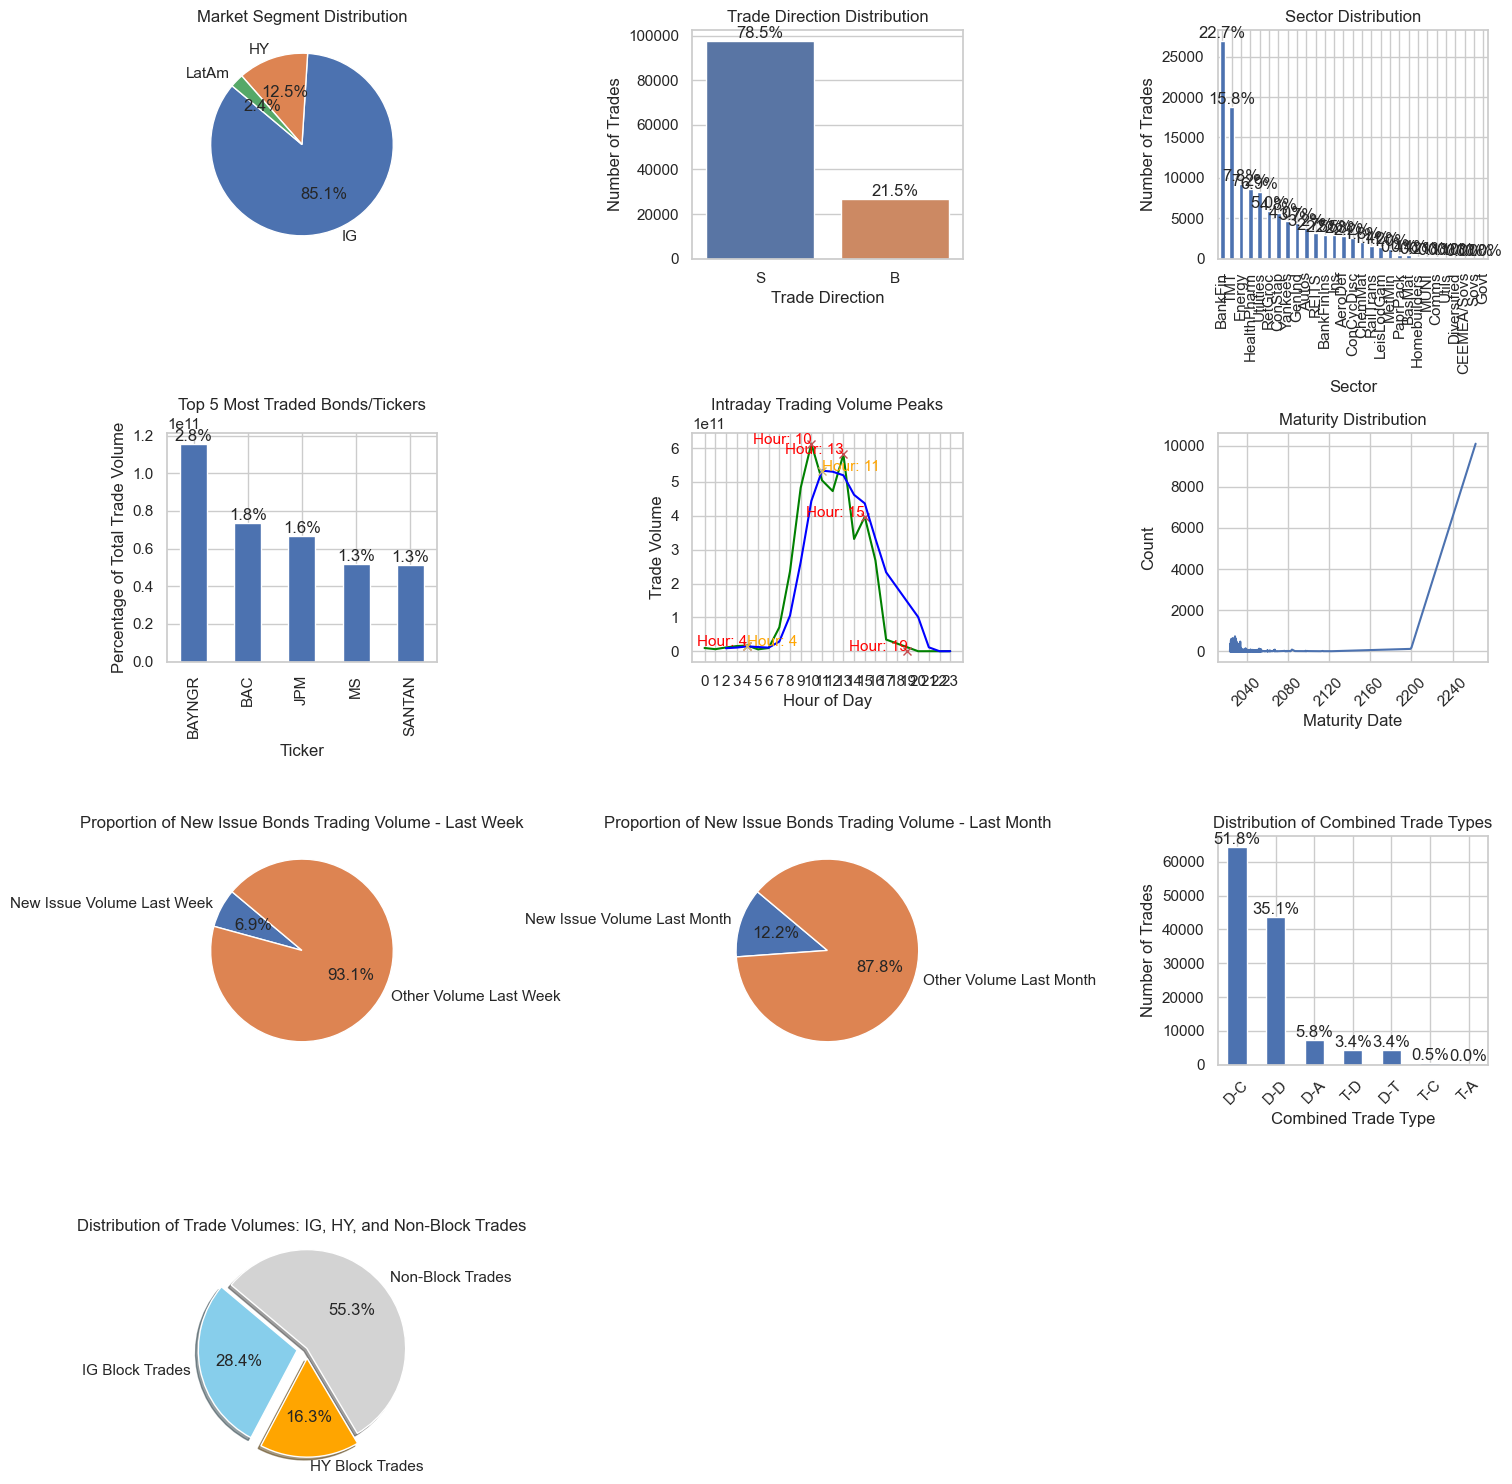

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Data for visualizations
market_segment_distribution = data_5['MARKET_SEGMENT'].value_counts(normalize=True)
trade_direction_distribution = data_5['REPORTING_PARTY_SIDE'].value_counts()
sector_distribution = data_5['SECTOR'].value_counts()
top_5_traded_bonds = data_5.groupby('TICKER')['TRADE_VOLUME'].sum().nlargest(5)
volume_by_hour = data_5.groupby(data_5['TRADE_DATETIME'].dt.hour)['TRADE_VOLUME'].sum()
maturity_distribution = data_5['MATURITY_DATE'].value_counts().sort_index()
total_volume = data_5['TRADE_VOLUME'].sum()
top_5_percentages = (top_5_traded_bonds / total_volume) * 100
volumes_week = [volume_new_issue_last_week_5, total_volume - volume_new_issue_last_week_5]
volumes_month = [volume_new_issue_last_month_5, total_volume - volume_new_issue_last_month_5]
trade_type_counts = data_5['CombinedTradeType'].value_counts()
total_trades = trade_type_counts.sum()
trade_type_percentages = (trade_type_counts / total_trades) * 100
# Labels for the pie charts
labels_week = ['New Issue Volume Last Week', 'Other Volume Last Week']
labels_month = ['New Issue Volume Last Month', 'Other Volume Last Month']


# Filter block trades for IG and HY
block_trades_IG = data_5[(data_5['MARKET_SEGMENT'] == 'IG') & (data_5['ASSUMED_QUANTITY'] >= IG_THRESHOLD)]
block_trades_HY = data_5[(data_5['MARKET_SEGMENT'] == 'HY') & (data_5['ASSUMED_QUANTITY'] >= HY_THRESHOLD)]

# Combine IG and HY block trades
block_trades = pd.concat([block_trades_IG, block_trades_HY])

# Calculate total block trade volume
total_block_volume = block_trades['TRADE_VOLUME'].sum()


total_volume = data_5['TRADE_VOLUME'].sum()

# Calculate the percentage of total volume
block_trade_percentage = (total_block_volume / total_volume) * 100

# Function to add percentage annotations
def add_percentage_annotations(ax, data):
    total = data.sum()
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom')


# Plotting
plt.figure(figsize=(15, 15))

# Market Segment Distribution Pie Chart
plt.subplot(4, 3, 1)
plt.pie(market_segment_distribution, labels=market_segment_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Market Segment Distribution')

# Trade Direction Distribution Bar Chart
plt.subplot(4, 3, 2)
ax_trade_dir = sns.barplot(x=trade_direction_distribution.index, y=trade_direction_distribution.values)
plt.title('Trade Direction Distribution')
add_percentage_annotations(ax_trade_dir, trade_direction_distribution)
plt.xlabel('Trade Direction')
plt.ylabel('Number of Trades')


# Sector Distribution Bar Chart
plt.subplot(4, 3, 3)
ax_sector = sector_distribution.plot(kind='bar')
plt.title('Sector Distribution')
add_percentage_annotations(ax_sector, sector_distribution)
plt.xlabel('Sector')
plt.ylabel('Number of Trades')

# Top 5 Most Traded Bonds/Tickers as Percentage of All Trades
plt.subplot(4, 3, 4)
ax_top5 = top_5_traded_bonds.plot(kind='bar')
plt.title('Top 5 Most Traded Bonds/Tickers')
plt.xlabel('Ticker')
plt.ylabel('Percentage of Total Trade Volume')
for index, value in enumerate(top_5_traded_bonds):
    plt.text(index, value, f'{top_5_percentages[index]:.1f}%', ha='center', va='bottom')



# Volume Distribution by Time of Day Line Chart
plt.subplot(4, 3, 5)

# Plot the original data
volume_by_hour.plot(kind='line', color='green', label='Trade Volume')

# Find peaks - local maxima for original data
original_peaks, _ = find_peaks(volume_by_hour, prominence=1)

# Highlight peaks for original data with red markers and annotate the hour number
for peak in original_peaks:
    plt.plot(peak, volume_by_hour.iloc[peak], 'rx')  # Red marker for peak
    plt.text(peak, volume_by_hour.iloc[peak], f'Hour: {peak}', color='red', fontsize=11, ha='right')

# Calculate and plot a moving average
moving_avg_period = 3  
moving_avg = volume_by_hour.rolling(window=moving_avg_period).mean()
moving_avg.plot(color='blue', label=f'{moving_avg_period}-Hour Moving Average')

# Find peaks for the moving average
moving_avg_peaks, _ = find_peaks(moving_avg, prominence=1)

# Highlight peaks for moving average with yellow markers and annotate the hour number
for peak in moving_avg_peaks:
    plt.plot(peak, moving_avg.iloc[peak], 'yx')  
    plt.text(peak, moving_avg.iloc[peak], f'Hour: {peak}', color='orange', fontsize=11, ha='left')

plt.title('Intraday Trading Volume Peaks')
plt.xlabel('Hour of Day')
plt.ylabel('Trade Volume')
plt.xticks(range(0, 24))



# Maturity Distribution Line Chart
plt.subplot(4, 3, 6)
perpetuities_count = (data_5['MATURITY_DATE'] >= '2262-04-11').sum()
percent_count = perpetuities_count / data_5['MATURITY_DATE'].count()
print(f'Percentage of perpetuities: {percent_count*100} %')

plt.plot(maturity_distribution.index, maturity_distribution.values)
plt.xlabel('Maturity Date')
plt.ylabel('Count')
plt.title('Maturity Distribution')
plt.xticks(rotation=45)
plt.grid(True)



# Proportion of New Issue Bonds Trading Volume - Last Week
plt.subplot(4, 3, 7)
plt.pie(volumes_week, labels=labels_week, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of New Issue Bonds Trading Volume - Last Week')

# Proportion of New Issue Bonds Trading Volume - Last Month
plt.subplot(4, 3, 8)
plt.pie(volumes_month, labels=labels_month, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of New Issue Bonds Trading Volume - Last Month')

# Plotting the Trade Type distribution
plt.subplot(4, 3, 9)
trade_type_counts.plot(kind='bar')
plt.title('Distribution of Combined Trade Types')
for index, value in enumerate(trade_type_counts):
    plt.text(index, value, f'{trade_type_percentages[index]:.1f}%', ha='center', va='bottom')

plt.xlabel('Combined Trade Type')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)


total_block_volume_IG = block_trades_IG['TRADE_VOLUME'].sum()
total_block_volume_HY = block_trades_HY['TRADE_VOLUME'].sum()


non_block_trade_volume = total_volume - (total_block_volume_IG + total_block_volume_HY)



# Plotting the Block Trades distribution
plt.subplot(4, 3, 10)
labels = ['IG Block Trades', 'HY Block Trades', 'Non-Block Trades']
sizes = [total_block_volume_IG, total_block_volume_HY, non_block_trade_volume]
colors = ['skyblue', 'orange', 'lightgrey']
explode = (0.1, 0.1, 0)  

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  
plt.title('Distribution of Trade Volumes: IG, HY, and Non-Block Trades')




plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Market Segment Distribution')

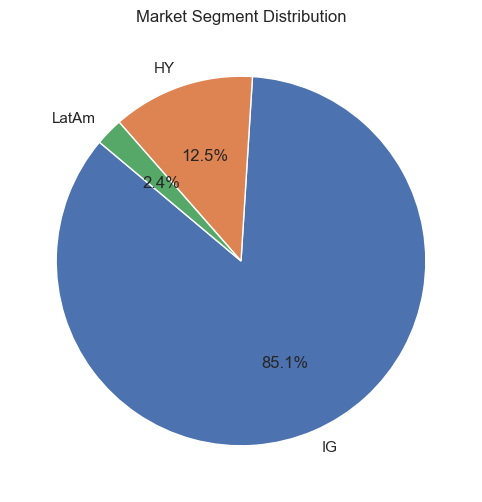

In [12]:
# Market Segment Distribution Pie Chart
plt.figure(figsize=(8, 6))


plt.pie(market_segment_distribution, labels=market_segment_distribution.index, autopct='%1.1f%%', startangle=140)

plt.title('Market Segment Distribution')


Text(0, 0.5, 'Number of Trades')

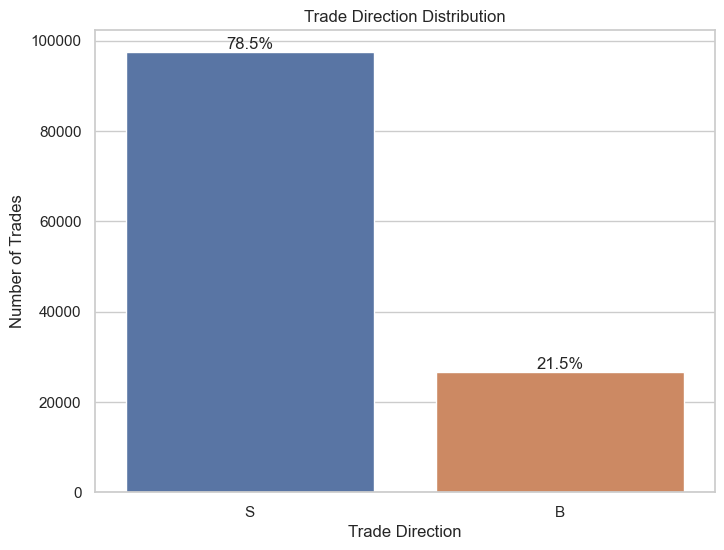

In [13]:
plt.figure(figsize=(8, 6))
ax_trade_dir = sns.barplot(x=trade_direction_distribution.index, y=trade_direction_distribution.values)
plt.title('Trade Direction Distribution')
add_percentage_annotations(ax_trade_dir, trade_direction_distribution)
plt.xlabel('Trade Direction')
plt.ylabel('Number of Trades')

Text(0, 0.5, 'Number of Trades')

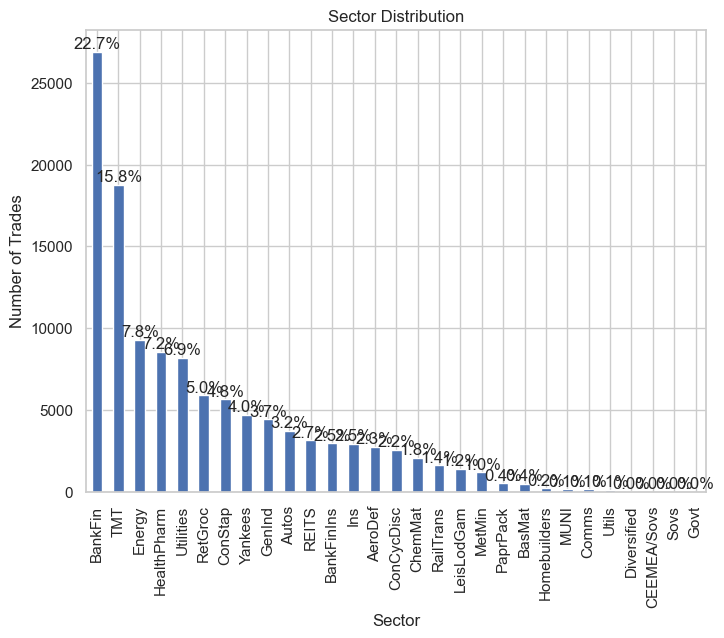

In [14]:
plt.figure(figsize=(8, 6))
ax_sector = sector_distribution.plot(kind='bar')
plt.title('Sector Distribution')
add_percentage_annotations(ax_sector, sector_distribution)
plt.xlabel('Sector')
plt.ylabel('Number of Trades')

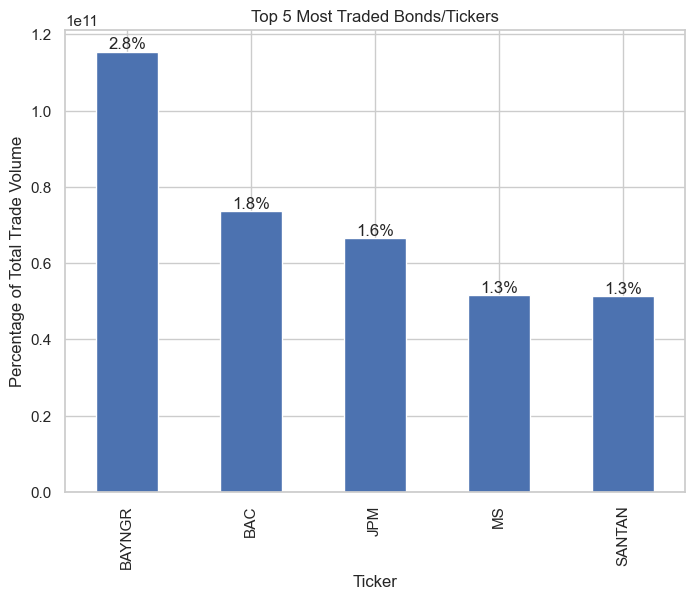

In [15]:
plt.figure(figsize=(8, 6))
ax_top5 = top_5_traded_bonds.plot(kind='bar')
plt.title('Top 5 Most Traded Bonds/Tickers')
plt.xlabel('Ticker')
plt.ylabel('Percentage of Total Trade Volume')
for index, value in enumerate(top_5_traded_bonds):
    plt.text(index, value, f'{top_5_percentages[index]:.1f}%', ha='center', va='bottom')



([<matplotlib.axis.XTick at 0x17763a020>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

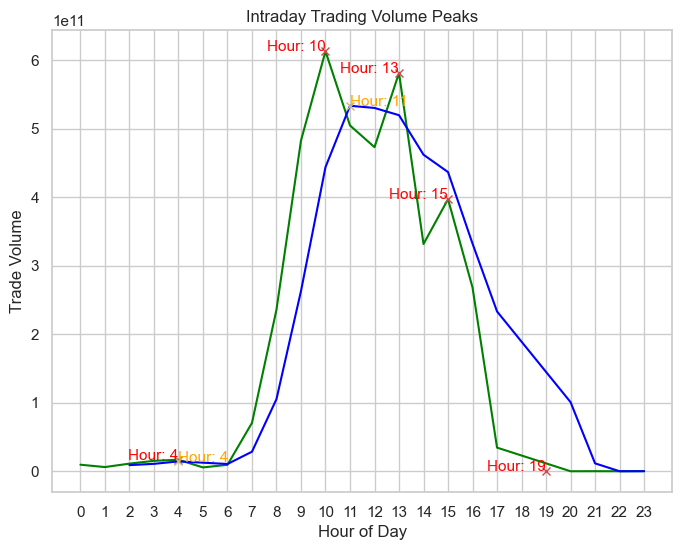

In [16]:
plt.figure(figsize=(8, 6))

# Plot the original data
volume_by_hour.plot(kind='line', color='green', label='Trade Volume')

# Find peaks - local maxima for original data
original_peaks, _ = find_peaks(volume_by_hour, prominence=1)

# Highlight peaks for original data with red markers and annotate the hour number
for peak in original_peaks:
    plt.plot(peak, volume_by_hour.iloc[peak], 'rx')  # Red marker for peak
    plt.text(peak, volume_by_hour.iloc[peak], f'Hour: {peak}', color='red', fontsize=11, ha='right')

# Calculate and plot a moving average
moving_avg_period = 3  # This can be adjusted based on the dataset
moving_avg = volume_by_hour.rolling(window=moving_avg_period).mean()
moving_avg.plot(color='blue', label=f'{moving_avg_period}-Hour Moving Average')

# Find peaks for the moving average
moving_avg_peaks, _ = find_peaks(moving_avg, prominence=1)

# Highlight peaks for moving average with yellow markers and annotate the hour number
for peak in moving_avg_peaks:
    plt.plot(peak, moving_avg.iloc[peak], 'yx')  # Yellow marker for peak
    plt.text(peak, moving_avg.iloc[peak], f'Hour: {peak}', color='orange', fontsize=11, ha='left')

plt.title('Intraday Trading Volume Peaks')
plt.xlabel('Hour of Day')
plt.ylabel('Trade Volume')
plt.xticks(range(0, 24))

Percentage of perpetuities: 7.533539731682147 %


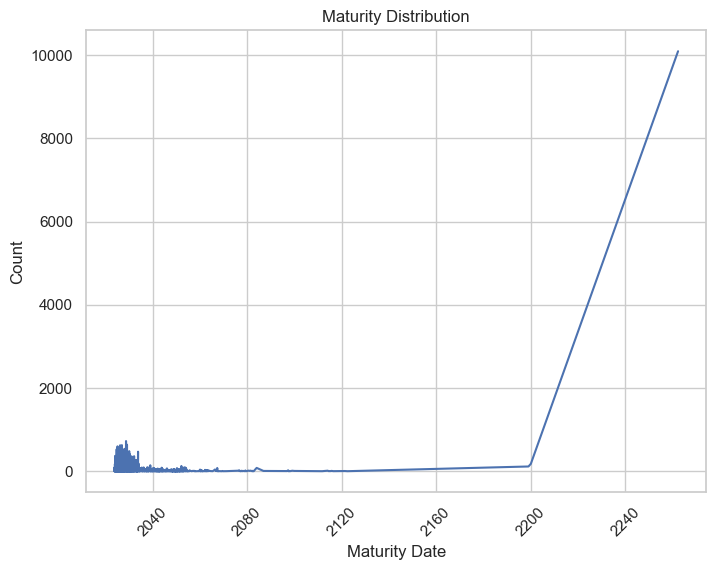

In [17]:
plt.figure(figsize=(8, 6))
perpetuities_count = (data_1['MATURITY_DATE'] >= '2262-04-11').sum()
percent_count = perpetuities_count / data_1['MATURITY_DATE'].count()

print(f'Percentage of perpetuities: {percent_count*100} %')
plt.plot(maturity_distribution.index, maturity_distribution.values)
plt.xlabel('Maturity Date')
plt.ylabel('Count')
plt.title('Maturity Distribution')
plt.xticks(rotation=45)
plt.grid(True)

Text(0.5, 1.0, 'Proportion of New Issue Bonds Trading Volume - Last Week')

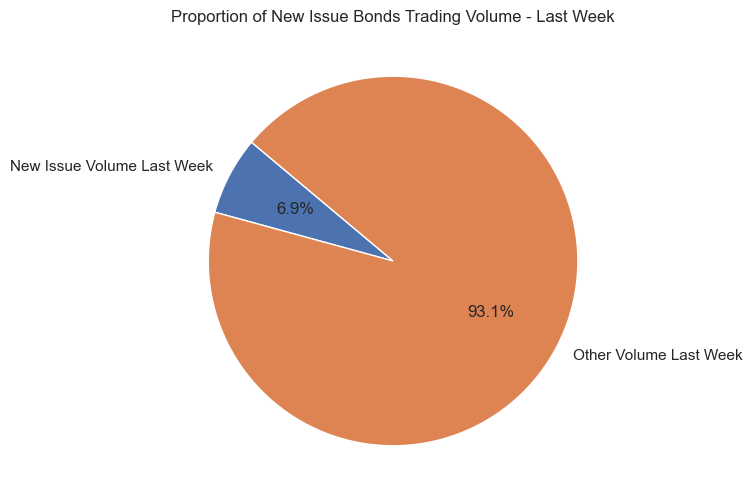

In [18]:
plt.figure(figsize=(8, 6))
plt.pie(volumes_week, labels=labels_week, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of New Issue Bonds Trading Volume - Last Week')


Text(0.5, 1.0, 'Proportion of New Issue Bonds Trading Volume - Last Month')

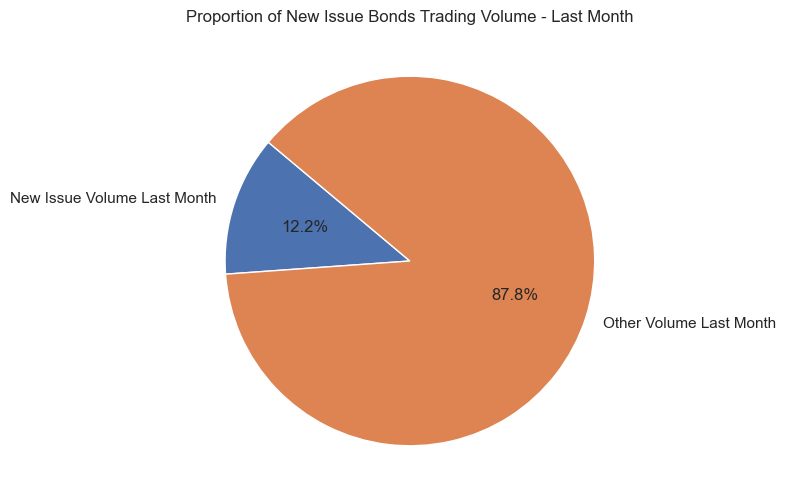

In [19]:
plt.figure(figsize=(8, 6))
plt.pie(volumes_month, labels=labels_month, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of New Issue Bonds Trading Volume - Last Month')

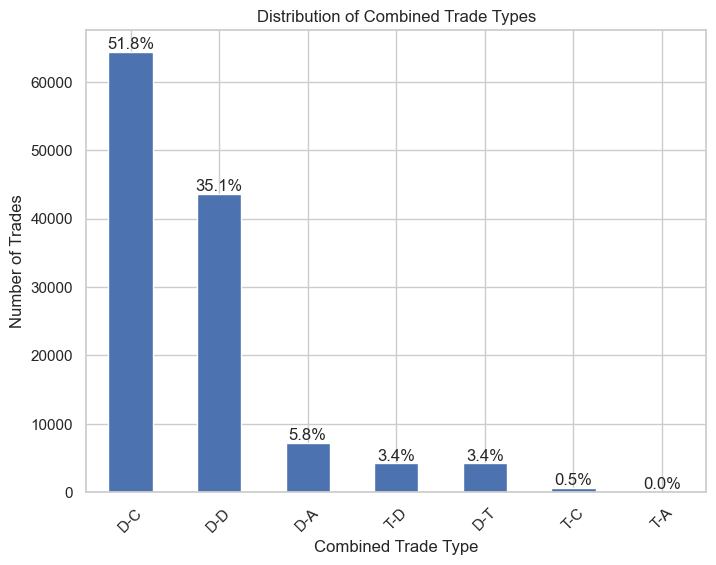

In [20]:
plt.figure(figsize=(8, 6))
trade_type_counts.plot(kind='bar')
plt.title('Distribution of Combined Trade Types')
for index, value in enumerate(trade_type_counts):
    plt.text(index, value, f'{trade_type_percentages[index]:.1f}%', ha='center', va='bottom')

plt.xlabel('Combined Trade Type')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)


total_block_volume_IG = block_trades_IG['TRADE_VOLUME'].sum()
total_block_volume_HY = block_trades_HY['TRADE_VOLUME'].sum()


non_block_trade_volume = total_volume - (total_block_volume_IG + total_block_volume_HY)


Text(0.5, 1.0, 'Distribution of Trade Volumes: IG, HY, and Non-Block Trades')

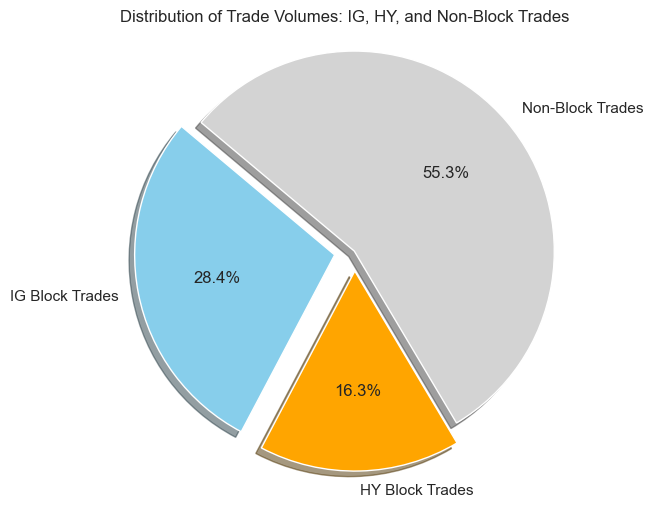

In [21]:
total_block_volume_IG = block_trades_IG['TRADE_VOLUME'].sum()
total_block_volume_HY = block_trades_HY['TRADE_VOLUME'].sum()


non_block_trade_volume = total_volume - (total_block_volume_IG + total_block_volume_HY)

plt.figure(figsize=(8, 6))
labels = ['IG Block Trades', 'HY Block Trades', 'Non-Block Trades']
sizes = [total_block_volume_IG, total_block_volume_HY, non_block_trade_volume]
colors = ['skyblue', 'orange', 'lightgrey']
explode = (0.1, 0.1, 0)  # 'Explode' both IG and HY slices

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  
plt.title('Distribution of Trade Volumes: IG, HY, and Non-Block Trades')




Weekly Summary Statistics

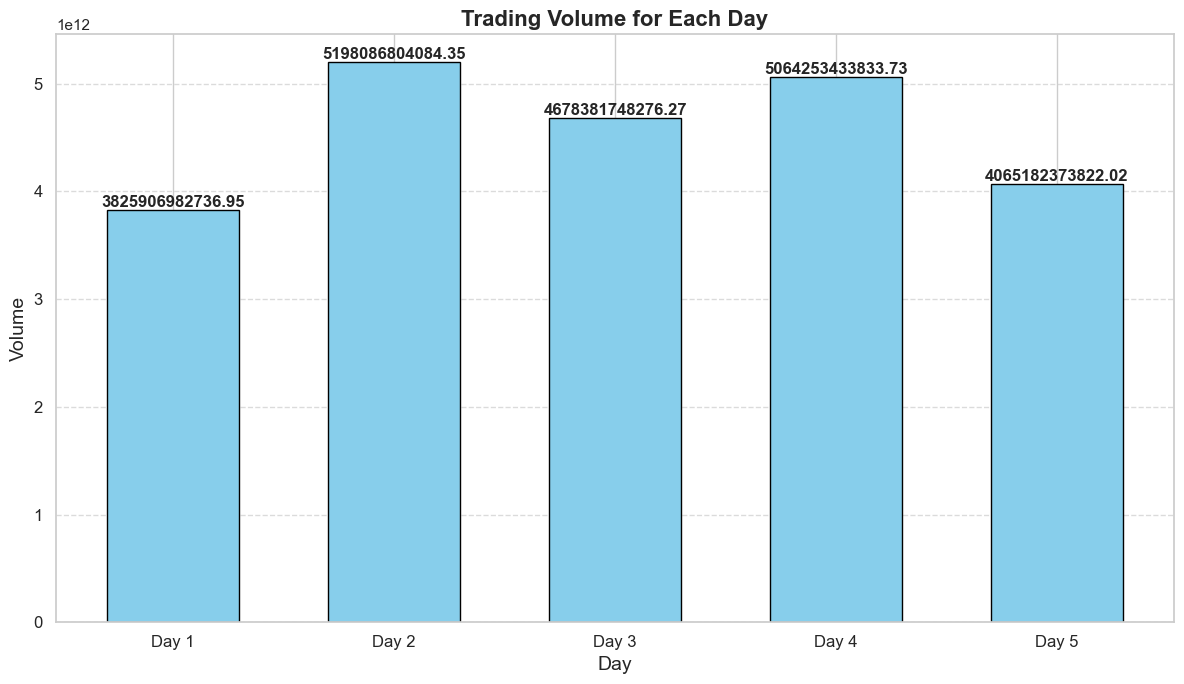

In [22]:
daily_data_frames = [data_1, data_2, data_3, data_4, data_5]  

# Initialize a list to hold the total volume for each day
daily_volumes = []

# Calculate the total volume for each day and add it to the list
for daily_data in daily_data_frames:
    daily_total_volume = daily_data['TRADE_VOLUME'].sum()
    daily_volumes.append(daily_total_volume)

# Create a single bar plot with all days' volumes
plt.figure(figsize=(12, 7))  
days = [f"Day {i}" for i in range(1, len(daily_data_frames) + 1)]
bar_width = 0.6 

bars = plt.bar(x=days, height=daily_volumes, width=bar_width, color='skyblue', edgecolor='black')

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center', fontweight='bold')

# Customize the plot
plt.title("Trading Volume for Each Day", fontsize=16, fontweight='bold')
plt.xlabel('Day', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()  
plt.show()



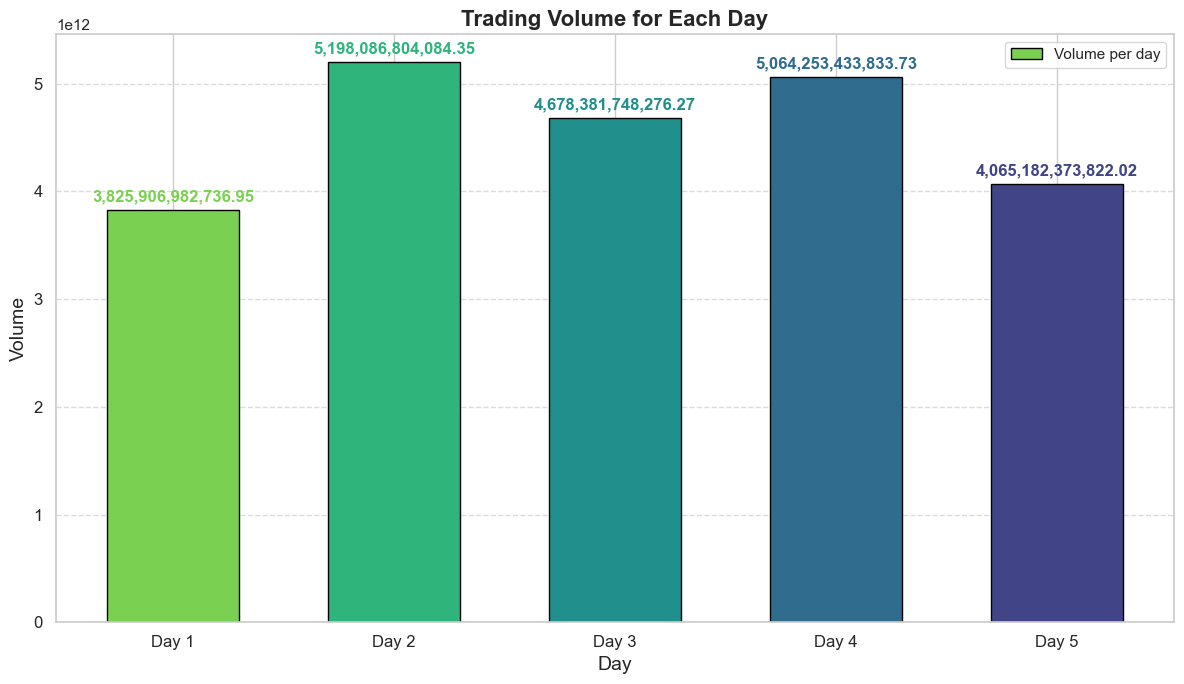

In [23]:
!pip install mplcursors
import matplotlib.pyplot as plt

daily_data_frames = [data_1, data_2, data_3, data_4, data_5]

# Initialize a list to hold the total volume for each day
daily_volumes = []

# Calculate the total volume for each day and add it to the list
for daily_data in daily_data_frames:
    daily_total_volume = daily_data['TRADE_VOLUME'].sum()
    daily_volumes.append(daily_total_volume)

# Create a single bar plot with all days' volumes
plt.figure(figsize=(12, 7)) 
days = [f"Day {i}" for i in range(1, len(daily_data_frames) + 1)]
bar_width = 0.6  

# Use a visually appealing color palette
color_palette = plt.cm.viridis_r(np.linspace(0.2, 0.8, len(daily_data_frames)))

bars = plt.bar(x=days, height=daily_volumes, width=bar_width, color=color_palette, edgecolor='black')

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels above bars
for bar, color in zip(bars, color_palette):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(daily_volumes) * 0.01, f'{round(yval, 2):,}',  # Add comma as a thousand separator
             va='bottom', ha='center', fontweight='bold', color=color)

# Customize the plot
plt.title("Trading Volume for Each Day", fontsize=16, fontweight='bold')
plt.xlabel('Day', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a custom legend to indicate data significance
plt.legend(['Volume per day'], loc='upper right')


try:
    import mplcursors
    cursor = mplcursors.cursor(hover=True)
    cursor.connect("add", lambda sel: sel.annotation.set_text(f'Day {sel.target.index + 1}: {daily_volumes[sel.target.index]:,.2f}'))
except ImportError:
    print("mplcursors not installed. Hover effects not enabled.")

# Show the plot with an optimized layout
plt.tight_layout()
plt.show()


Duplication of Trades (only D2C and D2D trades)

In [24]:
import pandas as pd

#Data_1
filtered_data_1 = data_1[data_1['CombinedTradeType'].isin(['D-C', 'D-D'])]

# Identifying duplicates
duplicates = filtered_data_1[filtered_data_1.duplicated(subset=['PRICE', 'ASSUMED_QUANTITY', 'TRADE_DATETIME','CUSIP'], keep=False)]

# Analyzing duplicates
duplicate_volume = duplicates['TRADE_VOLUME'].sum()
duplicate_count = len(duplicates)

# Calculate percentages of total volume and count
total_volume = filtered_data_1['TRADE_VOLUME'].sum()
total_count = len(filtered_data_1)

# Calculate true volume (total volume minus duplicate volume)
true_volume = total_volume - duplicate_volume

# Calculate true volume percentage
true_volume_percentage_1 = (true_volume / total_volume) * 100


#Data_2
filtered_data_2 = data_2[data_2['CombinedTradeType'].isin(['D-C', 'D-D'])]

# Identifying duplicates
duplicates = filtered_data_2[filtered_data_2.duplicated(subset=['PRICE', 'ASSUMED_QUANTITY', 'TRADE_DATETIME','CUSIP'], keep=False)]

# Analyzing duplicates
duplicate_volume = duplicates['TRADE_VOLUME'].sum()
duplicate_count = len(duplicates)

# Calculate percentages of total volume and count
total_volume = filtered_data_2['TRADE_VOLUME'].sum()
total_count = len(filtered_data_2)

# Calculate true volume (total volume minus duplicate volume)
true_volume = total_volume - duplicate_volume

# Calculate true volume percentage
true_volume_percentage_2 = (true_volume / total_volume) * 100


#Data_3
filtered_data_3 = data_3[data_3['CombinedTradeType'].isin(['D-C', 'D-D'])]

# Identifying duplicates
duplicates = filtered_data_3[filtered_data_3.duplicated(subset=['PRICE', 'ASSUMED_QUANTITY', 'TRADE_DATETIME','CUSIP'], keep=False)]

# Analyzing duplicates
duplicate_volume = duplicates['TRADE_VOLUME'].sum()
duplicate_count = len(duplicates)

# Calculate percentages of total volume and count
total_volume = filtered_data_3['TRADE_VOLUME'].sum()
total_count = len(filtered_data_3)

# Calculate true volume (total volume minus duplicate volume)
true_volume = total_volume - duplicate_volume

# Calculate true volume percentage
true_volume_percentage_3 = (true_volume / total_volume) * 100


#Data_4
filtered_data_4 = data_4[data_4['CombinedTradeType'].isin(['D-C', 'D-D'])]

# Identifying duplicates
duplicates = filtered_data_4[filtered_data_4.duplicated(subset=['PRICE', 'ASSUMED_QUANTITY', 'TRADE_DATETIME','CUSIP'], keep=False)]

# Analyzing duplicates
duplicate_volume = duplicates['TRADE_VOLUME'].sum()
duplicate_count = len(duplicates)

# Calculate percentages of total volume and count
total_volume = filtered_data_4['TRADE_VOLUME'].sum()
total_count = len(filtered_data_4)

# Calculate true volume (total volume minus duplicate volume)
true_volume = total_volume - duplicate_volume

# Calculate true volume percentage
true_volume_percentage_4 = (true_volume / total_volume) * 100



#Data_5
filtered_data_5 = data_5[data_5['CombinedTradeType'].isin(['D-C', 'D-D'])]

# Identifying duplicates
duplicates = filtered_data_5[filtered_data_5.duplicated(subset=['PRICE', 'ASSUMED_QUANTITY', 'TRADE_DATETIME','CUSIP'], keep=False)]

# Analyzing duplicates
duplicate_volume = duplicates['TRADE_VOLUME'].sum()
duplicate_count = len(duplicates)

# Calculate percentages of total volume and count
total_volume = filtered_data_5['TRADE_VOLUME'].sum()
total_count = len(filtered_data_5)

# Calculate true volume (total volume minus duplicate volume)
true_volume = total_volume - duplicate_volume

# Calculate true volume percentage
true_volume_percentage_5 = (true_volume / total_volume) * 100



# Print the result
print(f"The true volume, after accounting for duplicates, is {true_volume_percentage_1:.2f}% of the total volume.")
print(f"The true volume, after accounting for duplicates, is {true_volume_percentage_2:.2f}% of the total volume.")
print(f"The true volume, after accounting for duplicates, is {true_volume_percentage_3:.2f}% of the total volume.")
print(f"The true volume, after accounting for duplicates, is {true_volume_percentage_4:.2f}% of the total volume.")
print(f"The true volume, after accounting for duplicates, is {true_volume_percentage_5:.2f}% of the total volume.")

The true volume, after accounting for duplicates, is 93.66% of the total volume.
The true volume, after accounting for duplicates, is 93.55% of the total volume.
The true volume, after accounting for duplicates, is 92.25% of the total volume.
The true volume, after accounting for duplicates, is 93.00% of the total volume.
The true volume, after accounting for duplicates, is 88.57% of the total volume.


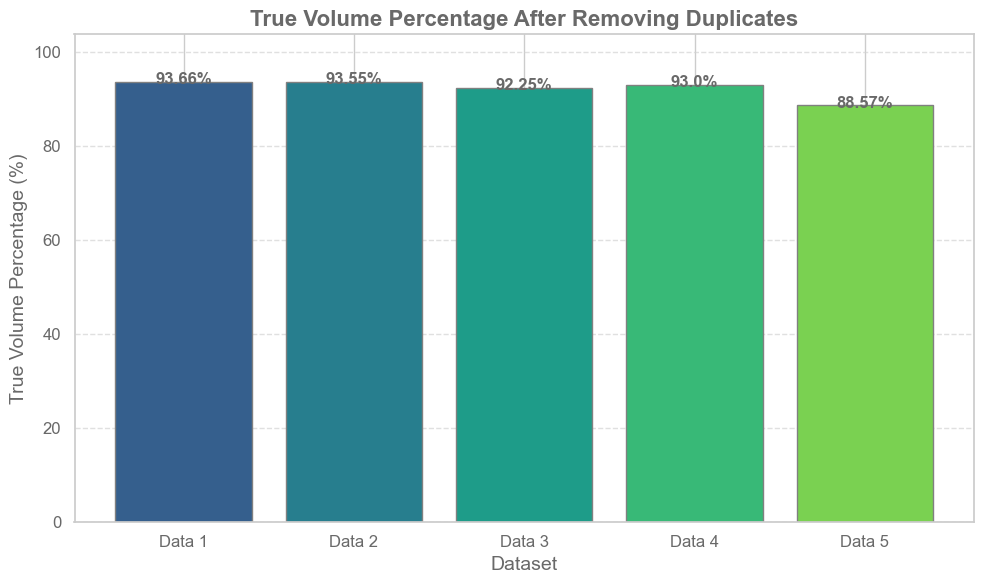

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# True volume percentages for each dataset
true_volume_percentages = [true_volume_percentage_1, true_volume_percentage_2, true_volume_percentage_3, true_volume_percentage_4, true_volume_percentage_5]
datasets = ['Data 1', 'Data 2', 'Data 3', 'Data 4', 'Data 5']

plt.figure(figsize=(10, 6))

# Use a visually appealing color palette
colors = plt.cm.viridis(np.linspace(0.3, 0.8, len(datasets)))

bars = plt.bar(datasets, true_volume_percentages, color=colors, edgecolor='grey')

# Add text labels above bars with proper formatting and offsets
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{round(yval, 2)}%',  # Add '%' and round off the value
             va='center', ha='center', fontweight='bold', color='dimgrey')

# Customize the plot
plt.title('True Volume Percentage After Removing Duplicates', fontsize=16, fontweight='bold', color='dimgrey')
plt.xlabel('Dataset', fontsize=14, color='dimgrey')
plt.ylabel('True Volume Percentage (%)', fontsize=14, color='dimgrey')
plt.xticks(fontsize=12, color='dimgrey')
plt.yticks(fontsize=12, color='dimgrey')
plt.ylim(0, max(true_volume_percentages) + 10)  # Adjust the y-axis limit to make room for labels

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7, color='lightgrey')

# Show the plot
plt.tight_layout()
plt.show()



Multi-legged Trades Analysis

In [26]:
# Rounding trade time to nearest time window
time_window = '5T'  
filtered_data_1['RoundedTime'] = filtered_data_1['TRADE_DATETIME'].dt.round(time_window)

# Group by 'TRADE_VOLUME' and 'RoundedTime'
grouped = filtered_data_1.groupby(['RoundedTime','ASSUMED_QUANTITY','CUSIP'])

# Function to identify multi-legged trades
def find_multi_legged(group):
    if len(group['PRICE'].unique()) > 1: 
        return group
    return None

# Apply the function to the grouped data
multi_legged_trades = grouped.apply(find_multi_legged).dropna().reset_index(drop=True)

# Counting the number of multi-legged trades
num_multi_legged_trades = len(multi_legged_trades)

# Assessing volume impact
total_volume_multi_legged_1= multi_legged_trades['TRADE_VOLUME'].sum()
total_volume_all = filtered_data_1['TRADE_VOLUME'].sum()
percentage_volume_multi_legged = (total_volume_multi_legged_1 / total_volume_all) * 100
print(f"Number of Multi-legged Trades: {num_multi_legged_trades}")
print(f"Percentage of Total Volume in Multi-legged Trades: {percentage_volume_multi_legged}%")

# Count the occurrences of each direction in multi-legged trades
direction_counts = multi_legged_trades['CombinedTradeType'].value_counts()
print("Direction Counts in Multi-Legged Trades:")
print(direction_counts)

# Calculate the time difference between consecutive trades within each multi-legged group
multi_legged_trades['TRADE_DATETIME'] = pd.to_datetime(multi_legged_trades['TRADE_DATETIME'])
multi_legged_trades['TimeLag'] = multi_legged_trades.sort_values('TRADE_DATETIME').groupby(['TRADE_VOLUME', 'RoundedTime'])['TRADE_DATETIME'].diff()

# Calculate descriptive statistics for time lags
time_lag_descriptive_stats = multi_legged_trades['TimeLag'].describe()
print("Time Lag Descriptive Statistics:")
print(time_lag_descriptive_stats)

# Handle time lags for more than two legs
multi_legged_trades['TimeLagSeconds'] = multi_legged_trades['TimeLag'].dt.total_seconds()
average_time_lag_per_group = multi_legged_trades.groupby(['TRADE_VOLUME', 'RoundedTime'])['TimeLagSeconds'].mean()

# Print average time lag per group
print("Average Time Lag per Group:")
print(average_time_lag_per_group)




/var/folders/hp/_b6xsbmj35l1y01h13czdks80000gn/T/ipykernel_27115/2356242918.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_1['RoundedTime'] = filtered_data_1['TRADE_DATETIME'].dt.round(time_window)


Number of Multi-legged Trades: 35607
Percentage of Total Volume in Multi-legged Trades: 19.526322557507406%
Direction Counts in Multi-Legged Trades:
D-D    21488
D-C    14119
Name: CombinedTradeType, dtype: int64
Time Lag Descriptive Statistics:
count                         3188
mean     0 days 00:00:02.624843161
std      0 days 00:00:15.179661557
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                0 days 00:00:00
max                0 days 00:04:16
Name: TimeLag, dtype: object
Average Time Lag per Group:
TRADE_VOLUME  RoundedTime        
1.732500e+04  2023-11-13 08:05:00    NaN
1.750000e+04  2023-11-13 08:05:00    NaN
2.970000e+04  2023-11-13 10:35:00    NaN
3.000000e+04  2023-11-13 10:35:00    NaN
3.729500e+04  2023-11-13 08:45:00    0.0
                                    ... 
1.207957e+09  2023-11-13 13:40:00    NaN
1.209341e+09  2023-11-13 14:00:00    NaN
1.210080e+09  2023-11-13 14:00:00    NaN
1.211229e+09  

In [27]:
pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


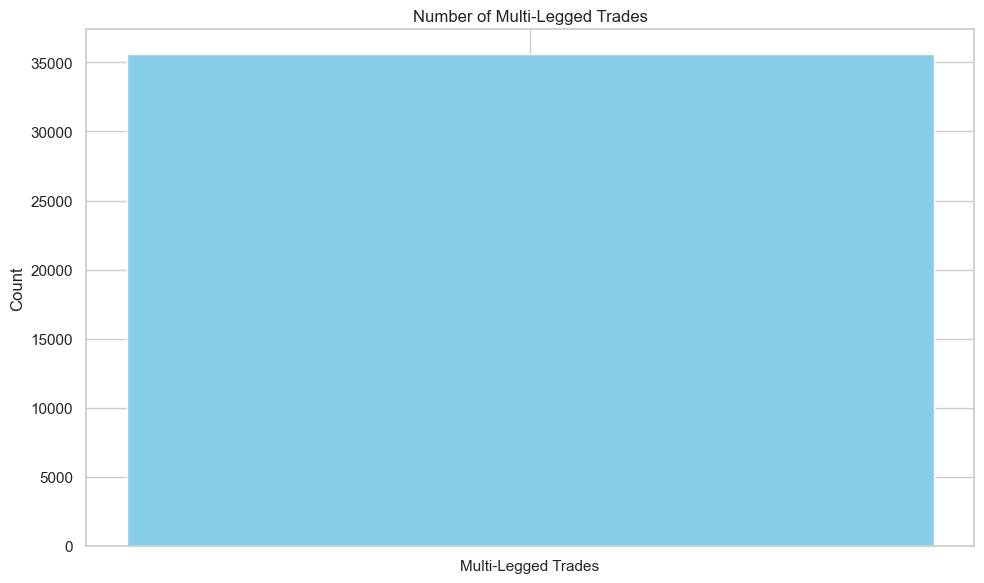

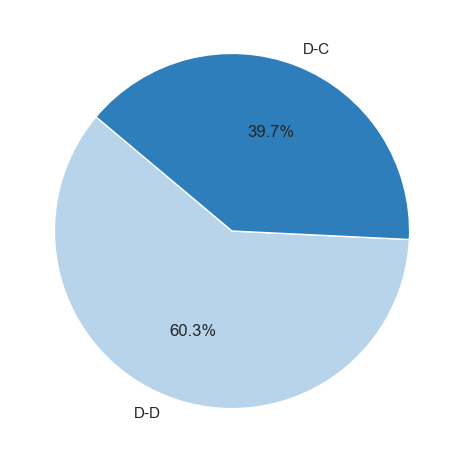

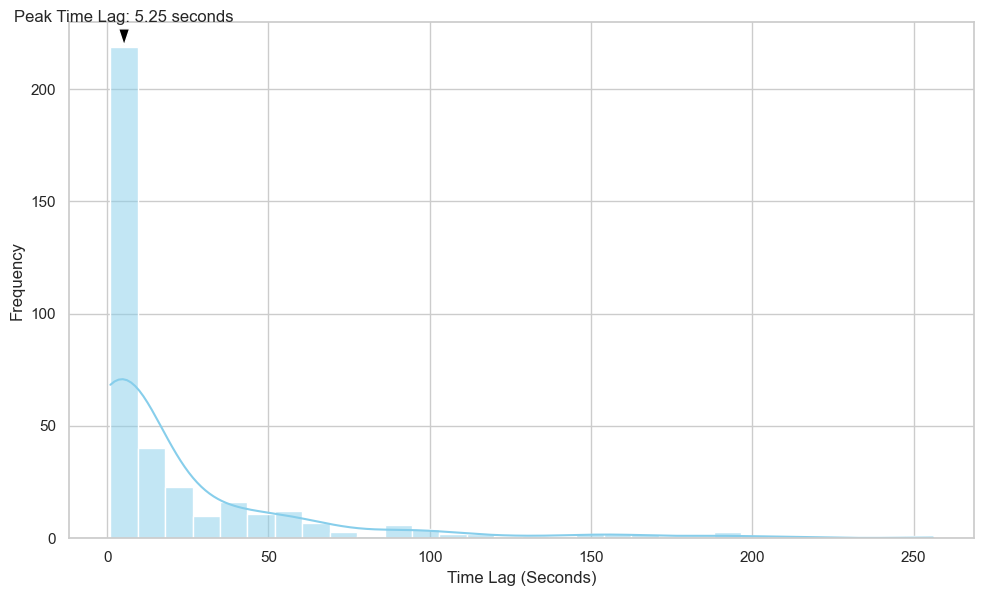

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Bar Chart of the Number of Multi-Legged Trades
plt.figure(figsize=(10, 6))
plt.bar(['Multi-Legged Trades'], [num_multi_legged_trades], color='skyblue')
plt.title('Number of Multi-Legged Trades')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2. Pie Chart of Trade Direction Counts with a blue series
colors = plt.cm.Blues(np.linspace(0.3, 0.7, len(direction_counts)))  # Generating a blue color series
direction_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=colors)
#plt.title('Trade Direction Distribution in Multi-Legged Trades')
plt.ylabel('')  # This removes the 'CombinedTradeType' label on the y-axis
plt.tight_layout()
plt.show()

# 3. Histogram of Time Lags
multi_legged_trades['TimeLagSeconds'] = multi_legged_trades['TimeLag'].dt.total_seconds()

# Remove NaN values and values equal to 0 (which are not actual lags)
time_lags = multi_legged_trades['TimeLagSeconds'].dropna()
time_lags = time_lags[time_lags > 0]

plt.figure(figsize=(10, 6))

# Plotting the histogram with Seaborn
hist_plot = sns.histplot(time_lags, kde=True, color='skyblue', bins=30)
#plt.title('Distribution of Time Lags in Multi-Legged Trades')
plt.xlabel('Time Lag (Seconds)')
plt.ylabel('Frequency')
plt.tight_layout()

# Calculating histogram data for peak annotation
counts, bin_edges = np.histogram(time_lags, bins=30)
max_count_index = np.argmax(counts)  # Index of the bin with the highest count
peak_bin_center = (bin_edges[max_count_index] + bin_edges[max_count_index + 1]) / 2  # Center of the peak bin

# Annotating the peak with the time lag (x-axis value)
plt.annotate(f'Peak Time Lag: {peak_bin_center:.2f} seconds', 
             xy=(peak_bin_center, counts[max_count_index]), 
             xytext=(peak_bin_center, counts[max_count_index] + 0.05 * counts[max_count_index]),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             ha='center')

plt.show()

In [29]:
# Rounding trade time to nearest time window
time_window = '5T' 
filtered_data_2['RoundedTime'] = filtered_data_2['TRADE_DATETIME'].dt.round(time_window)

# Group by 'TRADE_VOLUME' and 'RoundedTime'
grouped = filtered_data_2.groupby(['RoundedTime','ASSUMED_QUANTITY','CUSIP'])

# Function to identify multi-legged trades
def find_multi_legged(group):
    if len(group['PRICE'].unique()) > 1:  
        return group
    return None

# Apply the function to the grouped data
multi_legged_trades = grouped.apply(find_multi_legged).dropna().reset_index(drop=True)

# Counting the number of multi-legged trades
num_multi_legged_trades = len(multi_legged_trades)

# Assessing volume impact
total_volume_multi_legged_2 = multi_legged_trades['TRADE_VOLUME'].sum()
total_volume_all = filtered_data_2['TRADE_VOLUME'].sum()
percentage_volume_multi_legged = (total_volume_multi_legged_2 / total_volume_all) * 100
print(f"Number of Multi-legged Trades: {num_multi_legged_trades}")
print(f"Percentage of Total Volume in Multi-legged Trades: {percentage_volume_multi_legged}%")

# Count the occurrences of each direction in multi-legged trades
direction_counts = multi_legged_trades['CombinedTradeType'].value_counts()
print("Direction Counts in Multi-Legged Trades:")
print(direction_counts)

# Calculate the time difference between consecutive trades within each multi-legged group
multi_legged_trades['TRADE_DATETIME'] = pd.to_datetime(multi_legged_trades['TRADE_DATETIME'])
multi_legged_trades['TimeLag'] = multi_legged_trades.sort_values('TRADE_DATETIME').groupby(['TRADE_VOLUME', 'RoundedTime'])['TRADE_DATETIME'].diff()

# Calculate descriptive statistics for time lags
time_lag_descriptive_stats = multi_legged_trades['TimeLag'].describe()
print("Time Lag Descriptive Statistics:")
print(time_lag_descriptive_stats)

# Handle time lags for more than two legs
multi_legged_trades['TimeLagSeconds'] = multi_legged_trades['TimeLag'].dt.total_seconds()
average_time_lag_per_group = multi_legged_trades.groupby(['TRADE_VOLUME', 'RoundedTime'])['TimeLagSeconds'].mean()

# Print average time lag per group
print("Average Time Lag per Group:")
print(average_time_lag_per_group)



/var/folders/hp/_b6xsbmj35l1y01h13czdks80000gn/T/ipykernel_27115/1521422523.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_2['RoundedTime'] = filtered_data_2['TRADE_DATETIME'].dt.round(time_window)


Number of Multi-legged Trades: 42665
Percentage of Total Volume in Multi-legged Trades: 24.04024742474206%
Direction Counts in Multi-Legged Trades:
D-D    25766
D-C    16899
Name: CombinedTradeType, dtype: int64
Time Lag Descriptive Statistics:
count                         3614
mean     0 days 00:00:03.588544548
std      0 days 00:00:19.506215277
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                0 days 00:00:00
max                0 days 00:04:01
Name: TimeLag, dtype: object
Average Time Lag per Group:
TRADE_VOLUME  RoundedTime        
2.900000e+04  2023-11-14 11:00:00    NaN
3.000000e+04  2023-11-14 11:00:00    NaN
3.470000e+04  2023-11-14 13:40:00    NaN
3.570000e+04  2023-11-14 13:40:00    1.0
3.580000e+04  2023-11-14 13:40:00    NaN
                                    ... 
1.213257e+09  2023-11-14 09:20:00    NaN
1.371030e+09  2023-11-14 09:10:00    NaN
1.373117e+09  2023-11-14 09:10:00    NaN
1.374747e+09  2

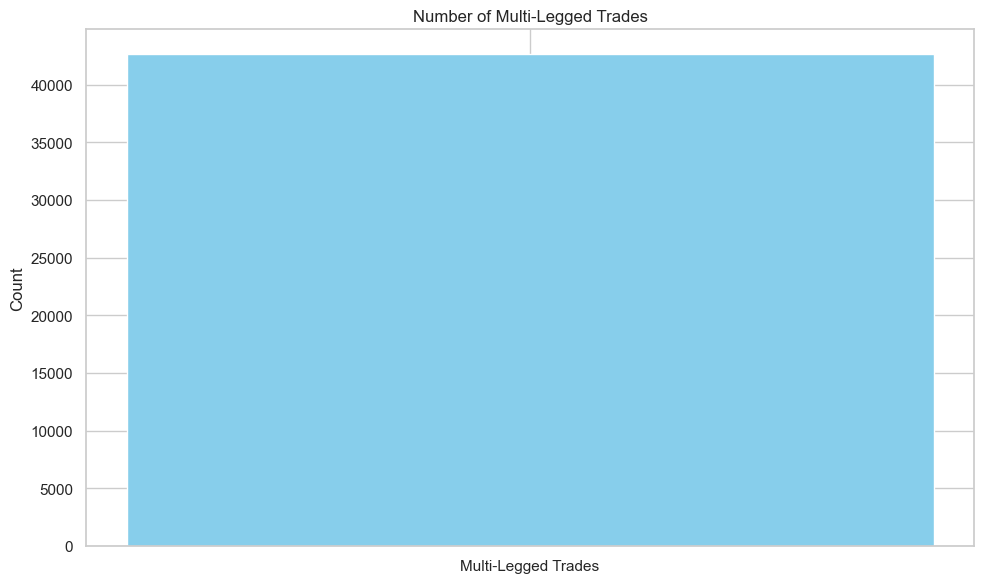

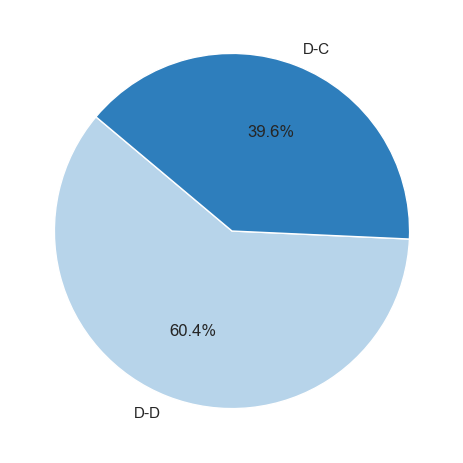

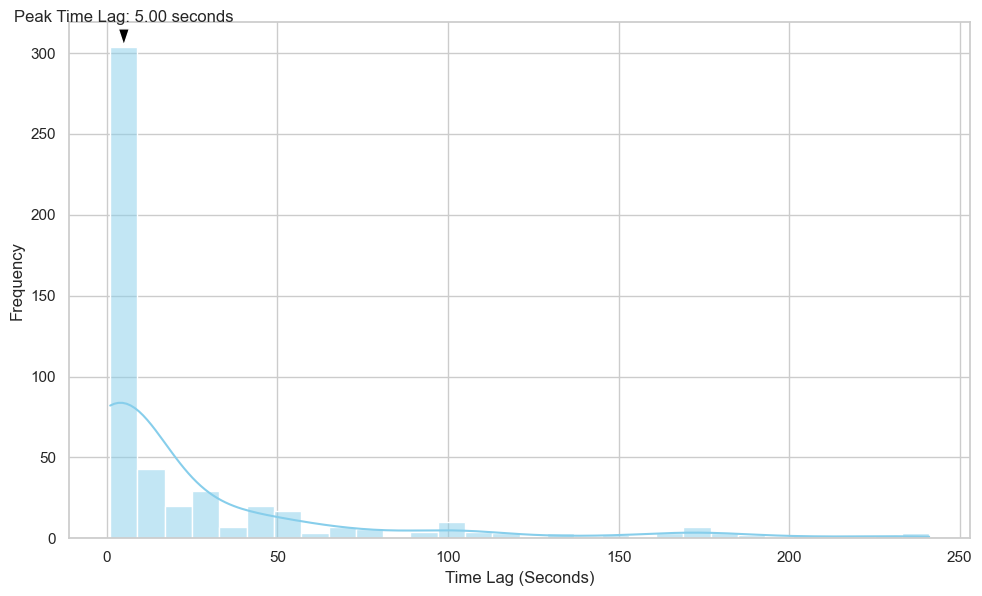

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Bar Chart of the Number of Multi-Legged Trades
plt.figure(figsize=(10, 6))
plt.bar(['Multi-Legged Trades'], [num_multi_legged_trades], color='skyblue')
plt.title('Number of Multi-Legged Trades')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2. Pie Chart of Trade Direction Counts with a blue series
colors = plt.cm.Blues(np.linspace(0.3, 0.7, len(direction_counts)))  # Generating a blue color series
direction_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=colors)
#plt.title('Trade Direction Distribution in Multi-Legged Trades')
plt.ylabel('')  # This removes the 'CombinedTradeType' label on the y-axis
plt.tight_layout()
plt.show()

# 3. Histogram of Time Lags
multi_legged_trades['TimeLagSeconds'] = multi_legged_trades['TimeLag'].dt.total_seconds()

# Remove NaN values and values equal to 0 (which are not actual lags)
time_lags = multi_legged_trades['TimeLagSeconds'].dropna()
time_lags = time_lags[time_lags > 0]

plt.figure(figsize=(10, 6))

# Plotting the histogram with Seaborn
hist_plot = sns.histplot(time_lags, kde=True, color='skyblue', bins=30)
#plt.title('Distribution of Time Lags in Multi-Legged Trades')
plt.xlabel('Time Lag (Seconds)')
plt.ylabel('Frequency')
plt.tight_layout()

# Calculating histogram data for peak annotation
counts, bin_edges = np.histogram(time_lags, bins=30)
max_count_index = np.argmax(counts)  # Index of the bin with the highest count
peak_bin_center = (bin_edges[max_count_index] + bin_edges[max_count_index + 1]) / 2  # Center of the peak bin

# Annotating the peak with the time lag (x-axis value)
plt.annotate(f'Peak Time Lag: {peak_bin_center:.2f} seconds', 
             xy=(peak_bin_center, counts[max_count_index]), 
             xytext=(peak_bin_center, counts[max_count_index] + 0.05 * counts[max_count_index]),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             ha='center')

plt.show()

In [31]:
# Rounding trade time to nearest time window
time_window = '5T'
filtered_data_3['RoundedTime'] = filtered_data_3['TRADE_DATETIME'].dt.round(time_window)

# Group by 'TRADE_VOLUME' and 'RoundedTime'
grouped = filtered_data_3.groupby(['RoundedTime','ASSUMED_QUANTITY','CUSIP'])

# Function to identify multi-legged trades
def find_multi_legged(group):
    if len(group['PRICE'].unique()) > 1:  # Check if there are trades with different prices
        return group
    return None

# Apply the function to the grouped data
multi_legged_trades = grouped.apply(find_multi_legged).dropna().reset_index(drop=True)

# Counting the number of multi-legged trades
num_multi_legged_trades = len(multi_legged_trades)

# Assessing volume impact
total_volume_multi_legged_3 = multi_legged_trades['TRADE_VOLUME'].sum()
total_volume_all = filtered_data_3['TRADE_VOLUME'].sum()
percentage_volume_multi_legged = (total_volume_multi_legged_3/ total_volume_all) * 100
print(f"Number of Multi-legged Trades: {num_multi_legged_trades}")
print(f"Percentage of Total Volume in Multi-legged Trades: {percentage_volume_multi_legged}%")

# Count the occurrences of each direction in multi-legged trades
direction_counts = multi_legged_trades['CombinedTradeType'].value_counts()
print("Direction Counts in Multi-Legged Trades:")
print(direction_counts)

# Calculate the time difference between consecutive trades within each multi-legged group
multi_legged_trades['TRADE_DATETIME'] = pd.to_datetime(multi_legged_trades['TRADE_DATETIME'])
multi_legged_trades['TimeLag'] = multi_legged_trades.sort_values('TRADE_DATETIME').groupby(['TRADE_VOLUME', 'RoundedTime'])['TRADE_DATETIME'].diff()

# Calculate descriptive statistics for time lags
time_lag_descriptive_stats = multi_legged_trades['TimeLag'].describe()
print("Time Lag Descriptive Statistics:")
print(time_lag_descriptive_stats)

# Handle time lags for more than two legs
multi_legged_trades['TimeLagSeconds'] = multi_legged_trades['TimeLag'].dt.total_seconds()
average_time_lag_per_group = multi_legged_trades.groupby(['TRADE_VOLUME', 'RoundedTime'])['TimeLagSeconds'].mean()

# Print average time lag per group
print("Average Time Lag per Group:")
print(average_time_lag_per_group)


/var/folders/hp/_b6xsbmj35l1y01h13czdks80000gn/T/ipykernel_27115/1091256879.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_3['RoundedTime'] = filtered_data_3['TRADE_DATETIME'].dt.round(time_window)


Number of Multi-legged Trades: 47029
Percentage of Total Volume in Multi-legged Trades: 21.366076162585227%
Direction Counts in Multi-Legged Trades:
D-D    27711
D-C    19318
Name: CombinedTradeType, dtype: int64
Time Lag Descriptive Statistics:
count                         4792
mean     0 days 00:00:03.701168614
std      0 days 00:00:19.208715720
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                0 days 00:00:00
max                0 days 00:03:57
Name: TimeLag, dtype: object
Average Time Lag per Group:
TRADE_VOLUME  RoundedTime        
1.470200e+04  2023-11-15 13:30:00   NaN
1.485000e+04  2023-11-15 13:30:00   NaN
3.490000e+04  2023-11-15 08:30:00   NaN
3.500000e+04  2023-11-15 08:30:00   NaN
3.510000e+04  2023-11-15 08:30:00   NaN
                                     ..
1.219003e+09  2023-11-15 12:05:00   NaN
1.227692e+09  2023-11-15 11:50:00   NaN
1.228431e+09  2023-11-15 11:50:00   NaN
1.239312e+09  2023-11-1

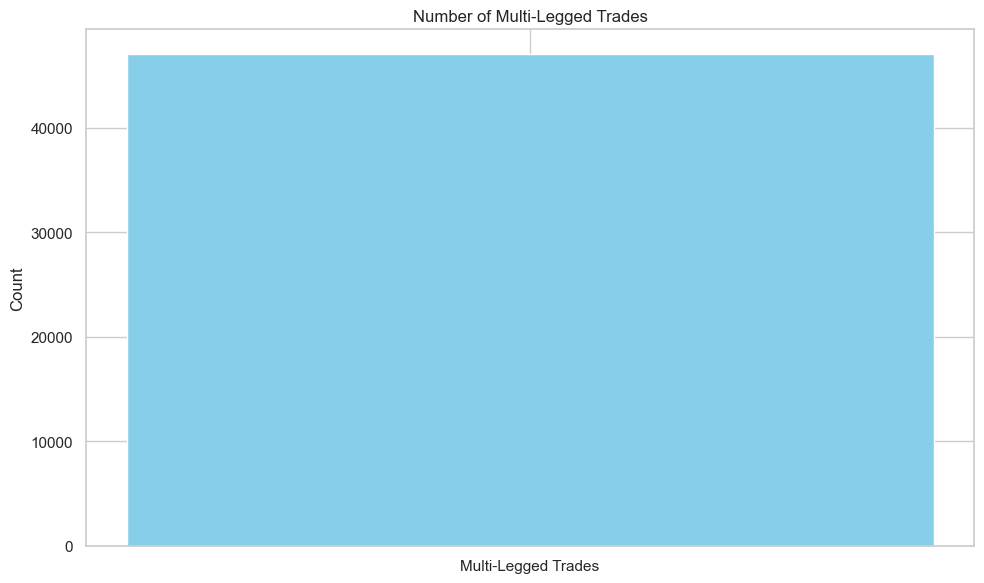

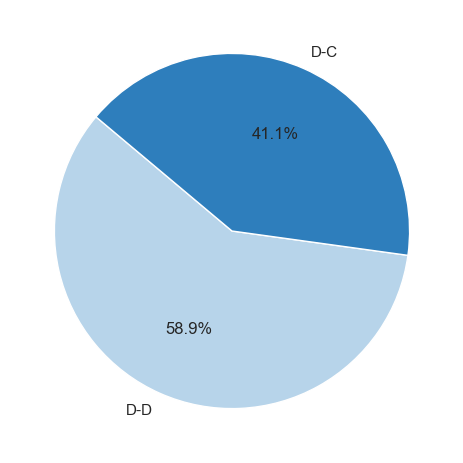

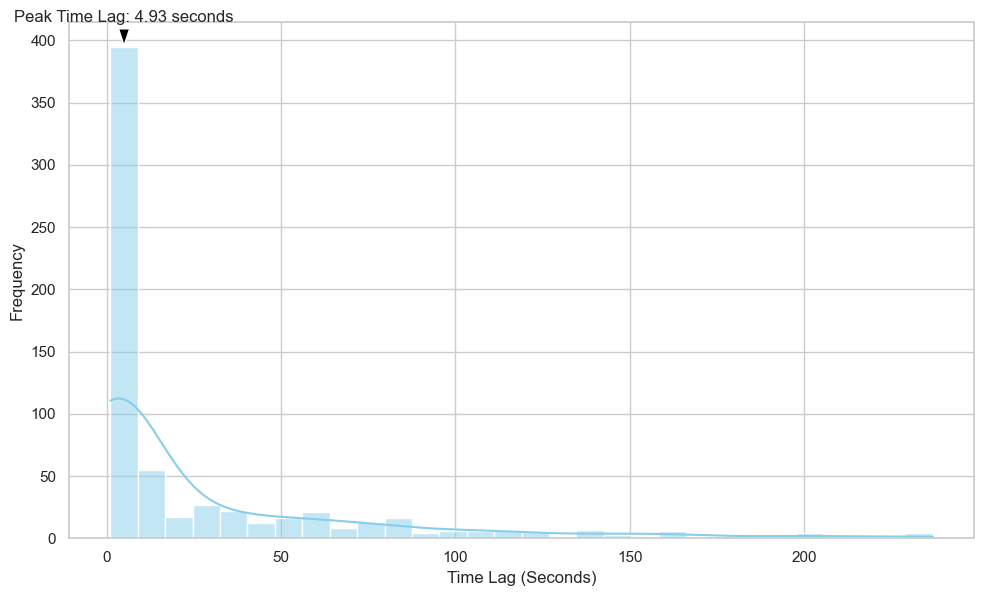

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Bar Chart of the Number of Multi-Legged Trades
plt.figure(figsize=(10, 6))
plt.bar(['Multi-Legged Trades'], [num_multi_legged_trades], color='skyblue')
plt.title('Number of Multi-Legged Trades')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2. Pie Chart of Trade Direction Counts with a blue series
colors = plt.cm.Blues(np.linspace(0.3, 0.7, len(direction_counts)))  # Generating a blue color series
direction_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=colors)
#plt.title('Trade Direction Distribution in Multi-Legged Trades')
plt.ylabel('')  # This removes the 'CombinedTradeType' label on the y-axis
plt.tight_layout()
plt.show()

# 3. Histogram of Time Lags
multi_legged_trades['TimeLagSeconds'] = multi_legged_trades['TimeLag'].dt.total_seconds()

# Remove NaN values and values equal to 0 (which are not actual lags)
time_lags = multi_legged_trades['TimeLagSeconds'].dropna()
time_lags = time_lags[time_lags > 0]

plt.figure(figsize=(10, 6))

# Plotting the histogram with Seaborn
hist_plot = sns.histplot(time_lags, kde=True, color='skyblue', bins=30)
#plt.title('Distribution of Time Lags in Multi-Legged Trades')
plt.xlabel('Time Lag (Seconds)')
plt.ylabel('Frequency')
plt.tight_layout()

# Calculating histogram data for peak annotation
counts, bin_edges = np.histogram(time_lags, bins=30)
max_count_index = np.argmax(counts)  # Index of the bin with the highest count
peak_bin_center = (bin_edges[max_count_index] + bin_edges[max_count_index + 1]) / 2  # Center of the peak bin

# Annotating the peak with the time lag (x-axis value)
plt.annotate(f'Peak Time Lag: {peak_bin_center:.2f} seconds', 
             xy=(peak_bin_center, counts[max_count_index]), 
             xytext=(peak_bin_center, counts[max_count_index] + 0.05 * counts[max_count_index]),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             ha='center')

plt.show()

In [33]:
time_window = '5T'  
filtered_data_4['RoundedTime'] = filtered_data_4['TRADE_DATETIME'].dt.round(time_window)

# Group by 'TRADE_VOLUME' and 'RoundedTime'
grouped = filtered_data_4.groupby(['RoundedTime','ASSUMED_QUANTITY','CUSIP'])

# Function to identify multi-legged trades
def find_multi_legged(group):
    if len(group['PRICE'].unique()) > 1:  
        return group
    return None

# Apply the function to the grouped data
multi_legged_trades = grouped.apply(find_multi_legged).dropna().reset_index(drop=True)

# Counting the number of multi-legged trades
num_multi_legged_trades = len(multi_legged_trades)

# Assessing volume impact
total_volume_multi_legged_4 = multi_legged_trades['TRADE_VOLUME'].sum()
total_volume_all = filtered_data_4['TRADE_VOLUME'].sum()
percentage_volume_multi_legged = (total_volume_multi_legged_4 / total_volume_all) * 100
print(f"Number of Multi-legged Trades: {num_multi_legged_trades}")
print(f"Percentage of Total Volume in Multi-legged Trades: {percentage_volume_multi_legged}%")

# Count the occurrences of each direction in multi-legged trades
direction_counts = multi_legged_trades['CombinedTradeType'].value_counts()
print("Direction Counts in Multi-Legged Trades:")
print(direction_counts)

# Calculate the time difference between consecutive trades within each multi-legged group
multi_legged_trades['TRADE_DATETIME'] = pd.to_datetime(multi_legged_trades['TRADE_DATETIME'])
multi_legged_trades['TimeLag'] = multi_legged_trades.sort_values('TRADE_DATETIME').groupby(['TRADE_VOLUME', 'RoundedTime'])['TRADE_DATETIME'].diff()

# Calculate descriptive statistics for time lags
time_lag_descriptive_stats = multi_legged_trades['TimeLag'].describe()
print("Time Lag Descriptive Statistics:")
print(time_lag_descriptive_stats)

# Handle time lags for more than two legs
multi_legged_trades['TimeLagSeconds'] = multi_legged_trades['TimeLag'].dt.total_seconds()
average_time_lag_per_group = multi_legged_trades.groupby(['TRADE_VOLUME', 'RoundedTime'])['TimeLagSeconds'].mean()

# Print average time lag per group
print("Average Time Lag per Group:")
print(average_time_lag_per_group)




/var/folders/hp/_b6xsbmj35l1y01h13czdks80000gn/T/ipykernel_27115/1013501764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_4['RoundedTime'] = filtered_data_4['TRADE_DATETIME'].dt.round(time_window)


Number of Multi-legged Trades: 41966
Percentage of Total Volume in Multi-legged Trades: 18.726263960092517%
Direction Counts in Multi-Legged Trades:
D-D    24527
D-C    17439
Name: CombinedTradeType, dtype: int64
Time Lag Descriptive Statistics:
count                         4099
mean     0 days 00:00:04.122956818
std      0 days 00:00:21.621550973
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                0 days 00:00:00
max                0 days 00:04:39
Name: TimeLag, dtype: object
Average Time Lag per Group:
TRADE_VOLUME  RoundedTime        
6.150000e+03  2023-11-16 12:55:00   NaN
6.250000e+03  2023-11-16 12:55:00   NaN
8.649998e+03  2023-11-16 13:00:00   NaN
8.750000e+03  2023-11-16 13:00:00   NaN
1.485000e+04  2023-11-16 13:55:00   NaN
                                     ..
1.224327e+09  2023-11-16 07:40:00   NaN
1.289699e+09  2023-11-16 10:45:00   NaN
1.290437e+09  2023-11-16 10:45:00   NaN
1.390706e+09  2023-11-1

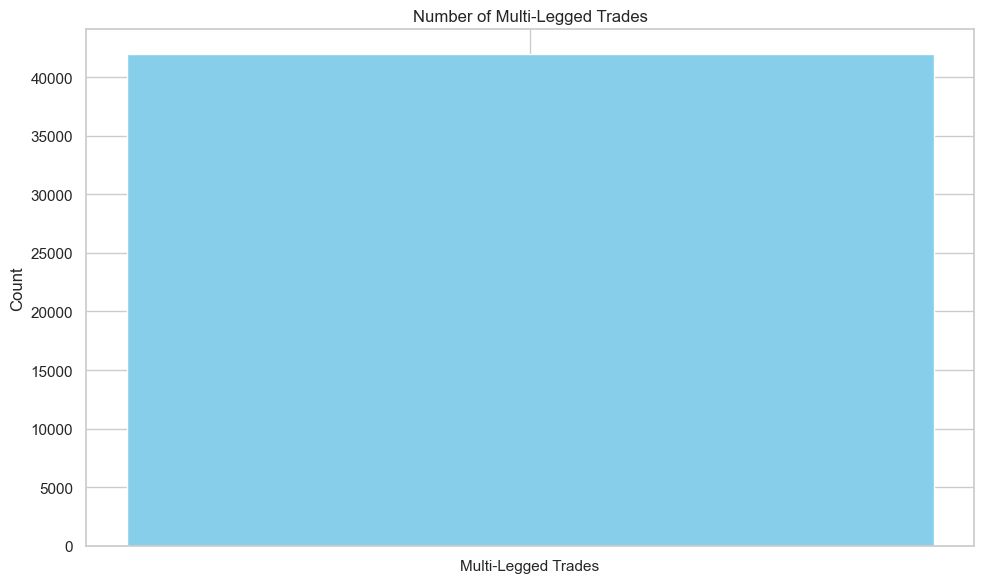

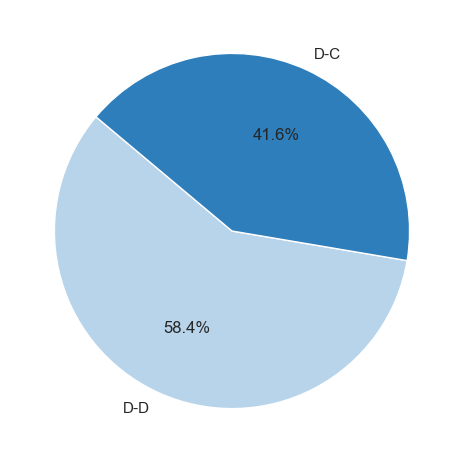

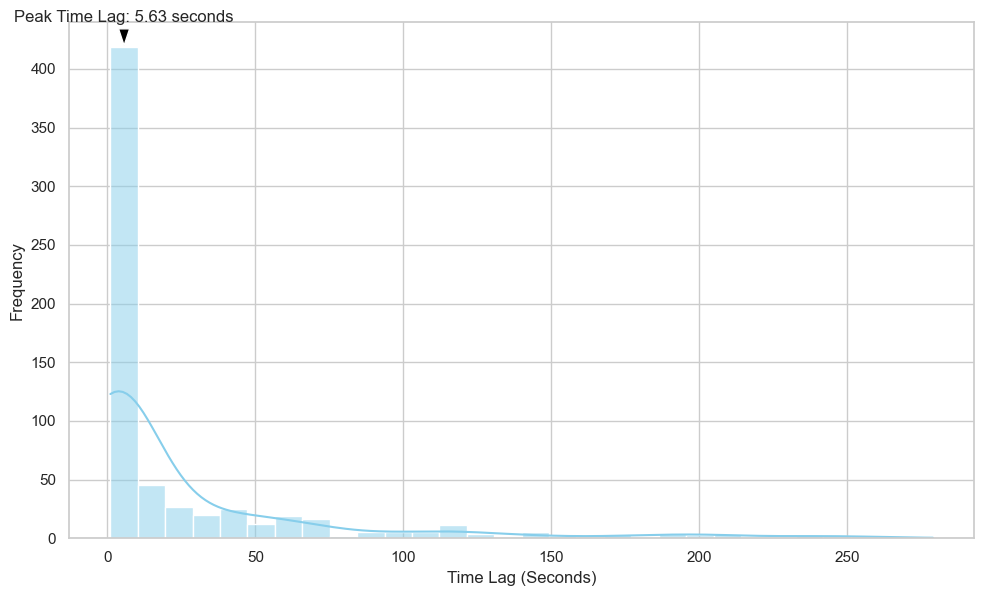

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Bar Chart of the Number of Multi-Legged Trades
plt.figure(figsize=(10, 6))
plt.bar(['Multi-Legged Trades'], [num_multi_legged_trades], color='skyblue')
plt.title('Number of Multi-Legged Trades')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2. Pie Chart of Trade Direction Counts with a blue series
colors = plt.cm.Blues(np.linspace(0.3, 0.7, len(direction_counts)))  # Generating a blue color series
direction_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=colors)
#plt.title('Trade Direction Distribution in Multi-Legged Trades')
plt.ylabel('')  # This removes the 'CombinedTradeType' label on the y-axis
plt.tight_layout()
plt.show()

# 3. Histogram of Time Lags
multi_legged_trades['TimeLagSeconds'] = multi_legged_trades['TimeLag'].dt.total_seconds()

# Remove NaN values and values equal to 0 (which are not actual lags)
time_lags = multi_legged_trades['TimeLagSeconds'].dropna()
time_lags = time_lags[time_lags > 0]

plt.figure(figsize=(10, 6))

# Plotting the histogram with Seaborn
hist_plot = sns.histplot(time_lags, kde=True, color='skyblue', bins=30)
#plt.title('Distribution of Time Lags in Multi-Legged Trades')
plt.xlabel('Time Lag (Seconds)')
plt.ylabel('Frequency')
plt.tight_layout()

# Calculating histogram data for peak annotation
counts, bin_edges = np.histogram(time_lags, bins=30)
max_count_index = np.argmax(counts)  # Index of the bin with the highest count
peak_bin_center = (bin_edges[max_count_index] + bin_edges[max_count_index + 1]) / 2  # Center of the peak bin

# Annotating the peak with the time lag (x-axis value)
plt.annotate(f'Peak Time Lag: {peak_bin_center:.2f} seconds', 
             xy=(peak_bin_center, counts[max_count_index]), 
             xytext=(peak_bin_center, counts[max_count_index] + 0.05 * counts[max_count_index]),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             ha='center')

plt.show()

In [35]:
time_window = '5T' 
filtered_data_5['RoundedTime'] = filtered_data_5['TRADE_DATETIME'].dt.round(time_window)

# Group by 'TRADE_VOLUME' and 'RoundedTime'
grouped = filtered_data_5.groupby(['RoundedTime','ASSUMED_QUANTITY','CUSIP'])

# Function to identify multi-legged trades
def find_multi_legged(group):
    if len(group['PRICE'].unique()) > 1:  
        return group
    return None

# Apply the function to the grouped data
multi_legged_trades = grouped.apply(find_multi_legged).dropna().reset_index(drop=True)

# Counting the number of multi-legged trades
num_multi_legged_trades = len(multi_legged_trades)

# Assessing volume impact
total_volume_multi_legged_5 = multi_legged_trades['TRADE_VOLUME'].sum()
total_volume_all = filtered_data_5['TRADE_VOLUME'].sum()
percentage_volume_multi_legged = (total_volume_multi_legged_5 / total_volume_all) * 100
print(f"Number of Multi-legged Trades: {num_multi_legged_trades}")
print(f"Percentage of Total Volume in Multi-legged Trades: {percentage_volume_multi_legged}%")

# Count the occurrences of each direction in multi-legged trades
direction_counts = multi_legged_trades['CombinedTradeType'].value_counts()
print("Direction Counts in Multi-Legged Trades:")
print(direction_counts)

# Calculate the time difference between consecutive trades within each multi-legged group
multi_legged_trades['TRADE_DATETIME'] = pd.to_datetime(multi_legged_trades['TRADE_DATETIME'])
multi_legged_trades['TimeLag'] = multi_legged_trades.sort_values('TRADE_DATETIME').groupby(['TRADE_VOLUME', 'RoundedTime'])['TRADE_DATETIME'].diff()

# Calculate descriptive statistics for time lags
time_lag_descriptive_stats = multi_legged_trades['TimeLag'].describe()
print("Time Lag Descriptive Statistics:")
print(time_lag_descriptive_stats)

# Handle time lags for more than two legs
multi_legged_trades['TimeLagSeconds'] = multi_legged_trades['TimeLag'].dt.total_seconds()
average_time_lag_per_group = multi_legged_trades.groupby(['TRADE_VOLUME', 'RoundedTime'])['TimeLagSeconds'].mean()

# Print average time lag per group
print("Average Time Lag per Group:")
print(average_time_lag_per_group)


/var/folders/hp/_b6xsbmj35l1y01h13czdks80000gn/T/ipykernel_27115/3588957443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_5['RoundedTime'] = filtered_data_5['TRADE_DATETIME'].dt.round(time_window)


Number of Multi-legged Trades: 38278
Percentage of Total Volume in Multi-legged Trades: 20.75075046448643%
Direction Counts in Multi-Legged Trades:
D-D    22838
D-C    15440
Name: CombinedTradeType, dtype: int64
Time Lag Descriptive Statistics:
count                         3648
mean     0 days 00:00:03.862938596
std      0 days 00:00:19.544451800
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                0 days 00:00:00
max                0 days 00:03:45
Name: TimeLag, dtype: object
Average Time Lag per Group:
TRADE_VOLUME  RoundedTime        
1.236000e+04  2023-11-17 11:50:00   NaN
1.260000e+04  2023-11-17 11:50:00   NaN
3.406999e+04  2023-11-17 11:30:00   NaN
3.477000e+04  2023-11-17 11:30:00   NaN
3.625000e+04  2023-11-17 10:00:00   NaN
                                     ..
1.223600e+09  2023-11-17 11:15:00   NaN
1.234821e+09  2023-11-17 08:55:00   NaN
1.235560e+09  2023-11-17 08:55:00   NaN
1.244179e+09  2023-11-17

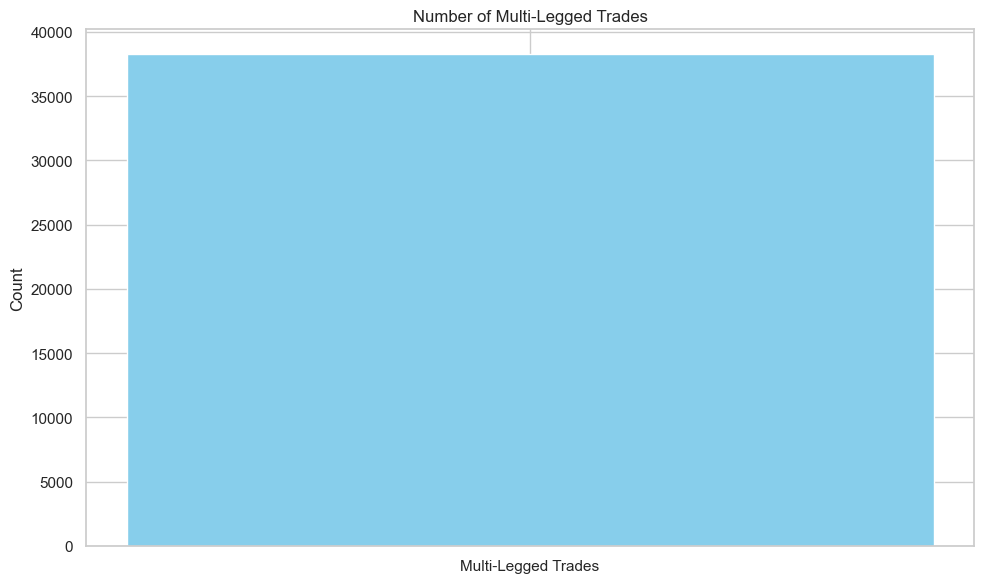

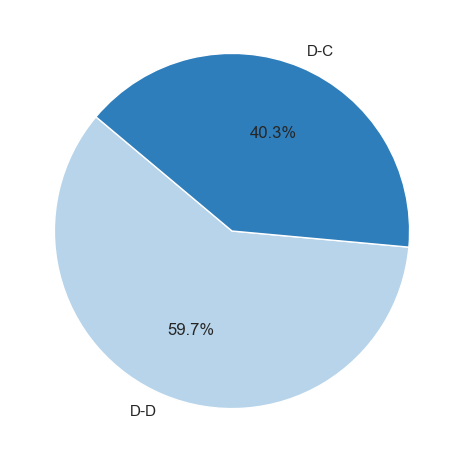

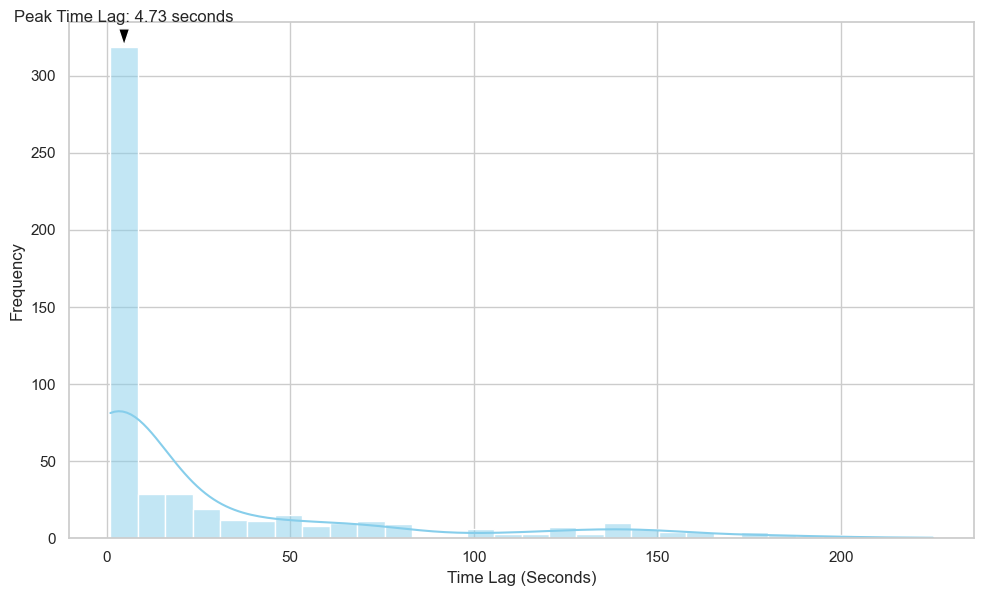

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Bar Chart of the Number of Multi-Legged Trades
plt.figure(figsize=(10, 6))
plt.bar(['Multi-Legged Trades'], [num_multi_legged_trades], color='skyblue')
plt.title('Number of Multi-Legged Trades')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2. Pie Chart of Trade Direction Counts with a blue series
colors = plt.cm.Blues(np.linspace(0.3, 0.7, len(direction_counts)))  # Generating a blue color series
direction_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=colors)
#plt.title('Trade Direction Distribution in Multi-Legged Trades')
plt.ylabel('')  # This removes the 'CombinedTradeType' label on the y-axis
plt.tight_layout()
plt.show()

# 3. Histogram of Time Lags
multi_legged_trades['TimeLagSeconds'] = multi_legged_trades['TimeLag'].dt.total_seconds()

# Remove NaN values and values equal to 0 (which are not actual lags)
time_lags = multi_legged_trades['TimeLagSeconds'].dropna()
time_lags = time_lags[time_lags > 0]

plt.figure(figsize=(10, 6))

# Plotting the histogram with Seaborn
hist_plot = sns.histplot(time_lags, kde=True, color='skyblue', bins=30)
#plt.title('Distribution of Time Lags in Multi-Legged Trades')
plt.xlabel('Time Lag (Seconds)')
plt.ylabel('Frequency')
plt.tight_layout()

# Calculating histogram data for peak annotation
counts, bin_edges = np.histogram(time_lags, bins=30)
max_count_index = np.argmax(counts)  # Index of the bin with the highest count
peak_bin_center = (bin_edges[max_count_index] + bin_edges[max_count_index + 1]) / 2  # Center of the peak bin

# Annotating the peak with the time lag (x-axis value)
plt.annotate(f'Peak Time Lag: {peak_bin_center:.2f} seconds', 
             xy=(peak_bin_center, counts[max_count_index]), 
             xytext=(peak_bin_center, counts[max_count_index] + 0.05 * counts[max_count_index]),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             ha='center')

plt.show()

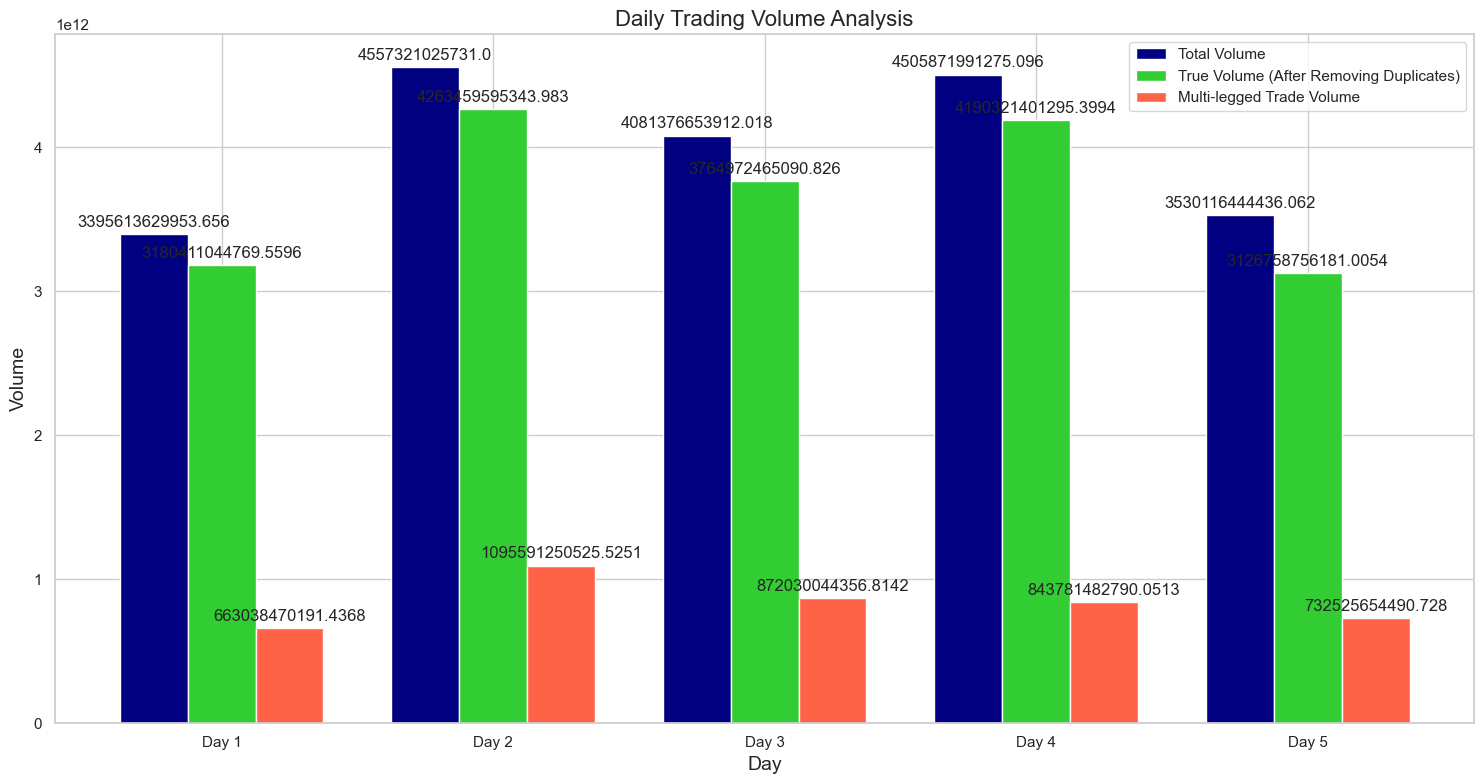

In [37]:
total_volume_1 = filtered_data_1['TRADE_VOLUME'].sum()
total_volume_2 = filtered_data_2['TRADE_VOLUME'].sum()
total_volume_3 = filtered_data_3['TRADE_VOLUME'].sum()
total_volume_4 = filtered_data_4['TRADE_VOLUME'].sum()
total_volume_5 = filtered_data_5['TRADE_VOLUME'].sum()

duplicates_1 = filtered_data_1[filtered_data_1.duplicated(subset=['PRICE', 'ASSUMED_QUANTITY', 'TRADE_DATETIME','CUSIP'], keep=False)]
duplicates_2 = filtered_data_2[filtered_data_2.duplicated(subset=['PRICE', 'ASSUMED_QUANTITY', 'TRADE_DATETIME','CUSIP'], keep=False)]
duplicates_3 = filtered_data_3[filtered_data_3.duplicated(subset=['PRICE', 'ASSUMED_QUANTITY', 'TRADE_DATETIME','CUSIP'], keep=False)]
duplicates_4 = filtered_data_4[filtered_data_4.duplicated(subset=['PRICE', 'ASSUMED_QUANTITY', 'TRADE_DATETIME','CUSIP'], keep=False)]
duplicates_5 = filtered_data_5[filtered_data_5.duplicated(subset=['PRICE', 'ASSUMED_QUANTITY', 'TRADE_DATETIME','CUSIP'], keep=False)]

# Analyzing duplicates
duplicate_volume_1 = duplicates_1['TRADE_VOLUME'].sum()
duplicate_volume_2 = duplicates_2['TRADE_VOLUME'].sum()
duplicate_volume_3 = duplicates_3['TRADE_VOLUME'].sum()
duplicate_volume_4 = duplicates_4['TRADE_VOLUME'].sum()
duplicate_volume_5 = duplicates_5['TRADE_VOLUME'].sum()



import matplotlib.pyplot as plt
import numpy as np

# Sample data - replace these with your actual volumes
total_volumes = [total_volume_1, total_volume_2, total_volume_3, total_volume_4, total_volume_5]
duplicate_volumes = [duplicate_volume_1, duplicate_volume_2, duplicate_volume_3, duplicate_volume_4, duplicate_volume_5]
multi_legged_volumes = [total_volume_multi_legged_1, total_volume_multi_legged_2, total_volume_multi_legged_3, total_volume_multi_legged_4, total_volume_multi_legged_5]

# Adjusting for true volumes (total volume - duplicate volume)
true_volumes = [total - dup for total, dup in zip(total_volumes, duplicate_volumes)]

# Setting up the plot
n_groups = 5
bar_width = 0.25
index = np.arange(n_groups)

fig, ax = plt.subplots(figsize=(15, 8))

bar1 = ax.bar(index, total_volumes, bar_width, label='Total Volume', color='navy')
bar2 = ax.bar(index + bar_width, true_volumes, bar_width, label='True Volume (After Removing Duplicates)', color='limegreen')
bar3 = ax.bar(index + 2*bar_width, multi_legged_volumes, bar_width, label='Multi-legged Trade Volume', color='tomato')

# Adding details
ax.set_xlabel('Day', fontsize=14)
ax.set_ylabel('Volume', fontsize=14)
ax.set_title('Daily Trading Volume Analysis', fontsize=16)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5'])
ax.legend()

# Function to add annotations to each bar
def add_annotations(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_annotations(bar1)
add_annotations(bar2)
add_annotations(bar3)

plt.tight_layout()
plt.show()


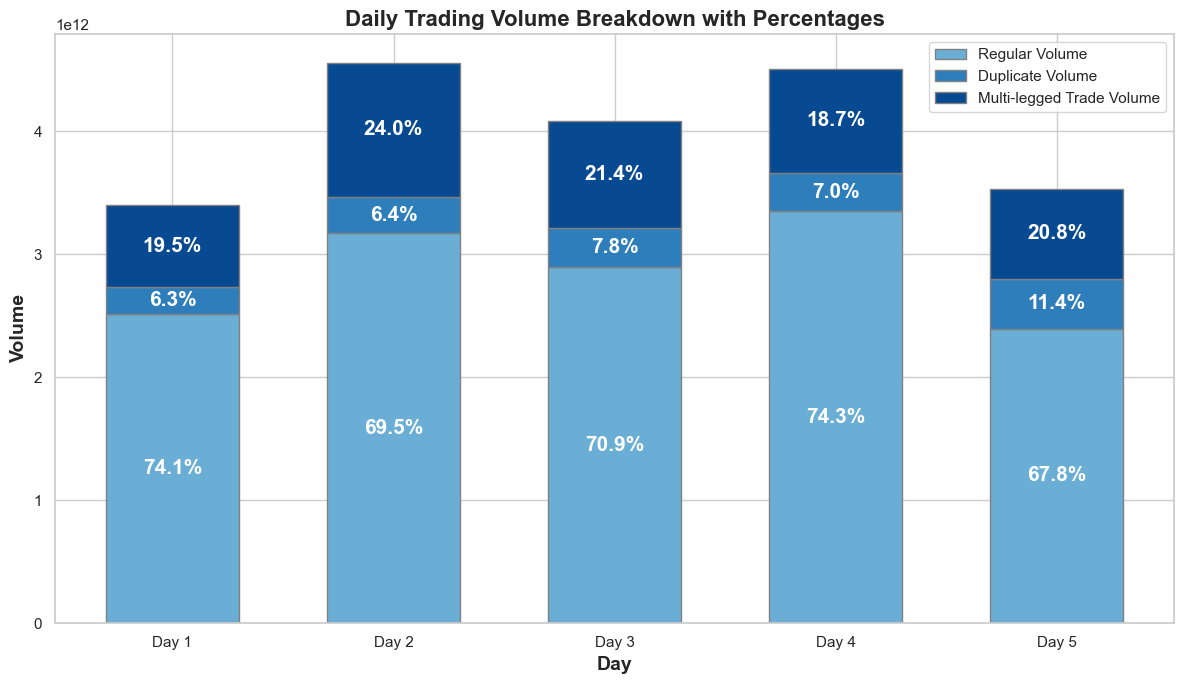

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data - replace these with your actual volumes
total_volumes = [total_volume_1, total_volume_2, total_volume_3, total_volume_4, total_volume_5]
duplicate_volumes = [duplicate_volume_1, duplicate_volume_2, duplicate_volume_3, duplicate_volume_4, duplicate_volume_5]
multi_legged_volumes = [total_volume_multi_legged_1, total_volume_multi_legged_2, total_volume_multi_legged_3, total_volume_multi_legged_4, total_volume_multi_legged_5]

# Calculate non-duplicate, non-multi-legged trade volume
regular_volumes = [total - duplicate - multi_legged for total, duplicate, multi_legged in zip(total_volumes, duplicate_volumes, multi_legged_volumes)]

# Calculate percentages for annotations
percentages_regular = [100 * rv / tv for rv, tv in zip(regular_volumes, total_volumes)]
percentages_duplicate = [100 * dv / tv for dv, tv in zip(duplicate_volumes, total_volumes)]
percentages_multi_legged = [100 * mv / tv for mv, tv in zip(multi_legged_volumes, total_volumes)]

# Define a darker blue color palette using a colormap
color_map = plt.get_cmap('Blues')
colors = color_map(np.linspace(0.5, 0.9, 3))  # Adjusted for darker shades

# Setting up the plot
fig, ax = plt.subplots(figsize=(12, 7))
index = np.arange(len(total_volumes))

# Creating stacked column chart
regular_bar = ax.bar(index, regular_volumes, color=colors[0], edgecolor='grey', width=0.6, label='Regular Volume')
duplicate_bar = ax.bar(index, duplicate_volumes, bottom=regular_volumes, color=colors[1], edgecolor='grey', width=0.6, label='Duplicate Volume')
multi_legged_bottom = np.add(regular_volumes, duplicate_volumes)
multi_legged_bar = ax.bar(index, multi_legged_volumes, bottom=multi_legged_bottom, color=colors[2], edgecolor='grey', width=0.6, label='Multi-legged Trade Volume')

# Adding details
ax.set_xlabel('Day', fontsize=14, fontweight='bold')
ax.set_ylabel('Volume', fontsize=14, fontweight='bold')
ax.set_title('Daily Trading Volume Breakdown with Percentages', fontsize=16, fontweight='bold')
ax.set_xticks(index)
ax.set_xticklabels(['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5'])
ax.legend()

# Function to add annotations for percentages
def add_percentage_annotations():
    for i, rect in enumerate(regular_bar + duplicate_bar + multi_legged_bar):
        height = rect.get_height()
        if i < len(total_volumes):  # Regular Volume
            percentage = percentages_regular[i]
        elif i < 2 * len(total_volumes):  # Duplicate Volume
            percentage = percentages_duplicate[i % len(total_volumes)]
        else:  # Multi-legged Volume
            percentage = percentages_multi_legged[i % len(total_volumes)]
        
        ax.text(rect.get_x() + rect.get_width() / 2., rect.get_y() + height/2., f'{percentage:.1f}%', ha='center', va='center', fontsize=15, color='white', fontweight='bold')

add_percentage_annotations()

# Enhance visual appeal
plt.tight_layout()
plt.show()


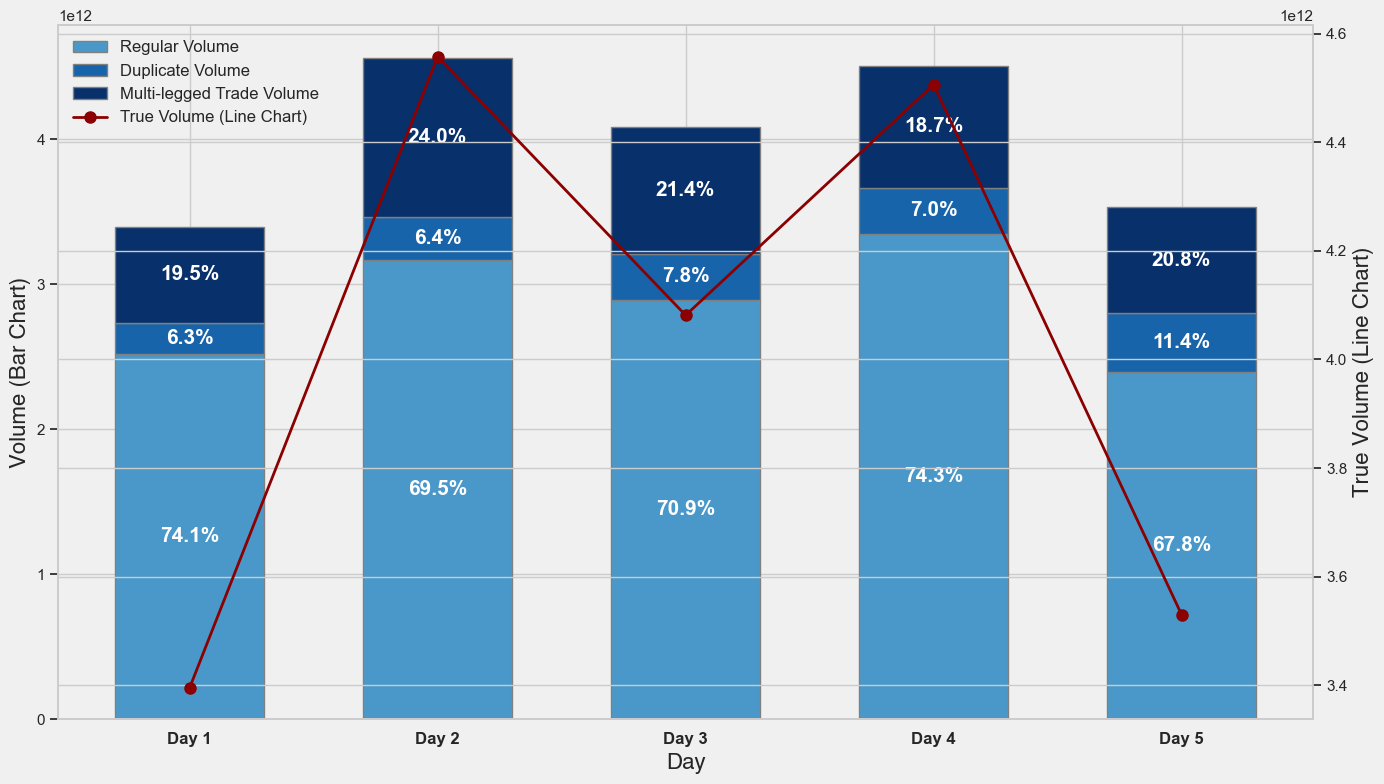

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Sample data - replace these with your actual volumes
total_volumes = [total_volume_1, total_volume_2, total_volume_3, total_volume_4, total_volume_5]
duplicate_volumes = [duplicate_volume_1, duplicate_volume_2, duplicate_volume_3, duplicate_volume_4, duplicate_volume_5]
multi_legged_volumes = [total_volume_multi_legged_1, total_volume_multi_legged_2, total_volume_multi_legged_3, total_volume_multi_legged_4, total_volume_multi_legged_5]

# Calculate true volumes (total volumes minus duplicates and multi-legged trades)
true_volumes = [total - duplicate - multi_legged for total, duplicate, multi_legged in zip(total_volumes, duplicate_volumes, multi_legged_volumes)]

# Define a darker blue color palette using a colormap
color_map = plt.get_cmap('Blues')
colors = color_map(np.linspace(0.6, 1.0, 3))  # Adjusted for darker shades

# Setting up the plot
fig, ax = plt.subplots(figsize=(14, 8))
index = np.arange(len(total_volumes))

# Creating stacked column chart for volumes
regular_bar = ax.bar(index, regular_volumes, color=colors[0], edgecolor='grey', width=0.6, label='Regular Volume')
duplicate_bar = ax.bar(index, duplicate_volumes, bottom=regular_volumes, color=colors[1], edgecolor='grey', width=0.6, label='Duplicate Volume')
multi_legged_bottom = np.add(regular_volumes, duplicate_volumes)
multi_legged_bar = ax.bar(index, multi_legged_volumes, bottom=multi_legged_bottom, color=colors[2], edgecolor='grey', width=0.6, label='Multi-legged Trade Volume')

# Customizing the bar chart
ax.set_facecolor('#f0f0f0')  # Light grey background
fig.patch.set_facecolor('#f0f0f0')
ax.set_xlabel('Day', fontsize=16, fontweight='bold', fontname='Helvetica')
ax.set_ylabel('Volume (Bar Chart)', fontsize=16, fontweight='bold', fontname='Helvetica')
#ax.set_title('Daily Trading Volume Breakdown with Percentages and Total Volume Trend', fontsize=18, fontweight='bold', fontname='Helvetica', color='navy')
ax.set_xticks(index)
ax.set_xticklabels(['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5'], fontweight='bold', fontsize=12)

# Add annotations for percentages
add_percentage_annotations()  # Assuming this function is defined as previously shown



# Creating a secondary y-axis for the line chart
ax2 = ax.twinx()
ax2.plot(index, total_volumes, color='darkred', marker='o', linestyle='-', linewidth=2, markersize=8, label='True Volume (Line Chart)')
ax2.set_ylabel('True Volume (Line Chart)', fontsize=16, fontweight='bold', fontname='Helvetica')

# Creating a combined legend for both bar and line chart
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', frameon=False, fontsize=12)

plt.tight_layout()
plt.show()


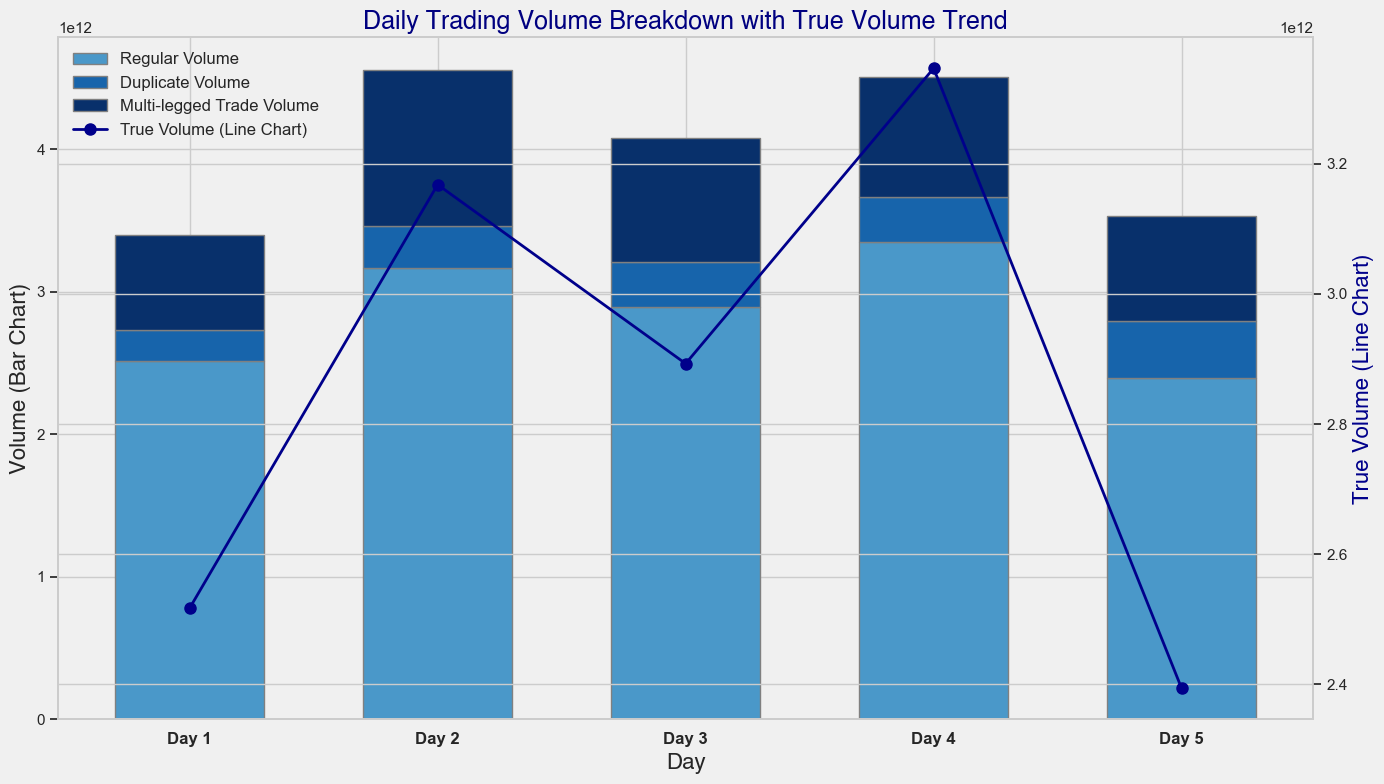

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Sample data - replace these with your actual volumes
total_volumes = [total_volume_1, total_volume_2, total_volume_3, total_volume_4, total_volume_5]
duplicate_volumes = [duplicate_volume_1, duplicate_volume_2, duplicate_volume_3, duplicate_volume_4, duplicate_volume_5]
multi_legged_volumes = [total_volume_multi_legged_1, total_volume_multi_legged_2, total_volume_multi_legged_3, total_volume_multi_legged_4, total_volume_multi_legged_5]

# Calculate true volumes (total volumes minus duplicates and multi-legged trades)
true_volumes = [total - duplicate - multi_legged for total, duplicate, multi_legged in zip(total_volumes, duplicate_volumes, multi_legged_volumes)]

# Define a darker blue color palette using a colormap
color_map = plt.get_cmap('Blues')
colors = color_map(np.linspace(0.6, 1.0, 3))  # Adjusted for darker shades

# Setting up the plot for the stacked column chart
fig, ax = plt.subplots(figsize=(14, 8))
index = np.arange(len(total_volumes))

# Creating stacked column chart for volumes
regular_bar = ax.bar(index, [total - duplicate - multi_legged for total, duplicate, multi_legged in zip(total_volumes, duplicate_volumes, multi_legged_volumes)], color=colors[0], edgecolor='grey', width=0.6, label='Regular Volume')
duplicate_bar = ax.bar(index, duplicate_volumes, bottom=[total - duplicate - multi_legged for total, duplicate, multi_legged in zip(total_volumes, duplicate_volumes, multi_legged_volumes)], color=colors[1], edgecolor='grey', width=0.6, label='Duplicate Volume')
multi_legged_bottom = np.add([total - duplicate - multi_legged for total, duplicate, multi_legged in zip(total_volumes, duplicate_volumes, multi_legged_volumes)], duplicate_volumes)
multi_legged_bar = ax.bar(index, multi_legged_volumes, bottom=multi_legged_bottom, color=colors[2], edgecolor='grey', width=0.6, label='Multi-legged Trade Volume')

# Customizing the bar chart
ax.set_facecolor('#f0f0f0')  # Light grey background
fig.patch.set_facecolor('#f0f0f0')
ax.set_xlabel('Day', fontsize=16, fontweight='bold', fontname='Helvetica')
ax.set_ylabel('Volume (Bar Chart)', fontsize=16, fontweight='bold', fontname='Helvetica')
ax.set_title('Daily Trading Volume Breakdown with True Volume Trend', fontsize=18, fontweight='bold', fontname='Helvetica', color='navy')
ax.set_xticks(index)
ax.set_xticklabels(['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5'], fontweight='bold', fontsize=12)

# Assuming the add_percentage_annotations() function is defined earlier in your code

# Creating a secondary y-axis for the line chart to show true volume
ax2 = ax.twinx()
ax2.plot(index, true_volumes, color='darkblue', marker='o', linestyle='-', linewidth=2, markersize=8, label='True Volume (Line Chart)')
ax2.set_ylabel('True Volume (Line Chart)', fontsize=16, fontweight='bold', fontname='Helvetica', color='darkblue')

# Creating a combined legend for both bar and line chart
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left', frameon=False, fontsize=12)

plt.tight_layout()
plt.show()


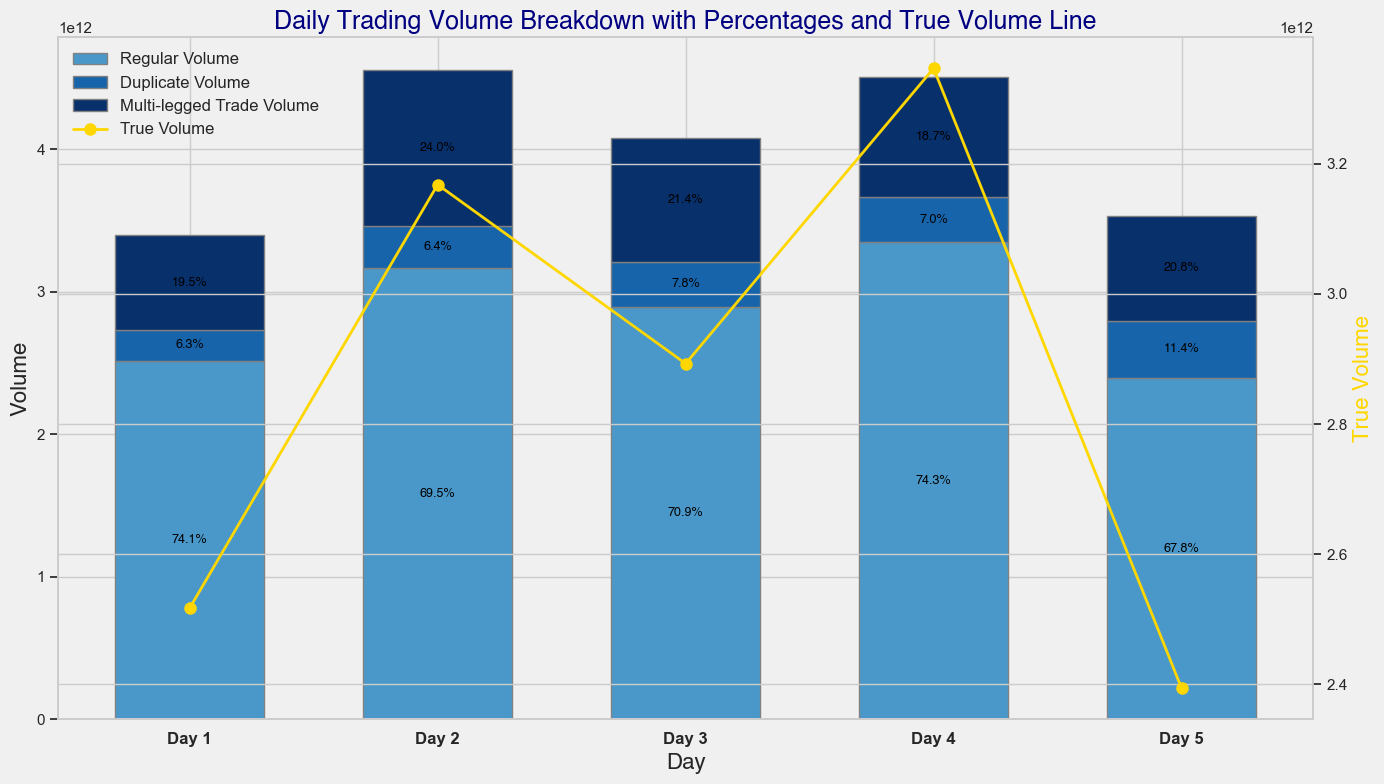

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Sample data - replace these with your actual volumes
total_volumes = [total_volume_1, total_volume_2, total_volume_3, total_volume_4, total_volume_5]
duplicate_volumes = [duplicate_volume_1, duplicate_volume_2, duplicate_volume_3, duplicate_volume_4, duplicate_volume_5]
multi_legged_volumes = [total_volume_multi_legged_1, total_volume_multi_legged_2, total_volume_multi_legged_3, total_volume_multi_legged_4, total_volume_multi_legged_5]

# Calculate non-duplicate, non-multi-legged trade volume
regular_volumes = [total - duplicate - ml for total, duplicate, ml in zip(total_volumes, duplicate_volumes, multi_legged_volumes)]
true_volumes = [total - duplicate - ml for total, duplicate, ml in zip(total_volumes, duplicate_volumes, multi_legged_volumes)]

# Define a darker blue color palette using a colormap
color_map = plt.get_cmap('Blues')
colors = color_map(np.linspace(0.6, 1.0, 3))  # Adjusted for darker shades

# Setting up the plot for stacked column chart
fig, ax1 = plt.subplots(figsize=(14, 8))
index = np.arange(len(total_volumes))

# Creating stacked column chart
regular_bar = ax1.bar(index, regular_volumes, color=colors[0], edgecolor='grey', width=0.6, label='Regular Volume')
duplicate_bar = ax1.bar(index, duplicate_volumes, bottom=regular_volumes, color=colors[1], edgecolor='grey', width=0.6, label='Duplicate Volume')
multi_legged_bottom = np.add(regular_volumes, duplicate_volumes)
multi_legged_bar = ax1.bar(index, multi_legged_volumes, bottom=multi_legged_bottom, color=colors[2], edgecolor='grey', width=0.6, label='Multi-legged Trade Volume')

# Customizing the chart
ax1.set_facecolor('#f0f0f0')  # Light grey background
fig.patch.set_facecolor('#f0f0f0')
ax1.set_xlabel('Day', fontsize=16, fontweight='bold', fontname='Helvetica')
ax1.set_ylabel('Volume', fontsize=16, fontweight='bold', fontname='Helvetica')
ax1.set_title('Daily Trading Volume Breakdown with Percentages and True Volume Line', fontsize=18, fontweight='bold', fontname='Helvetica', color='navy')
ax1.set_xticks(index)
ax1.set_xticklabels(['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5'], fontweight='bold', fontsize=12)

# Function to add annotations for percentages
def add_percentage_annotations():
    cumulative_heights = np.zeros(len(total_volumes))
    datasets = [regular_volumes, duplicate_volumes, multi_legged_volumes]
    for i, dataset in enumerate(datasets):
        percentages = [100 * (value / total) for value, total in zip(dataset, total_volumes)]
        for idx, rect in enumerate(ax1.patches[i*len(total_volumes):(i+1)*len(total_volumes)]):
            height = rect.get_height()
            cumulative_heights[idx] += height
            percentage = percentages[idx]
            # Adjust text color to black for better visibility
            text_color = 'black'
            # Adjust vertical position to be within each segment
            vertical_position = cumulative_heights[idx] - (height / 2.)
            ax1.text(rect.get_x() + rect.get_width() / 2., vertical_position, f'{percentage:.1f}%', 
                    ha='center', va='center', fontsize=9, color=text_color, fontweight='bold', fontname='Helvetica')

add_percentage_annotations()

# Overlaying a line chart for true trading volumes on a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(index, true_volumes, color='gold', marker='o', linestyle='-', linewidth=2, markersize=8, label='True Volume')
ax2.set_ylabel('True Volume', fontsize=16, fontweight='bold', fontname='Helvetica', color='gold')

# Adding legend to include line chart
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', frameon=False, fontsize=12)

plt.tight_layout()
plt.show()


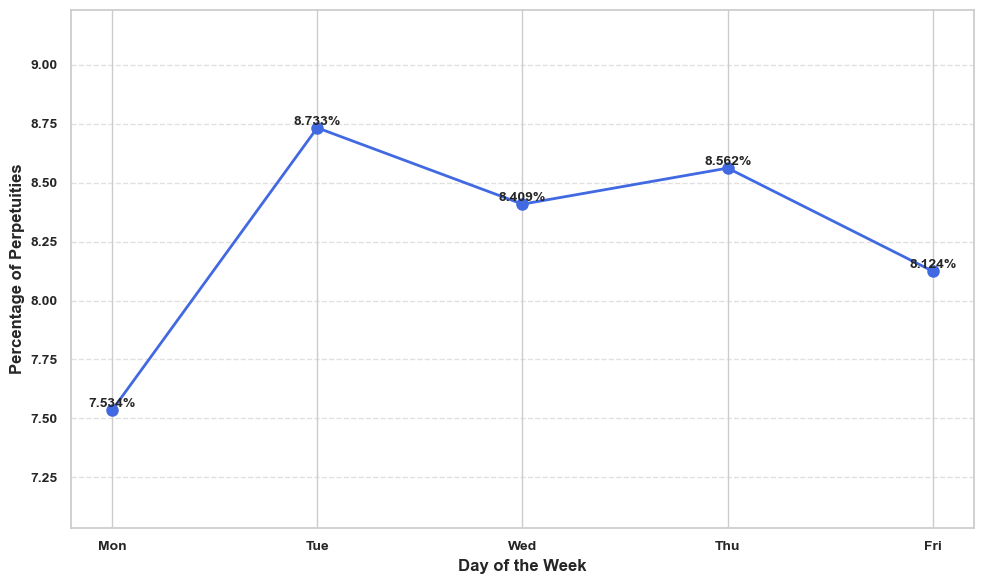

In [42]:
import matplotlib.pyplot as plt

# Data
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
percentages = [7.534, 8.733, 8.409, 8.562, 8.124]
days_index = range(len(days))  # Convert days to numerical index for plotting

# Creating the line graph
plt.figure(figsize=(10, 6))
plt.plot(days_index, percentages, marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=8)

# Adding percentage values above each point
for i, percentage in enumerate(percentages):
    plt.text(days_index[i], percentage, f'{percentage:.3f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Customizing the chart
#plt.title('Percentage of Perpetuities by Day of the Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of the Week', fontsize=12, fontweight='bold')
plt.ylabel('Percentage of Perpetuities', fontsize=12, fontweight='bold')
plt.xticks(days_index, days, fontsize=10, fontweight='bold')  # Set the x-ticks to be the days of the week
plt.yticks(fontsize=10, fontweight='bold')
plt.ylim(min(percentages) - 0.5, max(percentages) + 0.5)  # Adjust y-axis limits for clarity

# Adding a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure (optional, if you need to save the chart as an image file for the PPT)
plt.savefig('perpetuities_percentage_line_graph.png', dpi=300)

plt.show()


/var/folders/hp/_b6xsbmj35l1y01h13czdks80000gn/T/ipykernel_27115/3097296531.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # A sophisticated style template from seaborn


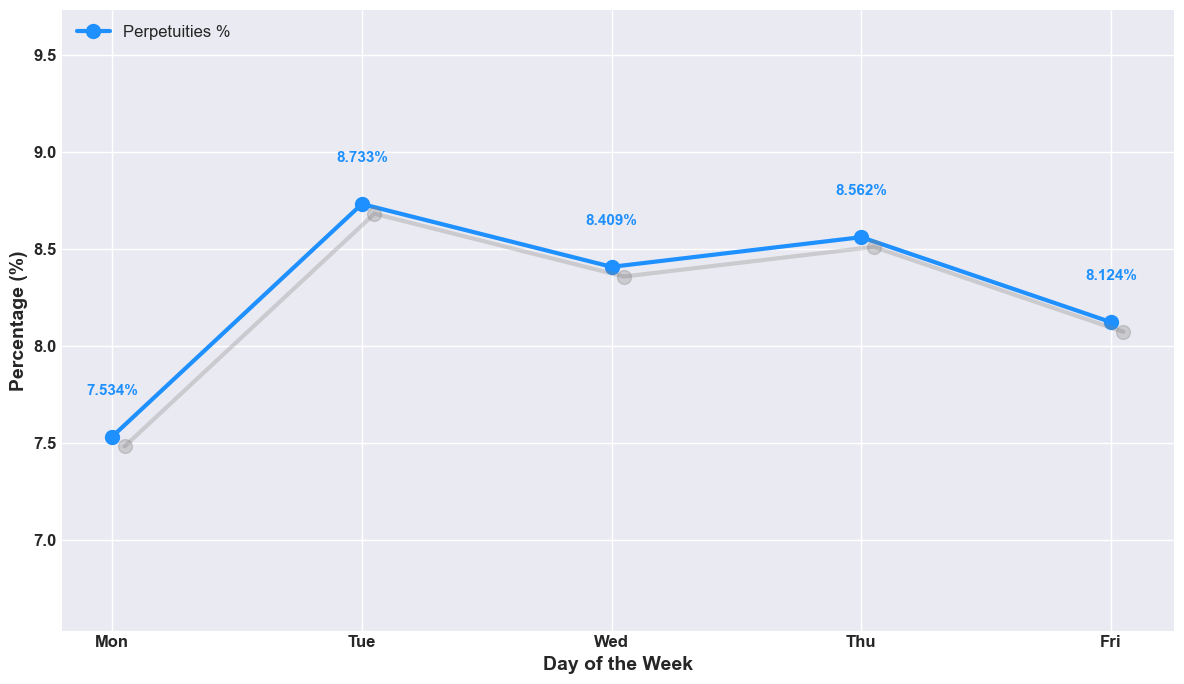

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Data
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
percentages = [7.534, 8.733, 8.409, 8.562, 8.124]
days_index = np.arange(len(days))  # Using numpy for better control over the plot

# Setting the style
plt.style.use('seaborn-darkgrid')  # A sophisticated style template from seaborn

# Creating the line graph
plt.figure(figsize=(12, 7))
line, = plt.plot(days_index, percentages, marker='o', linestyle='-', color='dodgerblue', linewidth=3, markersize=10, label='Perpetuities %')

# Adding a shadow effect
shadow_offset = 0.05
plt.plot(days_index + shadow_offset, [p - shadow_offset for p in percentages], marker='o', linestyle='-', color='grey', linewidth=3, markersize=10, alpha=0.3)

# Highlighting each data point with annotations
for i, percentage in enumerate(percentages):
    plt.text(days_index[i], percentage + 0.2, f'{percentage:.3f}%', ha='center', va='bottom', fontweight='bold', fontsize=11, color='dodgerblue')

# Enhancing the plot
#plt.title('Weekly Percentage of Perpetuities', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Day of the Week', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=14, fontweight='bold')
plt.xticks(days_index, days, fontsize=12, fontweight='bold')  # Set the x-ticks to be the days
plt.yticks(fontsize=12, fontweight='bold')
plt.ylim(min(percentages) - 1, max(percentages) + 1)  # Extend y-axis limits

# Adding a legend
plt.legend(loc='upper left', fontsize=12)

# Adding a sophisticated touch with a spined layout
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')

# Tight layout for better spacing
plt.tight_layout()

# Save the figure (optional, if you need to save the chart as an image file for the PPT)
plt.savefig('fancy_perpetuities_percentage_line_graph.png', dpi=300, bbox_inches='tight')

plt.show()
